# VGG

## Setup Kaggle di Colab

In [20]:
# Install library Kaggle untuk download dataset
!pip install kaggle -q
import os
import sys

# Buat direktori .kaggle jika belum ada
!mkdir -p ~/.kaggle

# Cek apakah file kaggle.json sudah diupload
if os.path.exists('/content/kaggle.json'):
    # Pindahkan kaggle.json ke direktori .kaggle
    !mv /content/kaggle.json ~/.kaggle/
    # Set permission file agar secure
    !chmod 600 ~/.kaggle/kaggle.json
    print("kaggle.json berhasil dikonfigurasi.")
else:
    print("kaggle.json tidak ditemukan di /content/. Silakan upload file kaggle.json terlebih dahulu.")

kaggle.json tidak ditemukan di /content/. Silakan upload file kaggle.json terlebih dahulu.


## Download Dataset dari Kaggle

In [21]:
# Download dataset CelebA 64x64 dari Kaggle
!kaggle datasets download -d therealcyberlord/50k-celeba-dataset-64x64

Dataset URL: https://www.kaggle.com/datasets/therealcyberlord/50k-celeba-dataset-64x64
License(s): unknown
50k-celeba-dataset-64x64.zip: Skipping, found more recently modified local copy (use --force to force download)


## Extract Dataset

In [22]:
import zipfile
import os

# Path file zip yang telah didownload
zip_file_path = '/content/50k-celeba-dataset-64x64.zip'

# Direktori tujuan ekstraksi
extracted_path = '/content/celeba_dataset_kaggle/'

# Buat folder ekstraksi jika belum ada
os.makedirs(extracted_path, exist_ok=True)

# Ekstrak file zip
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print("Dataset berhasil diekstrak.")
except FileNotFoundError:
    print(f"Error: File {zip_file_path} tidak ditemukan. Pastikan download berhasil.")
except zipfile.BadZipFile:
    print(f"Error: File {zip_file_path} bukan zip yang valid. Download mungkin corrupt.")
except Exception as e:
    print(f"Error saat ekstraksi: {e}")

Dataset berhasil diekstrak.


## Cek Isi Folder

In [23]:
import os

# Tampilkan isi direktori hasil ekstraksi
extracted_path = '/content/celeba_dataset_kaggle/'
print("Isi folder ekstraksi:")
print(os.listdir(extracted_path))

Isi folder ekstraksi:
['50k']


## Download Attribute File (Label)

In [24]:
# Download file atribut dari GitHub (alternatif jika gagal)
# Opsional: Bisa juga download manual dari Google Drive
# Link Google Drive: https://drive.google.com/drive/folders/1AA21MR8GeQdnOVgmNcbxCrbAjL1udj0l

import requests
import os

# URL file atribut CelebA
attribute_file_url = "https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt"
attribute_file_path = "/content/list_attr_celeba.txt"

print(f"Mencoba download file atribut dari: {attribute_file_url}")

try:
    response = requests.get(attribute_file_url, stream=True)
    response.raise_for_status()  # Raise error jika status 4xx atau 5xx

    with open(attribute_file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"File atribut berhasil didownload ke: {attribute_file_path}")

except requests.exceptions.RequestException as e:
    print(f"Error saat download file atribut: {e}")
    print("Tidak dapat mendownload file dari URL yang diberikan.")
    print("Silakan download manual dari Google Drive dan upload ke Colab.")
except Exception as e:
    print(f"Error saat memproses file atribut: {e}")

Mencoba download file atribut dari: https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt
Error saat download file atribut: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt
Tidak dapat mendownload file dari URL yang diberikan.
Silakan download manual dari Google Drive dan upload ke Colab.


## Load Gambar ke Numpy

In [25]:
import os
import cv2
import numpy as np

# Direktori tempat gambar hasil ekstraksi
image_dir = '/content/celeba_dataset_kaggle/50k'

# Ukuran target gambar (dataset sudah 64x64)
image_size = (64, 64)

# List semua file gambar (format .jpg atau .png)
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]

# Batasi jumlah gambar untuk eksperimen awal (opsional)
# Bisa dihapus atau diubah untuk load seluruh dataset
num_images_to_load = 10000  # Load 10,000 gambar
image_files = image_files[:num_images_to_load]

print(f"Memulai loading {len(image_files)} gambar...")

# Load dan preprocess gambar
images = []
for idx, file_name in enumerate(image_files):
    img_path = os.path.join(image_dir, file_name)
    img = cv2.imread(img_path)

    if img is not None:
        # Konversi dari BGR (OpenCV default) ke RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize jika ukuran tidak sesuai (meskipun dataset sudah 64x64)
        if img.shape[:2] != image_size:
            img = cv2.resize(img, image_size)

        images.append(img)
    else:
        print(f"Warning: Tidak dapat membaca gambar {img_path}")

    # Progress indicator setiap 1000 gambar
    if (idx + 1) % 1000 == 0:
        print(f"Progress: {idx + 1}/{len(image_files)} gambar diload")

# Konversi list ke NumPy array
images = np.array(images)

print(f"\nBerhasil load {len(images)} gambar.")
print(f"Shape array gambar: {images.shape}")
print(f"Tipe data: {images.dtype}")
print(f"Range nilai piksel: [{images.min()}, {images.max()}]")

Memulai loading 10000 gambar...
Progress: 1000/10000 gambar diload
Progress: 2000/10000 gambar diload
Progress: 3000/10000 gambar diload
Progress: 4000/10000 gambar diload
Progress: 5000/10000 gambar diload
Progress: 6000/10000 gambar diload
Progress: 7000/10000 gambar diload
Progress: 8000/10000 gambar diload
Progress: 9000/10000 gambar diload
Progress: 10000/10000 gambar diload

Berhasil load 10000 gambar.
Shape array gambar: (10000, 64, 64, 3)
Tipe data: uint8
Range nilai piksel: [0, 255]


## Load Attribute File

In [26]:
import pandas as pd
import numpy as np
import os

# Path file atribut yang sudah diupload
attribute_file_path = '/content/list_attr_celeba.txt'

if os.path.exists(attribute_file_path):
    print(f"File atribut ditemukan di: {attribute_file_path}")

    # Load file atribut CelebA
    # Format: baris pertama = jumlah data, baris kedua = nama kolom
    # Skip 1 baris pertama, gunakan regex untuk separator (bisa multiple spaces)
    attributes_df = pd.read_csv(attribute_file_path, sep=r'\s+', skiprows=1)

    # Tampilkan 5 baris pertama untuk verifikasi
    print("\nPreview Data Atribut:")
    display(attributes_df.head())

    # Pastikan variabel 'image_files' sudah ada dari step sebelumnya (load gambar)
    if 'image_files' in globals():
        # Ambil nama file gambar yang sudah diload (tanpa path)
        loaded_image_filenames = [os.path.basename(f) for f in image_files]

        # Pastikan index dataframe bertipe string untuk matching dengan filename
        attributes_df.index = attributes_df.index.astype(str)

        # Ambil kolom 'Male' sebagai label
        # Nilai: -1 = Female, 1 = Male
        if 'Male' in attributes_df.columns:
            # Reindex untuk mencocokkan urutan gambar yang diload
            loaded_attributes = attributes_df.reindex(loaded_image_filenames)

            # Ekstrak kolom 'Male' dan konversi -1 menjadi 0 (Female=0, Male=1)
            # Handle NaN values dengan fillna(-1) jika ada gambar tanpa label
            male_labels = loaded_attributes['Male'].fillna(-1).replace(-1, 0).values

            # Cek apakah jumlah label cocok dengan jumlah gambar
            if len(male_labels) != len(images):
                print(f"\nPeringatan: Jumlah label ({len(male_labels)}) tidak cocok dengan jumlah gambar ({len(images)}).")
                print("Mungkin ada gambar yang tidak memiliki label.")

            print(f"\nBerhasil load {len(male_labels)} label 'Male'.")
            print(f"Shape array label: {male_labels.shape}")
            print(f"Contoh 10 label pertama: {male_labels[:10]}")

        else:
            print("Kolom 'Male' tidak ditemukan dalam file atribut.")
            male_labels = None

    else:
        print("Error: Variabel 'image_files' tidak ditemukan. Jalankan cell load gambar terlebih dahulu.")
        attributes_df = None
        male_labels = None

else:
    print(f"File atribut ({attribute_file_path}) tidak ditemukan.")
    print("Silakan upload file 'list_attr_celeba.txt' ke direktori /content/")
    male_labels = None

# Validasi akhir: set male_labels ke None jika ada masalah
if male_labels is None or len(male_labels) != len(images):
    print("\nGagal load label atau jumlah tidak cocok. Setting male_labels = None.")
    male_labels = None

File atribut ditemukan di: /content/list_attr_celeba.txt

Preview Data Atribut:


,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1



Berhasil load 10000 label 'Male'.
Shape array label: (10000,)
Contoh 10 label pertama: [1 0 1 0 1 0 0 1 1 0]


## Split Data menjadi Training dan Validation

In [27]:
from sklearn.model_selection import train_test_split

# Cek apakah jumlah gambar dan label sama
if len(images) == len(male_labels):
    print(f"Jumlah gambar ({len(images)}) dan label ({len(male_labels)}) cocok. Melanjutkan split data.")

    # Split data: 80% training, 20% validation
    # stratify digunakan untuk menjaga distribusi kelas (Male/Female) tetap seimbang
    train_images, val_images, train_labels, val_labels = train_test_split(
        images,
        male_labels,
        test_size=0.2,      # 20% untuk validation
        random_state=42,    # Untuk reproducibility
        stratify=male_labels # Jaga keseimbangan kelas
    )

    print(f"\n=== Hasil Split Data ===")
    print(f"Training images shape: {train_images.shape}")
    print(f"Validation images shape: {val_images.shape}")
    print(f"Training labels shape: {train_labels.shape}")
    print(f"Validation labels shape: {val_labels.shape}")

    # Tampilkan distribusi kelas
    print(f"\n=== Distribusi Kelas ===")
    print(f"Training - Female: {(train_labels == 0).sum()}, Male: {(train_labels == 1).sum()}")
    print(f"Validation - Female: {(val_labels == 0).sum()}, Male: {(val_labels == 1).sum()}")

else:
    print(f"Error: Jumlah gambar ({len(images)}) dan label ({len(male_labels)}) tidak cocok!")
    print("Periksa kembali proses loading data.")
    train_images, val_images, train_labels, val_labels = None, None, None, None

Jumlah gambar (10000) dan label (10000) cocok. Melanjutkan split data.

=== Hasil Split Data ===
Training images shape: (8000, 64, 64, 3)
Validation images shape: (2000, 64, 64, 3)
Training labels shape: (8000,)
Validation labels shape: (2000,)

=== Distribusi Kelas ===
Training - Female: 4678, Male: 3322
Validation - Female: 1169, Male: 831


## VGG - Tipe 1

### Build Model

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definisi ukuran input (Height, Width, Channels)
input_shape = (64, 64, 3)

print("="*60)
print("🔵 VGG TIPE 1 - BASELINE (Quick Training)")
print("="*60)
print("Membangun arsitektur VGG-like model...")

# Bangun model VGG menggunakan Sequential API
model_type1 = models.Sequential([

    # === BLOCK 1 ===
    # Conv layer pertama: ekstrak fitur dasar (edges, corners)
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    # Conv layer kedua: pelajari fitur lebih kompleks dari block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    # MaxPooling: ambil fitur paling dominan, kurangi dimensi spatial (64x64 -> 32x32)
    layers.MaxPooling2D((2, 2)),

    # === BLOCK 2 ===
    # Filter ditingkatkan jadi 64 untuk tangkap fitur lebih kompleks
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    # MaxPooling: kurangi dimensi lagi (32x32 -> 16x16)
    layers.MaxPooling2D((2, 2)),

    # === BLOCK 3 ===
    # Filter ditingkatkan jadi 128 untuk fitur high-level
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    # MaxPooling: dimensi akhir (16x16 -> 8x8)
    layers.MaxPooling2D((2, 2)),

    # === FULLY CONNECTED LAYERS ===
    # Flatten: ubah output 3D (8x8x128) menjadi 1D vector (8192 neuron)
    layers.Flatten(),

    # Dense layer: gabungkan semua fitur untuk klasifikasi
    # 512 neuron dengan ReLU activation
    layers.Dense(512, activation='relu'),

    # Dropout: randomly matikan 50% neuron saat training untuk cegah overfitting
    layers.Dropout(0.5),

    # Output layer: 1 neuron untuk binary classification (Male/Female)
    # Sigmoid: output probabilitas antara 0 dan 1
    layers.Dense(1, activation='sigmoid')
])

# Tampilkan arsitektur model
print("\n=== Arsitektur Model VGG Tipe 1 ===")
model_type1.summary()
print(f"\nTotal parameter: {model_type1.count_params():,}")
print("="*60)

🔵 VGG TIPE 1 - BASELINE (Quick Training)
Membangun arsitektur VGG-like model...

=== Arsitektur Model VGG Tipe 1 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,629,921 (17.66 MB)

 Trainable params: 4,629,921 (17.66 MB)

 Non-trainable params: 0 (0.00 B)


Total parameter: 4,629,921


### Compile Model

In [29]:
from tensorflow.keras.optimizers import Adam

# === KONFIGURASI TIPE 1 ===
config_name = "Baseline - Quick Training"
learning_rate_type1 = 0.001  # Default Adam learning rate

print("="*60)
print("🔵 COMPILE MODEL - TIPE 1")
print("="*60)
print(f"Konfigurasi: {config_name}")
print(f"Learning Rate: {learning_rate_type1}")
print(f"Optimizer: Adam")
print(f"Loss Function: Binary Crossentropy")
print("="*60)

print("\n📌 REASONING TIPE 1 (Baseline):")
print("-"*60)
print("""
- Learning Rate: 0.001
  → Default learning rate Adam optimizer
  → Cocok untuk training awal tanpa tuning khusus
  → Balance antara kecepatan konvergensi dan stabilitas

- Optimizer: Adam
  → Adaptive learning rate, bagus untuk banyak kasus
  → Kombinasi momentum + RMSprop
  → Efisien untuk dataset image classification

- Loss: Binary Crossentropy
  → Standard untuk klasifikasi binary (Male/Female)
  → Mengukur perbedaan antara prediksi dan label sebenarnya

✅ TUJUAN: Mendapatkan baseline performance dengan konfigurasi standar
""")
print("="*60)

# Compile model
model_type1.compile(
    optimizer=Adam(learning_rate=learning_rate_type1),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model Tipe 1 berhasil dikompilasi!")

🔵 COMPILE MODEL - TIPE 1
Konfigurasi: Baseline - Quick Training
Learning Rate: 0.001
Optimizer: Adam
Loss Function: Binary Crossentropy

📌 REASONING TIPE 1 (Baseline):
------------------------------------------------------------

- Learning Rate: 0.001
  → Default learning rate Adam optimizer
  → Cocok untuk training awal tanpa tuning khusus
  → Balance antara kecepatan konvergensi dan stabilitas

- Optimizer: Adam
  → Adaptive learning rate, bagus untuk banyak kasus
  → Kombinasi momentum + RMSprop
  → Efisien untuk dataset image classification

- Loss: Binary Crossentropy
  → Standard untuk klasifikasi binary (Male/Female)
  → Mengukur perbedaan antara prediksi dan label sebenarnya

✅ TUJUAN: Mendapatkan baseline performance dengan konfigurasi standar


✅ Model Tipe 1 berhasil dikompilasi!


### Train Model

In [30]:
import time

# === KONFIGURASI TRAINING TIPE 1 ===
epochs_type1 = 10
batch_size_type1 = 32
learning_rate_type1 = 0.001
config_name = "Lightweight"

print("="*60)
print("🚀 TRAINING VGG - TIPE 1 (LIGHTWEIGHT)")
print("="*60)
print(f"Konfigurasi: {config_name}")
print("-"*60)
print(f"Epochs: {epochs_type1}")
print(f"Batch Size: {batch_size_type1}")
print(f"Learning Rate: {learning_rate_type1}")
print(f"Dropout Rate: 0.3")
print("-"*60)
print(f"Total training samples: {len(train_images):,}")
print(f"Total validation samples: {len(val_images):,}")
print(f"Steps per epoch: {len(train_images) // batch_size_type1}")
print(f"Total steps: {(len(train_images) // batch_size_type1) * epochs_type1}")
print("="*60)

print("\n📌 REASONING HYPERPARAMETER TIPE 1 (Lightweight):")
print("-"*60)
print("""
- Epochs: 10
  → Cukup untuk melihat trend awal training
  → Tidak terlalu lama, cocok untuk eksperimen cepat
  → Baseline untuk perbandingan dengan Tipe 2

- Batch Size: 32
  → Ukuran batch standar yang balance
  → Memory-friendly untuk dataset besar
  → Update gradient lebih sering = learning lebih dinamis

- Learning Rate: 0.001
  → Standard learning rate untuk Adam optimizer
  → Konvergensi cepat tanpa overshooting
  → Optimal untuk training from scratch

- Dropout: 0.3
  → Moderate regularization
  → Cegah overfitting tanpa terlalu agresif
  → Konsisten dengan V1 pattern (VGG, GoogleNet, AlexNet)

✅ COCOK UNTUK: Quick experimentation, baseline comparison
""")
print("="*60)

# Catat waktu mulai training
start_time = time.time()

# Train model
history_type1 = model_type1.fit(
    train_images,
    train_labels,
    epochs=epochs_type1,
    batch_size=batch_size_type1,
    validation_data=(val_images, val_labels),
    verbose=1
)

# Hitung durasi training
end_time = time.time()
training_duration_type1 = end_time - start_time

print("\n" + "="*60)
print("✅ TRAINING VGG TIPE 1 SELESAI!")
print("="*60)
print(f"⏱️  Waktu training: {training_duration_type1:.2f} detik ({training_duration_type1/60:.2f} menit)")
print(f"📊 Final Training Accuracy: {history_type1.history['accuracy'][-1]:.4f} ({history_type1.history['accuracy'][-1]*100:.2f}%)")
print(f"📊 Final Validation Accuracy: {history_type1.history['val_accuracy'][-1]:.4f} ({history_type1.history['val_accuracy'][-1]*100:.2f}%)")
print("-"*60)

# Deteksi overfitting (opsional tapi bagus)
gap = history_type1.history['accuracy'][-1] - history_type1.history['val_accuracy'][-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

🚀 TRAINING VGG - TIPE 1 (LIGHTWEIGHT)
Konfigurasi: Lightweight
------------------------------------------------------------
Epochs: 10
Batch Size: 32
Learning Rate: 0.001
Dropout Rate: 0.3
------------------------------------------------------------
Total training samples: 8,000
Total validation samples: 2,000
Steps per epoch: 250
Total steps: 2500

📌 REASONING HYPERPARAMETER TIPE 1 (Lightweight):
------------------------------------------------------------

- Epochs: 10
  → Cukup untuk melihat trend awal training
  → Tidak terlalu lama, cocok untuk eksperimen cepat
  → Baseline untuk perbandingan dengan Tipe 2

- Batch Size: 32
  → Ukuran batch standar yang balance
  → Memory-friendly untuk dataset besar
  → Update gradient lebih sering = learning lebih dinamis

- Learning Rate: 0.001
  → Standard learning rate untuk Adam optimizer
  → Konvergensi cepat tanpa overshooting
  → Optimal untuk training from scratch

- Dropout: 0.3
  → Moderate regularization
  → Cegah overfitting tanpa te

### Plot Training History

/tmp/ipython-input-1005278287.py:33: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


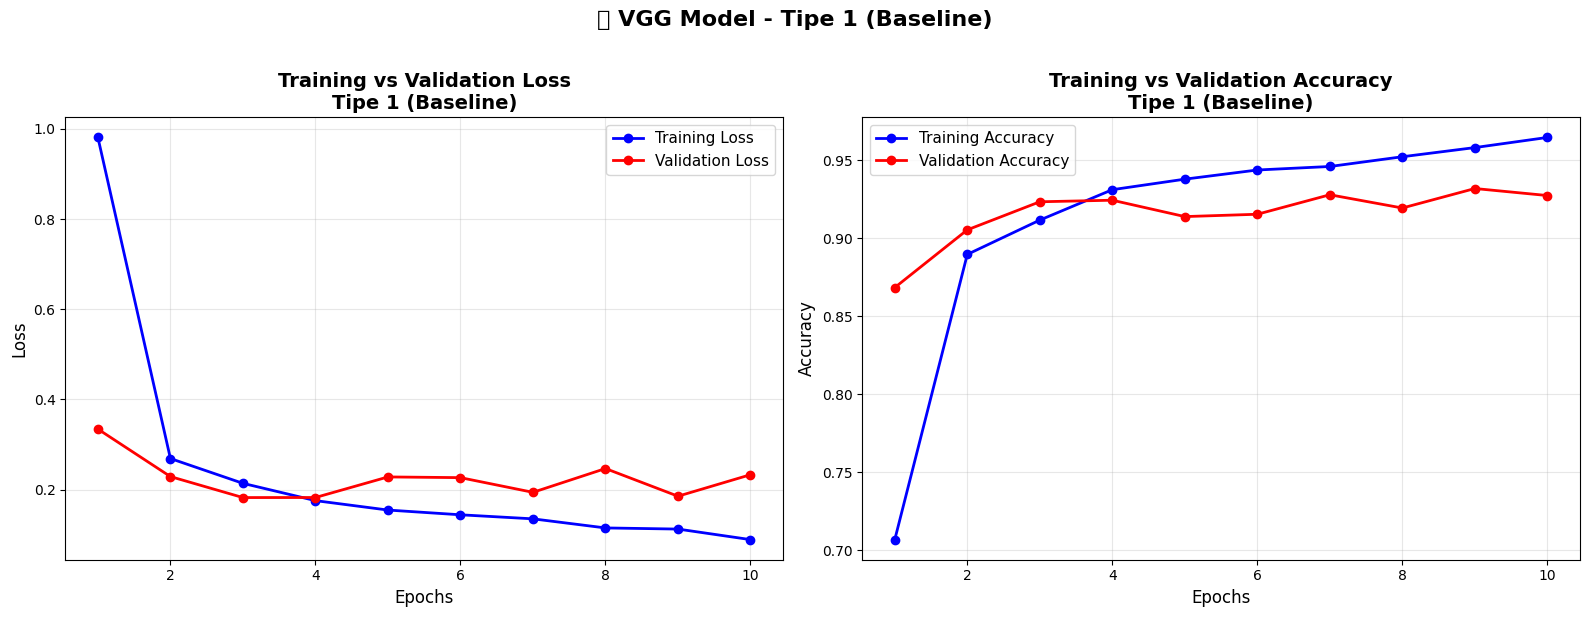


📊 SUMMARY HASIL TRAINING - TIPE 1
Epochs: 10 | Batch Size: 32 | LR: 0.001
------------------------------------------------------------
Final Training Loss      : 0.0890
Final Training Accuracy  : 0.9647 (96.47%)
Final Validation Loss    : 0.2329
Final Validation Accuracy: 0.9275 (92.75%)
Training Duration        : 54.95s (0.92 min)
------------------------------------------------------------
✅ Model balance - tidak ada overfitting/underfitting signifikan


In [31]:
import matplotlib.pyplot as plt

# Ambil data history dari training
loss_values_type1 = history_type1.history['loss']
val_loss_values_type1 = history_type1.history['val_loss']
accuracy_values_type1 = history_type1.history['accuracy']
val_accuracy_values_type1 = history_type1.history['val_accuracy']

epochs_range = range(1, len(loss_values_type1) + 1)

# Buat figure dengan 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Loss
axes[0].plot(epochs_range, loss_values_type1, 'bo-', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(epochs_range, val_loss_values_type1, 'ro-', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_title('Training vs Validation Loss\nTipe 1 (Baseline)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Subplot 2: Accuracy
axes[1].plot(epochs_range, accuracy_values_type1, 'bo-', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].plot(epochs_range, val_accuracy_values_type1, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
axes[1].set_title('Training vs Validation Accuracy\nTipe 1 (Baseline)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('🔵 VGG Model - Tipe 1 (Baseline)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tampilkan summary hasil training
print("\n" + "="*60)
print("📊 SUMMARY HASIL TRAINING - TIPE 1")
print("="*60)
print(f"Epochs: {epochs_type1} | Batch Size: {batch_size_type1} | LR: {learning_rate_type1}")
print("-"*60)
print(f"Final Training Loss      : {loss_values_type1[-1]:.4f}")
print(f"Final Training Accuracy  : {accuracy_values_type1[-1]:.4f} ({accuracy_values_type1[-1]*100:.2f}%)")
print(f"Final Validation Loss    : {val_loss_values_type1[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy_values_type1[-1]:.4f} ({val_accuracy_values_type1[-1]*100:.2f}%)")
print(f"Training Duration        : {training_duration_type1:.2f}s ({training_duration_type1/60:.2f} min)")
print("-"*60)

# Deteksi overfitting
gap = accuracy_values_type1[-1] - val_accuracy_values_type1[-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

### Evaluate Model

In [32]:
print("="*60)
print("📈 EVALUASI MODEL - TIPE 1")
print("="*60)

# Evaluate pada validation set
loss_type1, accuracy_type1 = model_type1.evaluate(val_images, val_labels, verbose=1)

print("\n" + "="*60)
print("📊 HASIL EVALUASI FINAL - TIPE 1")
print("="*60)
print(f"Validation Loss    : {loss_type1:.4f}")
print(f"Validation Accuracy: {accuracy_type1:.4f} ({accuracy_type1*100:.2f}%)")
print("="*60)

# Interpretasi hasil
if accuracy_type1 > 0.85:
    print("\n✅ Model Tipe 1 memiliki performa BAIK!")
elif accuracy_type1 > 0.75:
    print("\n⚠️  Model Tipe 1 cukup baik, masih bisa ditingkatkan.")
else:
    print("\n❌ Model Tipe 1 perlu perbaikan.")

📈 EVALUASI MODEL - TIPE 1
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9305 - loss: 0.2147

📊 HASIL EVALUASI FINAL - TIPE 1
Validation Loss    : 0.2329
Validation Accuracy: 0.9275 (92.75%)

✅ Model Tipe 1 memiliki performa BAIK!


### Confusion Matrix & Classification Report

🔍 ANALISIS CONFUSION MATRIX - VGG TIPE 1

📊 Melakukan prediksi pada validation set...
Total prediksi: 2000
Shape y_true: (2000,)
Shape y_pred: (2000,)

🔢 Menghitung Confusion Matrix...

📋 CONFUSION MATRIX - VGG TIPE 1

                    PREDICTED
                Female(0)    Male(1)
    ACTUAL
    Female(0)      1096          73
    Male(1)          72         759


📊 DETAIL METRIK TP, TN, FP, FN:
✅ True Positive  (TP):  759 (37.95%)
   → Male diprediksi sebagai Male (BENAR)

✅ True Negative  (TN): 1096 (54.80%)
   → Female diprediksi sebagai Female (BENAR)

❌ False Positive (FP):   73 ( 3.65%)
   → Female diprediksi sebagai Male (SALAH - Type I Error)

❌ False Negative (FN):   72 ( 3.60%)
   → Male diprediksi sebagai Female (SALAH - Type II Error)

------------------------------------------------------------
📌 Total Prediksi Benar: 1855 (92.75%)
📌 Total Prediksi Salah:  145 ( 7.25%)

📈 METRIK PERFORMA LANJUTAN:
Accuracy         : 0.9275 (92.75%)
   → (TP + TN) / Total

Precision (Ma

/tmp/ipython-input-430350166.py:180: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-430350166.py:180: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-430350166.py:180: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_

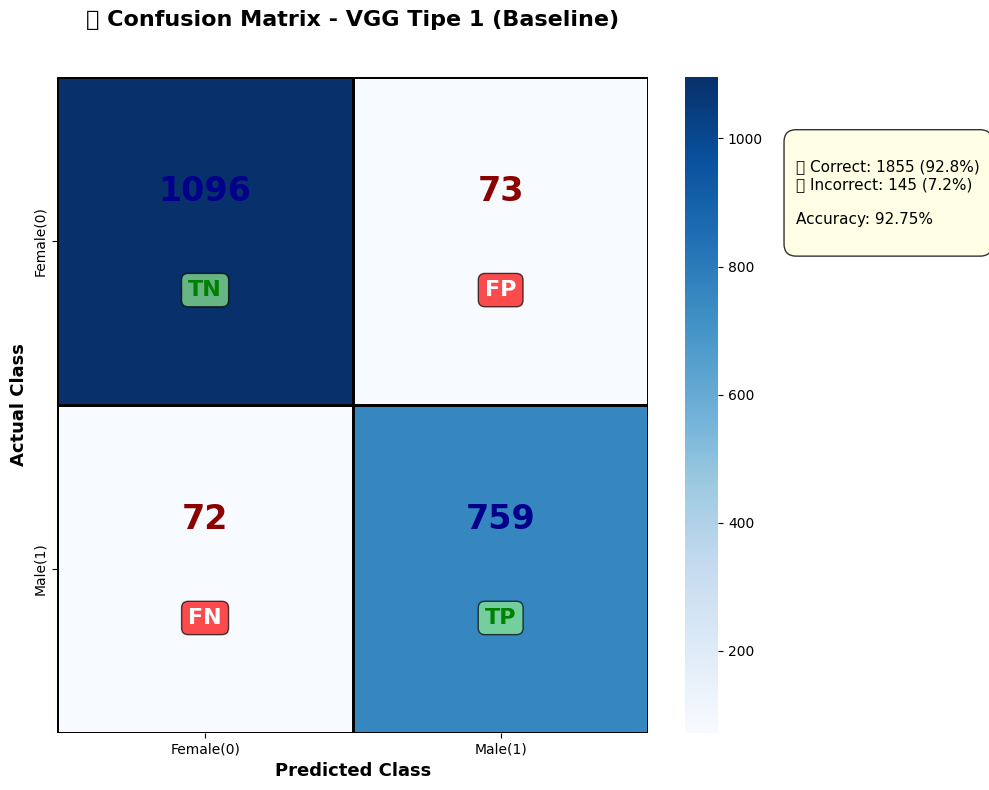


📄 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   Female(0)     0.9384    0.9376    0.9380      1169
     Male(1)     0.9123    0.9134    0.9128       831

    accuracy                         0.9275      2000
   macro avg     0.9253    0.9255    0.9254      2000
weighted avg     0.9275    0.9275    0.9275      2000


💡 INTERPRETASI HASIL:
⚠️  Model cenderung OVER-PREDICT Male
   → 73 Female salah diprediksi sebagai Male
   → 72 Male salah diprediksi sebagai Female

📌 REKOMENDASI:
   - Adjust threshold dari 0.5 ke nilai lebih tinggi (misal 0.6)
   - Tambah data augmentation untuk kelas Female
   - Gunakan class weights saat training

🎯 Overall Accuracy: 92.75%
   → EXCELLENT performance!

✅ Analisis selesai! Hasil disimpan ke variable 'results_type1'


In [33]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("🔍 ANALISIS CONFUSION MATRIX - VGG TIPE 1")
print("="*60)

# ========================================
# 1️⃣ PREDIKSI PADA VALIDATION SET
# ========================================
print("\n📊 Melakukan prediksi pada validation set...")

# Prediksi probabilitas (output sigmoid antara 0 dan 1)
y_pred_proba = model_type1.predict(val_images, verbose=0)

# Convert probabilitas ke binary predictions (threshold = 0.5)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Ground truth labels
y_true = val_labels.astype(int)

print(f"Total prediksi: {len(y_pred)}")
print(f"Shape y_true: {y_true.shape}")
print(f"Shape y_pred: {y_pred.shape}")

# ========================================
# 2️⃣ HITUNG CONFUSION MATRIX
# ========================================
print("\n🔢 Menghitung Confusion Matrix...")

cm = confusion_matrix(y_true, y_pred)

# Extract TP, TN, FP, FN
TN = cm[0, 0]  # True Negative (Female → Female)
FP = cm[0, 1]  # False Positive (Female → Male)
FN = cm[1, 0]  # False Negative (Male → Female)
TP = cm[1, 1]  # True Positive (Male → Male)

total = TN + FP + FN + TP

print("\n" + "="*60)
print("📋 CONFUSION MATRIX - VGG TIPE 1")
print("="*60)
print(f"""
                    PREDICTED
                Female(0)    Male(1)
    ACTUAL
    Female(0)      {TN:4d}        {FP:4d}
    Male(1)        {FN:4d}        {TP:4d}
""")
print("="*60)

# ========================================
# 3️⃣ DETAIL METRIK
# ========================================
print("\n📊 DETAIL METRIK TP, TN, FP, FN:")
print("="*60)
print(f"✅ True Positive  (TP): {TP:4d} ({TP/total*100:5.2f}%)")
print(f"   → Male diprediksi sebagai Male (BENAR)")
print()
print(f"✅ True Negative  (TN): {TN:4d} ({TN/total*100:5.2f}%)")
print(f"   → Female diprediksi sebagai Female (BENAR)")
print()
print(f"❌ False Positive (FP): {FP:4d} ({FP/total*100:5.2f}%)")
print(f"   → Female diprediksi sebagai Male (SALAH - Type I Error)")
print()
print(f"❌ False Negative (FN): {FN:4d} ({FN/total*100:5.2f}%)")
print(f"   → Male diprediksi sebagai Female (SALAH - Type II Error)")
print()
print("-"*60)
print(f"📌 Total Prediksi Benar: {TP + TN:4d} ({(TP+TN)/total*100:5.2f}%)")
print(f"📌 Total Prediksi Salah: {FP + FN:4d} ({(FP+FN)/total*100:5.2f}%)")
print("="*60)

# ========================================
# 4️⃣ HITUNG METRIK TAMBAHAN
# ========================================
print("\n📈 METRIK PERFORMA LANJUTAN:")
print("="*60)

# Accuracy
accuracy = (TP + TN) / total
print(f"Accuracy         : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   → (TP + TN) / Total")
print()

# Precision (Male class)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
print(f"Precision (Male) : {precision:.4f} ({precision*100:.2f}%)")
print(f"   → TP / (TP + FP)")
print(f"   → Dari semua yang diprediksi Male, berapa yang benar?")
print()

# Recall / Sensitivity (Male class)
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
print(f"Recall (Male)    : {recall:.4f} ({recall*100:.2f}%)")
print(f"   → TP / (TP + FN)")
print(f"   → Dari semua Male sebenarnya, berapa yang terdeteksi?")
print()

# Specificity (Female class)
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
print(f"Specificity (Female): {specificity:.4f} ({specificity*100:.2f}%)")
print(f"   → TN / (TN + FP)")
print(f"   → Dari semua Female sebenarnya, berapa yang terdeteksi?")
print()

# F1-Score (Male class)
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"F1-Score (Male)  : {f1:.4f}")
print(f"   → 2 × (Precision × Recall) / (Precision + Recall)")
print(f"   → Balance antara Precision dan Recall")
print()

# Error Rate
error_rate = (FP + FN) / total
print(f"Error Rate       : {error_rate:.4f} ({error_rate*100:.2f}%)")
print(f"   → (FP + FN) / Total")
print("="*60)

# ========================================
# 5️⃣ VISUALISASI CONFUSION MATRIX (1 PLOT AJA)
# ========================================
print("\n🎨 Membuat visualisasi Confusion Matrix...")

plt.figure(figsize=(10, 8))

# Buat heatmap dengan annotasi custom
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=True,
                 xticklabels=['Female(0)', 'Male(1)'],
                 yticklabels=['Female(0)', 'Male(1)'],
                 linewidths=2, linecolor='black')

# Tambahkan angka + label TP/TN/FP/FN di setiap cell
# Cell [0,0] - TN (True Negative)
ax.text(0.5, 0.35, f'{TN}', ha='center', va='center',
        fontsize=24, color='darkblue', weight='bold')
ax.text(0.5, 0.65, 'TN', ha='center', va='center',
        fontsize=16, color='green', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

# Cell [0,1] - FP (False Positive)
ax.text(1.5, 0.35, f'{FP}', ha='center', va='center',
        fontsize=24, color='darkred', weight='bold')
ax.text(1.5, 0.65, 'FP', ha='center', va='center',
        fontsize=16, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))

# Cell [1,0] - FN (False Negative)
ax.text(0.5, 1.35, f'{FN}', ha='center', va='center',
        fontsize=24, color='darkred', weight='bold')
ax.text(0.5, 1.65, 'FN', ha='center', va='center',
        fontsize=16, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))

# Cell [1,1] - TP (True Positive)
ax.text(1.5, 1.35, f'{TP}', ha='center', va='center',
        fontsize=24, color='darkblue', weight='bold')
ax.text(1.5, 1.65, 'TP', ha='center', va='center',
        fontsize=16, color='green', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

plt.title('🔵 Confusion Matrix - VGG Tipe 1 (Baseline)\n',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual Class', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=13, fontweight='bold')

# Tambahkan legend keterangan
legend_text = f"""
✅ Correct: {TP + TN} ({(TP+TN)/total*100:.1f}%)
❌ Incorrect: {FP + FN} ({(FP+FN)/total*100:.1f}%)

Accuracy: {accuracy*100:.2f}%
"""
plt.text(2.5, 0.5, legend_text, fontsize=11,
         bbox=dict(boxstyle='round,pad=0.8', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

# ========================================
# 6️⃣ CLASSIFICATION REPORT
# ========================================
print("\n📄 CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_true, y_pred,
                          target_names=['Female(0)', 'Male(1)'],
                          digits=4))
print("="*60)

# ========================================
# 7️⃣ INTERPRETASI & REKOMENDASI
# ========================================
print("\n💡 INTERPRETASI HASIL:")
print("="*60)

if FP > FN:
    print("⚠️  Model cenderung OVER-PREDICT Male")
    print(f"   → {FP} Female salah diprediksi sebagai Male")
    print(f"   → {FN} Male salah diprediksi sebagai Female")
    print("\n📌 REKOMENDASI:")
    print("   - Adjust threshold dari 0.5 ke nilai lebih tinggi (misal 0.6)")
    print("   - Tambah data augmentation untuk kelas Female")
    print("   - Gunakan class weights saat training")
elif FN > FP:
    print("⚠️  Model cenderung UNDER-PREDICT Male")
    print(f"   → {FN} Male salah diprediksi sebagai Female")
    print(f"   → {FP} Female salah diprediksi sebagai Male")
    print("\n📌 REKOMENDASI:")
    print("   - Adjust threshold dari 0.5 ke nilai lebih rendah (misal 0.4)")
    print("   - Tambah data augmentation untuk kelas Male")
else:
    print("✅ Model balance dalam error distribution")
    print(f"   → FP: {FP}, FN: {FN}")

print()
print(f"🎯 Overall Accuracy: {accuracy*100:.2f}%")
if accuracy > 0.90:
    print("   → EXCELLENT performance!")
elif accuracy > 0.80:
    print("   → GOOD performance!")
elif accuracy > 0.70:
    print("   → FAIR performance - masih bisa ditingkatkan")
else:
    print("   → POOR performance - perlu perbaikan signifikan")

print("="*60)

# ========================================
# 8️⃣ SIMPAN HASIL
# ========================================
results_type1 = {
    'confusion_matrix': cm,
    'TP': TP,
    'TN': TN,
    'FP': FP,
    'FN': FN,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'specificity': specificity,
    'f1_score': f1,
    'error_rate': error_rate
}

print("\n✅ Analisis selesai! Hasil disimpan ke variable 'results_type1'")

## VGG - Tipe 2

### Build Model

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definisi ukuran input (Height, Width, Channels)
input_shape = (64, 64, 3)

print("="*60)
print("🟢 VGG TIPE 2 - OPTIMIZED (Better Convergence)")
print("="*60)
print("Membangun arsitektur VGG-like model...")

# Bangun model VGG menggunakan Sequential API
model_type2 = models.Sequential([

    # === BLOCK 1 ===
    # Conv layer pertama: ekstrak fitur dasar (edges, corners)
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    # Conv layer kedua: pelajari fitur lebih kompleks dari block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    # MaxPooling: ambil fitur paling dominan, kurangi dimensi spatial (64x64 -> 32x32)
    layers.MaxPooling2D((2, 2)),

    # === BLOCK 2 ===
    # Filter ditingkatkan jadi 64 untuk tangkap fitur lebih kompleks
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    # MaxPooling: kurangi dimensi lagi (32x32 -> 16x16)
    layers.MaxPooling2D((2, 2)),

    # === BLOCK 3 ===
    # Filter ditingkatkan jadi 128 untuk fitur high-level
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    # MaxPooling: dimensi akhir (16x16 -> 8x8)
    layers.MaxPooling2D((2, 2)),

    # === FULLY CONNECTED LAYERS ===
    # Flatten: ubah output 3D (8x8x128) menjadi 1D vector (8192 neuron)
    layers.Flatten(),

    # Dense layer: gabungkan semua fitur untuk klasifikasi
    # 512 neuron dengan ReLU activation
    layers.Dense(512, activation='relu'),

    # Dropout: randomly matikan 50% neuron saat training untuk cegah overfitting
    layers.Dropout(0.5),

    # Output layer: 1 neuron untuk binary classification (Male/Female)
    # Sigmoid: output probabilitas antara 0 dan 1
    layers.Dense(1, activation='sigmoid')
])

# Tampilkan arsitektur model
print("\n=== Arsitektur Model VGG Tipe 2 ===")
model_type2.summary()
print(f"\nTotal parameter: {model_type2.count_params():,}")
print("="*60)

🟢 VGG TIPE 2 - OPTIMIZED (Better Convergence)
Membangun arsitektur VGG-like model...

=== Arsitektur Model VGG Tipe 2 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,629,921 (17.66 MB)

 Trainable params: 4,629,921 (17.66 MB)

 Non-trainable params: 0 (0.00 B)


Total parameter: 4,629,921


### Compile Model

In [35]:
from tensorflow.keras.optimizers import Adam

# === KONFIGURASI TIPE 2 ===
config_name = "Optimized - Better Convergence"
learning_rate_type2 = 0.0001  # Learning rate lebih kecil

print("="*60)
print("🟢 COMPILE MODEL - TIPE 2")
print("="*60)
print(f"Konfigurasi: {config_name}")
print(f"Learning Rate: {learning_rate_type2}")
print(f"Optimizer: Adam")
print(f"Loss Function: Binary Crossentropy")
print("="*60)

print("\n📌 REASONING TIPE 2 (Optimized):")
print("-"*60)
print("""
- Learning Rate: 0.0001 (10x lebih kecil dari Tipe 1)
  → Learning rate lebih kecil = fine-tuning lebih halus
  → Mencegah overshoot saat mendekati konvergensi
  → Membantu model tidak "melompat" keluar dari local minima yang bagus
  → Trade-off: butuh epochs lebih banyak untuk konvergen

- Optimizer: Adam
  → Tetap pakai Adam karena terbukti robust
  → Adaptive learning rate membantu dengan LR kecil
  → Kombinasi momentum + adaptive learning

- Loss: Binary Crossentropy
  → Sama dengan Tipe 1, standard untuk binary classification

✅ TUJUAN: Mencari performance maksimal dengan konvergensi lebih halus
""")
print("="*60)

# Compile model
model_type2.compile(
    optimizer=Adam(learning_rate=learning_rate_type2),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model Tipe 2 berhasil dikompilasi!")

🟢 COMPILE MODEL - TIPE 2
Konfigurasi: Optimized - Better Convergence
Learning Rate: 0.0001
Optimizer: Adam
Loss Function: Binary Crossentropy

📌 REASONING TIPE 2 (Optimized):
------------------------------------------------------------

- Learning Rate: 0.0001 (10x lebih kecil dari Tipe 1)
  → Learning rate lebih kecil = fine-tuning lebih halus
  → Mencegah overshoot saat mendekati konvergensi
  → Membantu model tidak "melompat" keluar dari local minima yang bagus
  → Trade-off: butuh epochs lebih banyak untuk konvergen

- Optimizer: Adam
  → Tetap pakai Adam karena terbukti robust
  → Adaptive learning rate membantu dengan LR kecil
  → Kombinasi momentum + adaptive learning

- Loss: Binary Crossentropy
  → Sama dengan Tipe 1, standard untuk binary classification

✅ TUJUAN: Mencari performance maksimal dengan konvergensi lebih halus


✅ Model Tipe 2 berhasil dikompilasi!


### Train Model

In [36]:
import time

# === KONFIGURASI TRAINING TIPE 2 ===
epochs_type2 = 20
batch_size_type2 = 64
learning_rate_type2 = 0.0001
config_name = "Advanced"

print("="*60)
print("🚀 TRAINING VGG - TIPE 2 (ADVANCED)")
print("="*60)
print(f"Konfigurasi: {config_name}")
print("-"*60)
print(f"Epochs: {epochs_type2}")
print(f"Batch Size: {batch_size_type2}")
print(f"Learning Rate: {learning_rate_type2}")
print(f"Dropout Rate: 0.5")
print("-"*60)
print(f"Total training samples: {len(train_images):,}")
print(f"Total validation samples: {len(val_images):,}")
print(f"Steps per epoch: {len(train_images) // batch_size_type2}")
print(f"Total steps: {(len(train_images) // batch_size_type2) * epochs_type2}")
print("="*60)

print("\n📌 REASONING HYPERPARAMETER TIPE 2 (Advanced):")
print("-"*60)
print("""
- Epochs: 20 (2x dari Tipe 1)
  → Lebih banyak iterasi untuk model belajar pattern lebih dalam
  → Memberi kesempatan model untuk konvergen lebih baik
  → Karena LR kecil (0.0001), butuh lebih banyak epochs

- Batch Size: 64 (2x dari Tipe 1)
  → Batch lebih besar = gradient update lebih stabil
  → Mengurangi noise dalam training process
  → Lebih efficient dalam GPU utilization
  → Trade-off: butuh memory lebih besar, update lebih jarang

- Learning Rate: 0.0001 (10x lebih kecil dari Tipe 1)
  → LR kecil untuk konvergensi halus dan stabil
  → Menghindari overshooting di global minima
  → Cocok untuk fine-tuning dan long training
  → Kombinasi dengan epochs banyak untuk optimal convergence

- Dropout: 0.5 (lebih agresif dari Tipe 1)
  → Regularisasi kuat untuk cegah overfitting
  → Karena epochs banyak, prone to overfitting
  → Force model untuk belajar robust features
  → Konsisten dengan V2 pattern (VGG, GoogleNet, AlexNet)

- Kombinasi: LR kecil + Batch besar + Epochs banyak + Dropout tinggi
  → Strategi untuk konvergensi halus dan stabil
  → Mencari global minima lebih optimal
  → Maximum generalization capability

✅ COCOK UNTUK: Production model, maximum accuracy, fine-tuning
""")
print("="*60)

# Catat waktu mulai training
start_time = time.time()

# Train model
history_type2 = model_type2.fit(
    train_images,
    train_labels,
    epochs=epochs_type2,
    batch_size=batch_size_type2,
    validation_data=(val_images, val_labels),
    verbose=1
)

# Hitung durasi training
end_time = time.time()
training_duration_type2 = end_time - start_time

print("\n" + "="*60)
print("✅ TRAINING VGG TIPE 2 SELESAI!")
print("="*60)
print(f"⏱️  Waktu training: {training_duration_type2:.2f} detik ({training_duration_type2/60:.2f} menit)")
print(f"📊 Final Training Accuracy: {history_type2.history['accuracy'][-1]:.4f} ({history_type2.history['accuracy'][-1]*100:.2f}%)")
print(f"📊 Final Validation Accuracy: {history_type2.history['val_accuracy'][-1]:.4f} ({history_type2.history['val_accuracy'][-1]*100:.2f}%)")
print("-"*60)

# Deteksi overfitting
gap = history_type2.history['accuracy'][-1] - history_type2.history['val_accuracy'][-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

🚀 TRAINING VGG - TIPE 2 (ADVANCED)
Konfigurasi: Advanced
------------------------------------------------------------
Epochs: 20
Batch Size: 64
Learning Rate: 0.0001
Dropout Rate: 0.5
------------------------------------------------------------
Total training samples: 8,000
Total validation samples: 2,000
Steps per epoch: 125
Total steps: 2500

📌 REASONING HYPERPARAMETER TIPE 2 (Advanced):
------------------------------------------------------------

- Epochs: 20 (2x dari Tipe 1)
  → Lebih banyak iterasi untuk model belajar pattern lebih dalam
  → Memberi kesempatan model untuk konvergen lebih baik
  → Karena LR kecil (0.0001), butuh lebih banyak epochs

- Batch Size: 64 (2x dari Tipe 1)
  → Batch lebih besar = gradient update lebih stabil
  → Mengurangi noise dalam training process
  → Lebih efficient dalam GPU utilization
  → Trade-off: butuh memory lebih besar, update lebih jarang

- Learning Rate: 0.0001 (10x lebih kecil dari Tipe 1)
  → LR kecil untuk konvergensi halus dan stabil


### Plot Training History

/tmp/ipython-input-3892232355.py:33: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


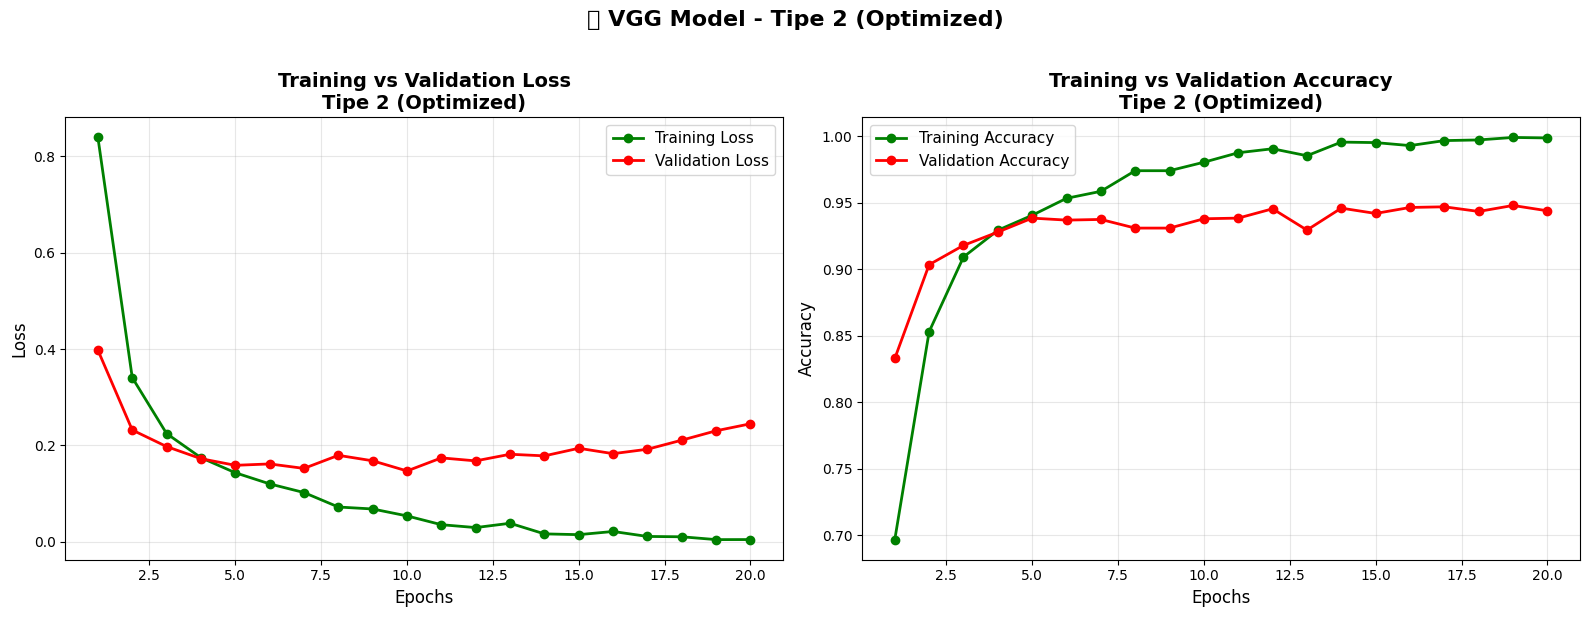


📊 SUMMARY HASIL TRAINING - TIPE 2
Epochs: 20 | Batch Size: 64 | LR: 0.0001
------------------------------------------------------------
Final Training Loss      : 0.0049
Final Training Accuracy  : 0.9987 (99.87%)
Final Validation Loss    : 0.2450
Final Validation Accuracy: 0.9440 (94.40%)
Training Duration        : 77.29s (1.29 min)
------------------------------------------------------------
✅ Model balance - tidak ada overfitting/underfitting signifikan


In [37]:
import matplotlib.pyplot as plt

# Ambil data history dari training
loss_values_type2 = history_type2.history['loss']
val_loss_values_type2 = history_type2.history['val_loss']
accuracy_values_type2 = history_type2.history['accuracy']
val_accuracy_values_type2 = history_type2.history['val_accuracy']

epochs_range = range(1, len(loss_values_type2) + 1)

# Buat figure dengan 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Loss
axes[0].plot(epochs_range, loss_values_type2, 'go-', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(epochs_range, val_loss_values_type2, 'ro-', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_title('Training vs Validation Loss\nTipe 2 (Optimized)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Subplot 2: Accuracy
axes[1].plot(epochs_range, accuracy_values_type2, 'go-', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].plot(epochs_range, val_accuracy_values_type2, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
axes[1].set_title('Training vs Validation Accuracy\nTipe 2 (Optimized)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('🟢 VGG Model - Tipe 2 (Optimized)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tampilkan summary hasil training
print("\n" + "="*60)
print("📊 SUMMARY HASIL TRAINING - TIPE 2")
print("="*60)
print(f"Epochs: {epochs_type2} | Batch Size: {batch_size_type2} | LR: {learning_rate_type2}")
print("-"*60)
print(f"Final Training Loss      : {loss_values_type2[-1]:.4f}")
print(f"Final Training Accuracy  : {accuracy_values_type2[-1]:.4f} ({accuracy_values_type2[-1]*100:.2f}%)")
print(f"Final Validation Loss    : {val_loss_values_type2[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy_values_type2[-1]:.4f} ({val_accuracy_values_type2[-1]*100:.2f}%)")
print(f"Training Duration        : {training_duration_type2:.2f}s ({training_duration_type2/60:.2f} min)")
print("-"*60)

# Deteksi overfitting
gap = accuracy_values_type2[-1] - val_accuracy_values_type2[-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

### Evaluate Model

In [38]:
print("="*60)
print("📈 EVALUASI MODEL - TIPE 2")
print("="*60)

# Evaluate pada validation set
loss_type2, accuracy_type2 = model_type2.evaluate(val_images, val_labels, verbose=1)

print("\n" + "="*60)
print("📊 HASIL EVALUASI FINAL - TIPE 2")
print("="*60)
print(f"Validation Loss    : {loss_type2:.4f}")
print(f"Validation Accuracy: {accuracy_type2:.4f} ({accuracy_type2*100:.2f}%)")
print("="*60)

# Interpretasi hasil
if accuracy_type2 > 0.85:
    print("\n✅ Model Tipe 2 memiliki performa BAIK!")
elif accuracy_type2 > 0.75:
    print("\n⚠️  Model Tipe 2 cukup baik, masih bisa ditingkatkan.")
else:
    print("\n❌ Model Tipe 2 perlu perbaikan.")

📈 EVALUASI MODEL - TIPE 2
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9358 - loss: 0.2977

📊 HASIL EVALUASI FINAL - TIPE 2
Validation Loss    : 0.2450
Validation Accuracy: 0.9440 (94.40%)

✅ Model Tipe 2 memiliki performa BAIK!


### Confusion Matrix & Classification Report

🔍 ANALISIS CONFUSION MATRIX - VGG TIPE 2

📊 Melakukan prediksi pada validation set...
Total prediksi: 2000
Shape y_true: (2000,)
Shape y_pred: (2000,)

🔢 Menghitung Confusion Matrix...

📋 CONFUSION MATRIX - VGG TIPE 2

                    PREDICTED
                Female(0)    Male(1)
    ACTUAL
    Female(0)      1086          83
    Male(1)          29         802


📊 DETAIL METRIK TP, TN, FP, FN:
✅ True Positive  (TP):  802 (40.10%)
   → Male diprediksi sebagai Male (BENAR)

✅ True Negative  (TN): 1086 (54.30%)
   → Female diprediksi sebagai Female (BENAR)

❌ False Positive (FP):   83 ( 4.15%)
   → Female diprediksi sebagai Male (SALAH - Type I Error)

❌ False Negative (FN):   29 ( 1.45%)
   → Male diprediksi sebagai Female (SALAH - Type II Error)

------------------------------------------------------------
📌 Total Prediksi Benar: 1888 (94.40%)
📌 Total Prediksi Salah:  112 ( 5.60%)

📈 METRIK PERFORMA LANJUTAN:
Accuracy         : 0.9440 (94.40%)
   → (TP + TN) / Total

Precision (Ma

/tmp/ipython-input-764226598.py:180: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-764226598.py:180: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-764226598.py:180: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_

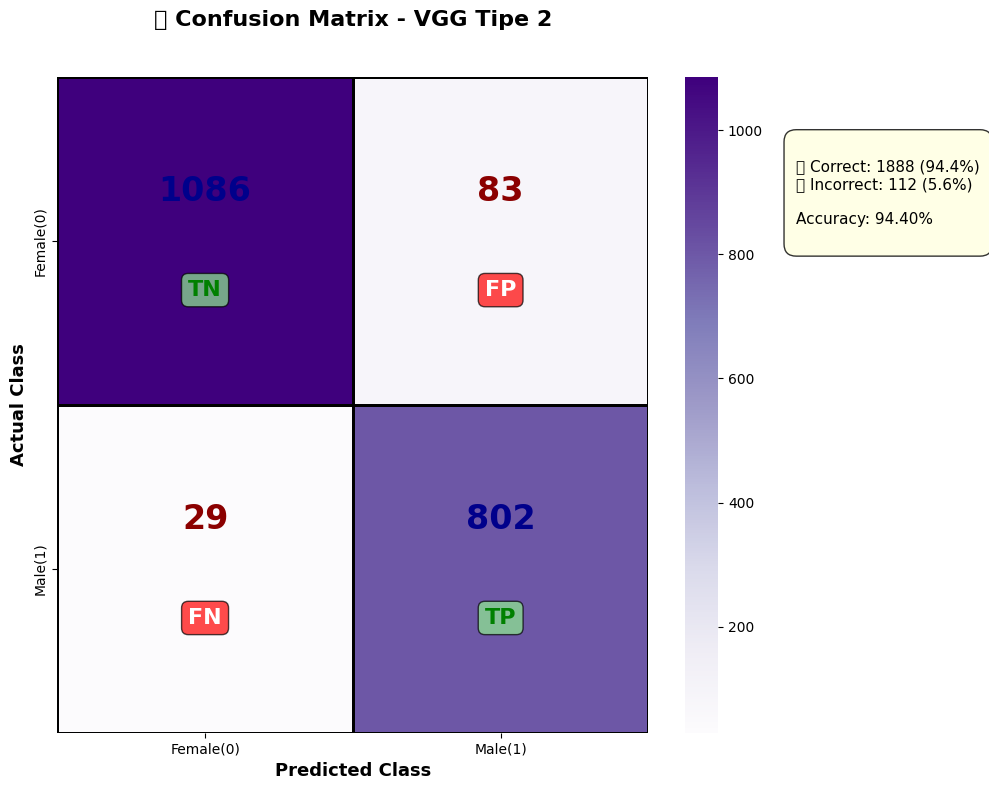


📄 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   Female(0)     0.9740    0.9290    0.9510      1169
     Male(1)     0.9062    0.9651    0.9347       831

    accuracy                         0.9440      2000
   macro avg     0.9401    0.9471    0.9428      2000
weighted avg     0.9458    0.9440    0.9442      2000


💡 INTERPRETASI HASIL:
⚠️  Model cenderung OVER-PREDICT Male
   → 83 Female salah diprediksi sebagai Male
   → 29 Male salah diprediksi sebagai Female

📌 REKOMENDASI:
   - Adjust threshold dari 0.5 ke nilai lebih tinggi (misal 0.6)
   - Tambah data augmentation untuk kelas Female
   - Gunakan class weights saat training

🎯 Overall Accuracy: 94.40%
   → EXCELLENT performance!

✅ Analisis VGG Tipe 2 selesai! Hasil disimpan ke 'results_type2'


In [39]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("🔍 ANALISIS CONFUSION MATRIX - VGG TIPE 2")
print("="*60)

# ========================================
# 1️⃣ PREDIKSI PADA VALIDATION SET
# ========================================
print("\n📊 Melakukan prediksi pada validation set...")

# Prediksi probabilitas (output sigmoid antara 0 dan 1)
y_pred_proba_type2 = model_type2.predict(val_images, verbose=0)

# Convert probabilitas ke binary predictions (threshold = 0.5)
y_pred_type2 = (y_pred_proba_type2 > 0.5).astype(int).flatten()

# Ground truth labels
y_true = val_labels.astype(int)

print(f"Total prediksi: {len(y_pred_type2)}")
print(f"Shape y_true: {y_true.shape}")
print(f"Shape y_pred: {y_pred_type2.shape}")

# ========================================
# 2️⃣ HITUNG CONFUSION MATRIX
# ========================================
print("\n🔢 Menghitung Confusion Matrix...")

cm_type2 = confusion_matrix(y_true, y_pred_type2)

# Extract TP, TN, FP, FN
TN_type2 = cm_type2[0, 0]  # True Negative (Female → Female)
FP_type2 = cm_type2[0, 1]  # False Positive (Female → Male)
FN_type2 = cm_type2[1, 0]  # False Negative (Male → Female)
TP_type2 = cm_type2[1, 1]  # True Positive (Male → Male)

total_type2 = TN_type2 + FP_type2 + FN_type2 + TP_type2

print("\n" + "="*60)
print("📋 CONFUSION MATRIX - VGG TIPE 2")
print("="*60)
print(f"""
                    PREDICTED
                Female(0)    Male(1)
    ACTUAL
    Female(0)      {TN_type2:4d}        {FP_type2:4d}
    Male(1)        {FN_type2:4d}        {TP_type2:4d}
""")
print("="*60)

# ========================================
# 3️⃣ DETAIL METRIK
# ========================================
print("\n📊 DETAIL METRIK TP, TN, FP, FN:")
print("="*60)
print(f"✅ True Positive  (TP): {TP_type2:4d} ({TP_type2/total_type2*100:5.2f}%)")
print(f"   → Male diprediksi sebagai Male (BENAR)")
print()
print(f"✅ True Negative  (TN): {TN_type2:4d} ({TN_type2/total_type2*100:5.2f}%)")
print(f"   → Female diprediksi sebagai Female (BENAR)")
print()
print(f"❌ False Positive (FP): {FP_type2:4d} ({FP_type2/total_type2*100:5.2f}%)")
print(f"   → Female diprediksi sebagai Male (SALAH - Type I Error)")
print()
print(f"❌ False Negative (FN): {FN_type2:4d} ({FN_type2/total_type2*100:5.2f}%)")
print(f"   → Male diprediksi sebagai Female (SALAH - Type II Error)")
print()
print("-"*60)
print(f"📌 Total Prediksi Benar: {TP_type2 + TN_type2:4d} ({(TP_type2+TN_type2)/total_type2*100:5.2f}%)")
print(f"📌 Total Prediksi Salah: {FP_type2 + FN_type2:4d} ({(FP_type2+FN_type2)/total_type2*100:5.2f}%)")
print("="*60)

# ========================================
# 4️⃣ HITUNG METRIK TAMBAHAN
# ========================================
print("\n📈 METRIK PERFORMA LANJUTAN:")
print("="*60)

# Accuracy
accuracy_type2 = (TP_type2 + TN_type2) / total_type2
print(f"Accuracy         : {accuracy_type2:.4f} ({accuracy_type2*100:.2f}%)")
print(f"   → (TP + TN) / Total")
print()

# Precision (Male class)
precision_type2 = TP_type2 / (TP_type2 + FP_type2) if (TP_type2 + FP_type2) > 0 else 0
print(f"Precision (Male) : {precision_type2:.4f} ({precision_type2*100:.2f}%)")
print(f"   → TP / (TP + FP)")
print(f"   → Dari semua yang diprediksi Male, berapa yang benar?")
print()

# Recall / Sensitivity (Male class)
recall_type2 = TP_type2 / (TP_type2 + FN_type2) if (TP_type2 + FN_type2) > 0 else 0
print(f"Recall (Male)    : {recall_type2:.4f} ({recall_type2*100:.2f}%)")
print(f"   → TP / (TP + FN)")
print(f"   → Dari semua Male sebenarnya, berapa yang terdeteksi?")
print()

# Specificity (Female class)
specificity_type2 = TN_type2 / (TN_type2 + FP_type2) if (TN_type2 + FP_type2) > 0 else 0
print(f"Specificity (Female): {specificity_type2:.4f} ({specificity_type2*100:.2f}%)")
print(f"   → TN / (TN + FP)")
print(f"   → Dari semua Female sebenarnya, berapa yang terdeteksi?")
print()

# F1-Score (Male class)
f1_type2 = 2 * (precision_type2 * recall_type2) / (precision_type2 + recall_type2) if (precision_type2 + recall_type2) > 0 else 0
print(f"F1-Score (Male)  : {f1_type2:.4f}")
print(f"   → 2 × (Precision × Recall) / (Precision + Recall)")
print(f"   → Balance antara Precision dan Recall")
print()

# Error Rate
error_rate_type2 = (FP_type2 + FN_type2) / total_type2
print(f"Error Rate       : {error_rate_type2:.4f} ({error_rate_type2*100:.2f}%)")
print(f"   → (FP + FN) / Total")
print("="*60)

# ========================================
# 5️⃣ VISUALISASI CONFUSION MATRIX (1 PLOT AJA)
# ========================================
print("\n🎨 Membuat visualisasi Confusion Matrix...")

plt.figure(figsize=(10, 8))

# Buat heatmap dengan annotasi custom
ax = sns.heatmap(cm_type2, annot=False, fmt='d', cmap='Purples', cbar=True,
                 xticklabels=['Female(0)', 'Male(1)'],
                 yticklabels=['Female(0)', 'Male(1)'],
                 linewidths=2, linecolor='black')

# Tambahkan angka + label TP/TN/FP/FN di setiap cell
# Cell [0,0] - TN (True Negative)
ax.text(0.5, 0.35, f'{TN_type2}', ha='center', va='center',
        fontsize=24, color='darkblue', weight='bold')
ax.text(0.5, 0.65, 'TN', ha='center', va='center',
        fontsize=16, color='green', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

# Cell [0,1] - FP (False Positive)
ax.text(1.5, 0.35, f'{FP_type2}', ha='center', va='center',
        fontsize=24, color='darkred', weight='bold')
ax.text(1.5, 0.65, 'FP', ha='center', va='center',
        fontsize=16, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))

# Cell [1,0] - FN (False Negative)
ax.text(0.5, 1.35, f'{FN_type2}', ha='center', va='center',
        fontsize=24, color='darkred', weight='bold')
ax.text(0.5, 1.65, 'FN', ha='center', va='center',
        fontsize=16, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))

# Cell [1,1] - TP (True Positive)
ax.text(1.5, 1.35, f'{TP_type2}', ha='center', va='center',
        fontsize=24, color='darkblue', weight='bold')
ax.text(1.5, 1.65, 'TP', ha='center', va='center',
        fontsize=16, color='green', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

plt.title('🔵 Confusion Matrix - VGG Tipe 2\n',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual Class', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=13, fontweight='bold')

# Tambahkan legend keterangan
legend_text = f"""
✅ Correct: {TP_type2 + TN_type2} ({(TP_type2+TN_type2)/total_type2*100:.1f}%)
❌ Incorrect: {FP_type2 + FN_type2} ({(FP_type2+FN_type2)/total_type2*100:.1f}%)

Accuracy: {accuracy_type2*100:.2f}%
"""
plt.text(2.5, 0.5, legend_text, fontsize=11,
         bbox=dict(boxstyle='round,pad=0.8', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

# ========================================
# 6️⃣ CLASSIFICATION REPORT
# ========================================
print("\n📄 CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_true, y_pred_type2,
                          target_names=['Female(0)', 'Male(1)'],
                          digits=4))
print("="*60)

# ========================================
# 7️⃣ INTERPRETASI & REKOMENDASI
# ========================================
print("\n💡 INTERPRETASI HASIL:")
print("="*60)

if FP_type2 > FN_type2:
    print("⚠️  Model cenderung OVER-PREDICT Male")
    print(f"   → {FP_type2} Female salah diprediksi sebagai Male")
    print(f"   → {FN_type2} Male salah diprediksi sebagai Female")
    print("\n📌 REKOMENDASI:")
    print("   - Adjust threshold dari 0.5 ke nilai lebih tinggi (misal 0.6)")
    print("   - Tambah data augmentation untuk kelas Female")
    print("   - Gunakan class weights saat training")
elif FN_type2 > FP_type2:
    print("⚠️  Model cenderung UNDER-PREDICT Male")
    print(f"   → {FN_type2} Male salah diprediksi sebagai Female")
    print(f"   → {FP_type2} Female salah diprediksi sebagai Male")
    print("\n📌 REKOMENDASI:")
    print("   - Adjust threshold dari 0.5 ke nilai lebih rendah (misal 0.4)")
    print("   - Tambah data augmentation untuk kelas Male")
else:
    print("✅ Model balance dalam error distribution")
    print(f"   → FP: {FP_type2}, FN: {FN_type2}")

print()
print(f"🎯 Overall Accuracy: {accuracy_type2*100:.2f}%")
if accuracy_type2 > 0.90:
    print("   → EXCELLENT performance!")
elif accuracy_type2 > 0.80:
    print("   → GOOD performance!")
elif accuracy_type2 > 0.70:
    print("   → FAIR performance - masih bisa ditingkatkan")
else:
    print("   → POOR performance - perlu perbaikan signifikan")

print("="*60)

# ========================================
# 8️⃣ SIMPAN HASIL
# ========================================
results_type2 = {
    'confusion_matrix': cm_type2,
    'TP': TP_type2,
    'TN': TN_type2,
    'FP': FP_type2,
    'FN': FN_type2,
    'accuracy': accuracy_type2,
    'precision': precision_type2,
    'recall': recall_type2,
    'specificity': specificity_type2,
    'f1_score': f1_type2,
    'error_rate': error_rate_type2
}

print("\n✅ Analisis VGG Tipe 2 selesai! Hasil disimpan ke 'results_type2'")

## Test (V1 + V2)

🔵🟢 TEST PREDIKSI - KEDUA MODEL SEKALIGUS
Upload gambar sekali, test di Model Tipe 1 & Tipe 2
------------------------------------------------------------


Saving LUCINTA.webp to LUCINTA (1).webp

📷 Memproses gambar: "LUCINTA (1).webp"
Ukuran file: 6,030 bytes

📊 HASIL PREDIKSI UNTUK: LUCINTA (1).webp
🔵 MODEL TIPE 1 (Baseline):
   Prediksi: Male
   Prob Male: 0.5976 (59.76%)
   Confidence: 0.5976 (59.76%)

🟢 MODEL TIPE 2 (Optimized):
   Prediksi: Male
   Prob Male: 0.5014 (50.14%)
   Confidence: 0.5014 (50.14%)

✅ KEDUA MODEL SEPAKAT: Male


/tmp/ipython-input-911366017.py:135: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-911366017.py:135: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


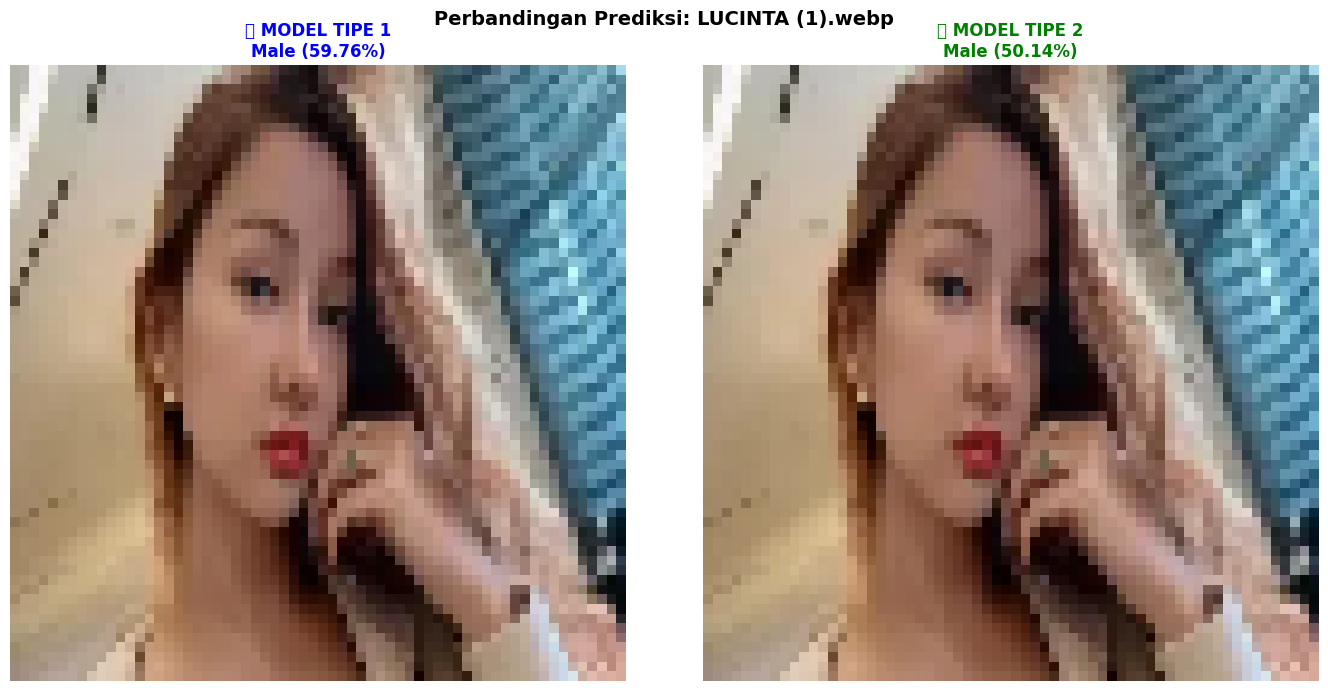


✅ Prediksi kedua model selesai!


In [41]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("="*60)
print("🔵🟢 TEST PREDIKSI - KEDUA MODEL SEKALIGUS")
print("="*60)
print("Upload gambar sekali, test di Model Tipe 1 & Tipe 2")
print("-"*60)

# Upload gambar dari komputer lokal
uploaded = files.upload()

# Simpan hasil prediksi untuk perbandingan
predictions_comparison = []

# Proses setiap gambar yang diupload
for fn in uploaded.keys():
    print(f'\n{"="*60}')
    print(f'📷 Memproses gambar: "{fn}"')
    print(f'Ukuran file: {len(uploaded[fn]):,} bytes')
    print(f'{"="*60}')

    # Baca gambar
    image_path = fn
    img = cv2.imread(image_path)

    if img is None:
        print(f"❌ Error: Tidak dapat membaca gambar {image_path}")
        continue

    # === PREPROCESSING (SAMA DENGAN TRAINING) ===

    # 1. Resize ke ukuran input model (64x64)
    target_size = (64, 64)
    img_resized = cv2.resize(img, target_size)

    # 2. Konversi BGR (OpenCV) ke RGB (sesuai training)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # 3. Normalisasi: ubah range piksel dari [0, 255] ke [0, 1]
    img_normalized = img_rgb.astype('float32') / 255.0

    # 4. Tambah dimensi batch: (64, 64, 3) -> (1, 64, 64, 3)
    img_input = np.expand_dims(img_normalized, axis=0)

    # === PREDIKSI DENGAN KEDUA MODEL ===
    results = {}

    # Prediksi Model Tipe 1
    if 'model_type1' in globals():
        pred1 = model_type1.predict(img_input, verbose=0)
        prob_male_1 = pred1[0][0]
        class_1 = "Male" if prob_male_1 > 0.5 else "Female"
        conf_1 = prob_male_1 if prob_male_1 > 0.5 else (1 - prob_male_1)
        results['type1'] = {
            'prob_male': prob_male_1,
            'class': class_1,
            'confidence': conf_1
        }
    else:
        print("⚠️  Model Tipe 1 tidak ditemukan, skip prediksi Tipe 1")

    # Prediksi Model Tipe 2
    if 'model_type2' in globals():
        pred2 = model_type2.predict(img_input, verbose=0)
        prob_male_2 = pred2[0][0]
        class_2 = "Male" if prob_male_2 > 0.5 else "Female"
        conf_2 = prob_male_2 if prob_male_2 > 0.5 else (1 - prob_male_2)
        results['type2'] = {
            'prob_male': prob_male_2,
            'class': class_2,
            'confidence': conf_2
        }
    else:
        print("⚠️  Model Tipe 2 tidak ditemukan, skip prediksi Tipe 2")

    # Simpan hasil untuk tabel perbandingan
    if 'type1' in results and 'type2' in results:
        predictions_comparison.append({
            'filename': fn,
            'type1_prob_male': results['type1']['prob_male'],
            'type1_class': results['type1']['class'],
            'type1_conf': results['type1']['confidence'],
            'type2_prob_male': results['type2']['prob_male'],
            'type2_class': results['type2']['class'],
            'type2_conf': results['type2']['confidence']
        })

    # === TAMPILKAN HASIL SIDE-BY-SIDE ===
    print(f"\n📊 HASIL PREDIKSI UNTUK: {fn}")
    print(f"="*60)

    if 'type1' in results:
        print(f"🔵 MODEL TIPE 1 (Baseline):")
        print(f"   Prediksi: {results['type1']['class']}")
        print(f"   Prob Male: {results['type1']['prob_male']:.4f} ({results['type1']['prob_male']*100:.2f}%)")
        print(f"   Confidence: {results['type1']['confidence']:.4f} ({results['type1']['confidence']*100:.2f}%)")

    if 'type2' in results:
        print(f"\n🟢 MODEL TIPE 2 (Optimized):")
        print(f"   Prediksi: {results['type2']['class']}")
        print(f"   Prob Male: {results['type2']['prob_male']:.4f} ({results['type2']['prob_male']*100:.2f}%)")
        print(f"   Confidence: {results['type2']['confidence']:.4f} ({results['type2']['confidence']*100:.2f}%)")

    # Cek apakah prediksi sama atau beda
    if 'type1' in results and 'type2' in results:
        if results['type1']['class'] == results['type2']['class']:
            print(f"\n✅ KEDUA MODEL SEPAKAT: {results['type1']['class']}")
        else:
            print(f"\n⚠️  PREDIKSI BERBEDA!")
            print(f"   Tipe 1: {results['type1']['class']} ({results['type1']['confidence']*100:.2f}%)")
            print(f"   Tipe 2: {results['type2']['class']} ({results['type2']['confidence']*100:.2f}%)")

    print(f"="*60)

    # === VISUALISASI SIDE-BY-SIDE ===
    if 'type1' in results and 'type2' in results:
        fig, axes = plt.subplots(1, 2, figsize=(14, 7))

        # Model Tipe 1
        axes[0].imshow(img_rgb)
        axes[0].set_title(f"🔵 MODEL TIPE 1\n{results['type1']['class']} ({results['type1']['confidence']*100:.2f}%)",
                          fontsize=12, fontweight='bold', color='blue')
        axes[0].axis('off')

        # Model Tipe 2
        axes[1].imshow(img_rgb)
        axes[1].set_title(f"🟢 MODEL TIPE 2\n{results['type2']['class']} ({results['type2']['confidence']*100:.2f}%)",
                          fontsize=12, fontweight='bold', color='green')
        axes[1].axis('off')

        plt.suptitle(f"Perbandingan Prediksi: {fn}", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

print("\n" + "="*60)
print("✅ Prediksi kedua model selesai!")
print("="*60)

# GoogleNet

## Setup Kaggle di Colab

In [42]:
# Install Kaggle
!pip install kaggle -q
import os
import sys

# Buat direktori .kaggle jika belum ada
!mkdir -p ~/.kaggle

# Cek apakah file kaggle.json sudah diupload
if os.path.exists('/content/kaggle.json'):
    # Pindahkan kaggle.json ke direktori .kaggle
    !mv /content/kaggle.json ~/.kaggle/
    # Set permission file agar secure
    !chmod 600 ~/.kaggle/kaggle.json
    print("kaggle.json berhasil dikonfigurasi.")
else:
    print("kaggle.json tidak ditemukan di /content/. Silakan upload file kaggle.json terlebih dahulu.")

kaggle.json tidak ditemukan di /content/. Silakan upload file kaggle.json terlebih dahulu.


## Download Dataset dari Kaggle

In [43]:
# Download dataset CelebA 64x64 dari Kaggle
!kaggle datasets download -d therealcyberlord/50k-celeba-dataset-64x64

Dataset URL: https://www.kaggle.com/datasets/therealcyberlord/50k-celeba-dataset-64x64
License(s): unknown
50k-celeba-dataset-64x64.zip: Skipping, found more recently modified local copy (use --force to force download)


## Extract Dataset

In [44]:
import zipfile
import os

# Path file zip yang telah didownload
zip_file_path = '/content/50k-celeba-dataset-64x64.zip'

# Direktori tujuan ekstraksi
extracted_path = '/content/celeba_dataset_kaggle/'

# Buat folder ekstraksi jika belum ada
os.makedirs(extracted_path, exist_ok=True)

# Ekstrak file zip
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print("Dataset berhasil diekstrak.")
except FileNotFoundError:
    print(f"Error: File {zip_file_path} tidak ditemukan. Pastikan download berhasil.")
except zipfile.BadZipFile:
    print(f"Error: File {zip_file_path} bukan zip yang valid. Download mungkin corrupt.")
except Exception as e:
    print(f"Error saat ekstraksi: {e}")

Dataset berhasil diekstrak.


## Cek Isi Folder

In [45]:
import os

# Tampilkan isi direktori hasil ekstraksi
extracted_path = '/content/celeba_dataset_kaggle/'
print("Isi folder ekstraksi:")
print(os.listdir(extracted_path))

Isi folder ekstraksi:
['50k']


## Download Attribute File (Label)

In [46]:
# Download file atribut dari GitHub (alternatif jika gagal)
# Opsional: Bisa juga download manual dari Google Drive
# Link Google Drive: https://drive.google.com/drive/folders/1AA21MR8GeQdnOVgmNcbxCrbAjL1udj0l

import requests
import os

# URL file atribut CelebA
attribute_file_url = "https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt"
attribute_file_path = "/content/list_attr_celeba.txt"

print(f"Mencoba download file atribut dari: {attribute_file_url}")

try:
    response = requests.get(attribute_file_url, stream=True)
    response.raise_for_status()  # Raise error jika status 4xx atau 5xx

    with open(attribute_file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"File atribut berhasil didownload ke: {attribute_file_path}")

except requests.exceptions.RequestException as e:
    print(f"Error saat download file atribut: {e}")
    print("Tidak dapat mendownload file dari URL yang diberikan.")
    print("Silakan download manual dari Google Drive dan upload ke Colab.")
except Exception as e:
    print(f"Error saat memproses file atribut: {e}")

Mencoba download file atribut dari: https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt
Error saat download file atribut: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt
Tidak dapat mendownload file dari URL yang diberikan.
Silakan download manual dari Google Drive dan upload ke Colab.


## Load Gambar ke Numpy

In [47]:
import os
import cv2
import numpy as np

# Direktori tempat gambar hasil ekstraksi
image_dir = '/content/celeba_dataset_kaggle/50k'

# Ukuran target gambar (dataset sudah 64x64)
image_size = (64, 64)

# List semua file gambar (format .jpg atau .png)
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]

# Batasi jumlah gambar untuk eksperimen awal (opsional)
# Bisa dihapus atau diubah untuk load seluruh dataset
num_images_to_load = 10000  # Load 10,000 gambar
image_files = image_files[:num_images_to_load]

print(f"Memulai loading {len(image_files)} gambar...")

# Load dan preprocess gambar
images = []
for idx, file_name in enumerate(image_files):
    img_path = os.path.join(image_dir, file_name)
    img = cv2.imread(img_path)

    if img is not None:
        # Konversi dari BGR (OpenCV default) ke RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize jika ukuran tidak sesuai (meskipun dataset sudah 64x64)
        if img.shape[:2] != image_size:
            img = cv2.resize(img, image_size)

        images.append(img)
    else:
        print(f"Warning: Tidak dapat membaca gambar {img_path}")

    # Progress indicator setiap 1000 gambar
    if (idx + 1) % 1000 == 0:
        print(f"Progress: {idx + 1}/{len(image_files)} gambar diload")

# Konversi list ke NumPy array
images = np.array(images)

print(f"\n{'='*60}")
print("✅ BERHASIL LOAD GAMBAR")
print(f"{'='*60}")
print(f"Total gambar diload: {len(images)}")
print(f"Shape array gambar: {images.shape}")
print(f"Tipe data: {images.dtype}")
print(f"Range nilai piksel: [{images.min()}, {images.max()}]")
print(f"Variabel 'image_files' tersimpan: {len(image_files)} filenames")
print(f"{'='*60}")

Memulai loading 10000 gambar...
Progress: 1000/10000 gambar diload
Progress: 2000/10000 gambar diload
Progress: 3000/10000 gambar diload
Progress: 4000/10000 gambar diload
Progress: 5000/10000 gambar diload
Progress: 6000/10000 gambar diload
Progress: 7000/10000 gambar diload
Progress: 8000/10000 gambar diload
Progress: 9000/10000 gambar diload
Progress: 10000/10000 gambar diload

✅ BERHASIL LOAD GAMBAR
Total gambar diload: 10000
Shape array gambar: (10000, 64, 64, 3)
Tipe data: uint8
Range nilai piksel: [0, 255]
Variabel 'image_files' tersimpan: 10000 filenames


## Load Attribute File

In [48]:
import pandas as pd
import numpy as np
import os

# Path file atribut yang sudah diupload
attribute_file_path = '/content/list_attr_celeba.txt'

print("Memulai loading file atribut...")
print(f"{'='*60}")

if os.path.exists(attribute_file_path):
    print(f"✅ File atribut ditemukan di: {attribute_file_path}")

    # Load file atribut CelebA
    # Format: baris pertama = jumlah data, baris kedua = nama kolom
    # Skip 1 baris pertama, gunakan regex untuk separator (bisa multiple spaces)
    attributes_df = pd.read_csv(attribute_file_path, sep=r'\s+', skiprows=1)

    # Tampilkan 5 baris pertama untuk verifikasi
    print("\n📋 Preview Data Atribut:")
    display(attributes_df.head())

    # Pastikan variabel 'image_files' sudah ada dari step sebelumnya (load gambar)
    if 'image_files' in globals():
        print(f"\n✅ Variabel 'image_files' ditemukan ({len(image_files)} files)")

        # Ambil nama file gambar yang sudah diload (tanpa path)
        loaded_image_filenames = [os.path.basename(f) for f in image_files]

        # Pastikan index dataframe bertipe string untuk matching dengan filename
        attributes_df.index = attributes_df.index.astype(str)

        # Ambil kolom 'Male' sebagai label
        # Nilai: -1 = Female, 1 = Male
        if 'Male' in attributes_df.columns:
            # Reindex untuk mencocokkan urutan gambar yang diload
            loaded_attributes = attributes_df.reindex(loaded_image_filenames)

            # Ekstrak kolom 'Male' dan konversi -1 menjadi 0 (Female=0, Male=1)
            # Handle NaN values dengan fillna(-1) jika ada gambar tanpa label
            male_labels = loaded_attributes['Male'].fillna(-1).replace(-1, 0).values

            # Cek apakah jumlah label cocok dengan jumlah gambar
            if len(male_labels) != len(images):
                print(f"\n⚠️ Peringatan: Jumlah label ({len(male_labels)}) tidak cocok dengan jumlah gambar ({len(images)}).")
                print("Mungkin ada gambar yang tidak memiliki label.")

            print(f"\n{'='*60}")
            print("✅ BERHASIL LOAD LABEL")
            print(f"{'='*60}")
            print(f"Total label diload: {len(male_labels)}")
            print(f"Shape array label: {male_labels.shape}")
            print(f"Contoh 10 label pertama: {male_labels[:10]}")
            print(f"Distribusi: Female={int((male_labels == 0).sum())}, Male={int((male_labels == 1).sum())}")
            print(f"{'='*60}")

        else:
            print("❌ Kolom 'Male' tidak ditemukan dalam file atribut.")
            male_labels = None

    else:
        print("\n❌ Error: Variabel 'image_files' tidak ditemukan.")
        print("⚠️ PASTIKAN SUDAH MENJALANKAN STEP 6 (Load Gambar) TERLEBIH DAHULU!")
        attributes_df = None
        male_labels = None

else:
    print(f"❌ File atribut ({attribute_file_path}) tidak ditemukan.")
    print("📥 Silakan upload file 'list_attr_celeba.txt' ke direktori /content/")
    print("   Download dari: https://drive.google.com/drive/folders/1AA21MR8GeQdnOVgmNcbxCrbAjL1udj0l")
    male_labels = None

# Validasi akhir: set male_labels ke None jika ada masalah
if 'male_labels' in locals() and male_labels is not None and 'images' in globals() and len(male_labels) == len(images):
    print("\n✅ Data gambar dan label siap digunakan!")
else:
    if 'male_labels' not in locals() or male_labels is None:
        print("\n❌ Gagal load label. Setting male_labels = None.")
        male_labels = None
    elif 'images' not in globals():
        print("\n❌ Variabel 'images' tidak ditemukan. Jalankan Step 6 terlebih dahulu.")
        male_labels = None
    elif len(male_labels) != len(images):
        print(f"\n❌ Jumlah tidak cocok (images: {len(images)}, labels: {len(male_labels)}). Setting male_labels = None.")
        male_labels = None

Memulai loading file atribut...
✅ File atribut ditemukan di: /content/list_attr_celeba.txt

📋 Preview Data Atribut:


,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1



✅ Variabel 'image_files' ditemukan (10000 files)

✅ BERHASIL LOAD LABEL
Total label diload: 10000
Shape array label: (10000,)
Contoh 10 label pertama: [1 0 1 0 1 0 0 1 1 0]
Distribusi: Female=5847, Male=4153

✅ Data gambar dan label siap digunakan!


## Split Data menjadi Training dan Validation

In [49]:
from sklearn.model_selection import train_test_split

# === VALIDASI DATA SEBELUM SPLIT ===
print("Memeriksa ketersediaan data...")

# Cek apakah images sudah diload
if 'images' not in globals() or images is None:
    print("❌ Error: Variabel 'images' tidak ditemukan atau kosong!")
    print("Pastikan sudah menjalankan cell 'Load Gambar ke Numpy' terlebih dahulu.")
    train_images, val_images, train_labels, val_labels = None, None, None, None

# Cek apakah male_labels sudah diload
elif 'male_labels' not in globals() or male_labels is None:
    print("❌ Error: Variabel 'male_labels' tidak ditemukan atau kosong!")
    print("Pastikan sudah menjalankan cell 'Load Attribute File' terlebih dahulu.")
    print("File 'list_attr_celeba.txt' harus sudah diupload ke /content/")
    train_images, val_images, train_labels, val_labels = None, None, None, None

# Cek apakah jumlah gambar dan label cocok
elif len(images) != len(male_labels):
    print(f"❌ Error: Jumlah gambar ({len(images)}) dan label ({len(male_labels)}) tidak cocok!")
    print("Periksa kembali proses loading data.")
    train_images, val_images, train_labels, val_labels = None, None, None, None

# Jika semua validasi lolos, lakukan split
else:
    print(f"✅ Jumlah gambar ({len(images)}) dan label ({len(male_labels)}) cocok.")
    print("Melanjutkan split data...")

    # Split data: 80% training, 20% validation
    # stratify digunakan untuk menjaga distribusi kelas (Male/Female) tetap seimbang
    train_images, val_images, train_labels, val_labels = train_test_split(
        images,
        male_labels,
        test_size=0.2,      # 20% untuk validation
        random_state=42,    # Untuk reproducibility
        stratify=male_labels # Jaga keseimbangan kelas
    )

    print(f"\n{'='*60}")
    print("=== Hasil Split Data ===")
    print(f"{'='*60}")
    print(f"Training images shape   : {train_images.shape}")
    print(f"Validation images shape : {val_images.shape}")
    print(f"Training labels shape   : {train_labels.shape}")
    print(f"Validation labels shape : {val_labels.shape}")

    # Tampilkan distribusi kelas
    print(f"\n{'='*60}")
    print("=== Distribusi Kelas ===")
    print(f"{'='*60}")
    train_female = (train_labels == 0).sum()
    train_male = (train_labels == 1).sum()
    val_female = (val_labels == 0).sum()
    val_male = (val_labels == 1).sum()

    print(f"Training Set:")
    print(f"  - Female: {train_female} ({train_female/len(train_labels)*100:.2f}%)")
    print(f"  - Male  : {train_male} ({train_male/len(train_labels)*100:.2f}%)")
    print(f"\nValidation Set:")
    print(f"  - Female: {val_female} ({val_female/len(val_labels)*100:.2f}%)")
    print(f"  - Male  : {val_male} ({val_male/len(val_labels)*100:.2f}%)")
    print(f"{'='*60}")

    # === NORMALISASI GAMBAR ===
    print("\n🔄 Normalisasi gambar...")
    print("Mengubah range piksel dari [0, 255] → [0, 1]")

    train_images = train_images.astype('float32') / 255.0
    val_images = val_images.astype('float32') / 255.0

    print(f"✅ Normalisasi selesai!")
    print(f"Training images - min: {train_images.min():.1f}, max: {train_images.max():.1f}")
    print(f"Validation images - min: {val_images.min():.1f}, max: {val_images.max():.1f}")
    print(f"{'='*60}")

    print("\n✅ Split data dan normalisasi berhasil!")

Memeriksa ketersediaan data...
✅ Jumlah gambar (10000) dan label (10000) cocok.
Melanjutkan split data...

=== Hasil Split Data ===
Training images shape   : (8000, 64, 64, 3)
Validation images shape : (2000, 64, 64, 3)
Training labels shape   : (8000,)
Validation labels shape : (2000,)

=== Distribusi Kelas ===
Training Set:
  - Female: 4678 (58.48%)
  - Male  : 3322 (41.52%)

Validation Set:
  - Female: 1169 (58.45%)
  - Male  : 831 (41.55%)

🔄 Normalisasi gambar...
Mengubah range piksel dari [0, 255] → [0, 1]
✅ Normalisasi selesai!
Training images - min: 0.0, max: 1.0
Validation images - min: 0.0, max: 1.0

✅ Split data dan normalisasi berhasil!


## GoogleNet - V1

### Build Model GoogleNet

In [50]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definisi ukuran input (Height, Width, Channels)
input_shape = (64, 64, 3)

print("="*60)
print("🔵 GOOGLENET TIPE 1 - LIGHTWEIGHT (Quick Training)")
print("="*60)

# === DEFINISI INCEPTION MODULE ===
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3,
                     filters_5x5_reduce, filters_5x5, filters_pool_proj):
    """
    Inception Module: Inti dari arsitektur GoogleNet

    Berbeda dengan VGG yang hanya pakai kernel 3x3 bertumpuk,
    Inception module menggabungkan beberapa ukuran kernel (1x1, 3x3, 5x5)
    secara paralel untuk menangkap fitur di berbagai skala.

    Keuntungan:
    - Parameter lebih sedikit dari VGG
    - Lebih efisien secara komputasi
    - Bisa tangkap fitur multi-scale sekaligus
    """
    # Path 1: Konvolusi 1x1
    # Fungsi: Reduksi dimensi channel, menangkap fitur point-wise
    conv_1x1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    # Path 2: Konvolusi 1x1 → 3x3
    # 1x1 dulu untuk reduksi dimensi, baru 3x3 untuk ekstraksi fitur spatial
    conv_3x3 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    # Path 3: Konvolusi 1x1 → 5x5
    # Untuk menangkap fitur dengan receptive field lebih besar
    conv_5x5 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    # Path 4: MaxPooling → 1x1
    # Untuk preserve informasi spatial lewat pooling
    pool_proj = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    # Gabungkan semua path (concatenate di channel axis)
    output = layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)
    return output

# === BUILD GOOGLENET MODEL ===
print("Membangun arsitektur GoogleNet...")

input_layer = layers.Input(shape=input_shape)

# === LAYER AWAL: Konvolusi dan Pooling ===
# Ekstraksi fitur dasar sebelum masuk Inception modules
x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# === INCEPTION MODULES: Inti GoogleNet ===
# Menggunakan Inception module untuk ekstraksi fitur multi-scale

# Inception Block 3
x = inception_module(x, 64, 96, 128, 16, 32, 32)   # 3a
x = inception_module(x, 128, 128, 192, 32, 96, 64) # 3b
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Inception Block 4
x = inception_module(x, 192, 96, 208, 16, 48, 64)   # 4a
x = inception_module(x, 160, 112, 224, 24, 64, 64)  # 4b
x = inception_module(x, 128, 128, 256, 24, 64, 64)  # 4c
x = inception_module(x, 112, 144, 288, 32, 64, 64)  # 4d
x = inception_module(x, 256, 160, 320, 32, 128, 128) # 4e
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Inception Block 5
x = inception_module(x, 256, 160, 320, 32, 128, 128) # 5a
x = inception_module(x, 384, 192, 384, 48, 128, 128) # 5b

# === LAYER AKHIR ===
# GlobalAveragePooling: alternatif Flatten yang lebih efisien
# Mengurangi parameter dibanding Flatten + Dense
x = layers.GlobalAveragePooling2D()(x)

# Dropout: Cegah overfitting dengan randomly matikan neuron saat training
x = layers.Dropout(0.4)(x)

# Output layer: Binary classification (Male/Female)
# Sigmoid: output probabilitas 0-1
output_layer = layers.Dense(1, activation='sigmoid', name='main_output')(x)

# Buat model
model_type1 = models.Model(inputs=input_layer, outputs=output_layer)

# Tampilkan arsitektur model
print("\n=== Arsitektur Model GoogleNet Tipe 1 ===")
model_type1.summary()
print(f"\nTotal parameter: {model_type1.count_params():,}")
print("="*60)

🔵 GOOGLENET TIPE 1 - LIGHTWEIGHT (Quick Training)
Membangun arsitektur GoogleNet...

=== Arsitektur Model GoogleNet Tipe 1 ===


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │      9,472 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 16, 16,    │      4,160 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 16, 16,    │    110,784 │ conv2d_15[0][0]   │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 192) │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 8, 8, 96)  │     18,528 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 8, 8, 16)  │      3,088 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 8, 8, 192) │          0 │ max_pooling2d_7[… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 8, 8, 64)  │     12,352 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 8, 8, 128) │    110,720 │ conv2d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 8, 8, 32)  │     12,832 │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 8, 8, 32)  │      6,176 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 256) │          0 │ conv2d_17[0][0],  │
│ (Concatenate)       │                   │            │ conv2d_19[0][0],  │
│                     │                   │            │ conv2d_21[0][0],  │
│                     │                   │            │ conv2d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 8, 8, 128) │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 8, 8, 32)  │      8,224 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 8, 8, 256) │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 8, 8, 128) │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 8, 8, 192) │    221,376 │ conv2d_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,974,577 (22.79 MB)

 Trainable params: 5,974,577 (22.79 MB)

 Non-trainable params: 0 (0.00 B)


Total parameter: 5,974,577


### Compile Model

In [51]:
from tensorflow.keras.optimizers import Adam

# === KONFIGURASI TIPE 1 - LIGHTWEIGHT ===
config_name = "Lightweight - Quick Training"
learning_rate_type1 = 0.001  # Learning rate standard

print("="*60)
print("🔵 COMPILE MODEL - TIPE 1 (LIGHTWEIGHT)")
print("="*60)
print(f"Konfigurasi: {config_name}")
print(f"Learning Rate: {learning_rate_type1}")
print(f"Optimizer: Adam")
print(f"Loss Function: Binary Crossentropy")
print("="*60)

print("\n📌 REASONING TIPE 1 (Lightweight):")
print("-"*60)
print("""
- Learning Rate: 0.001
  → Learning rate standard untuk quick training
  → Balance antara kecepatan dan stabilitas
  → Cocok untuk validasi awal arsitektur GoogleNet

- Optimizer: Adam
  → Adaptive learning rate, efisien untuk image classification
  → Kombinasi momentum + RMSprop
  → Populer untuk deep learning, converge lebih cepat

- Loss: Binary Crossentropy
  → Standard untuk klasifikasi binary (Male/Female)
  → Mengukur perbedaan prediksi vs ground truth

✅ TUJUAN: Quick baseline dengan GoogleNet, validasi arsitektur
""")
print("="*60)

# Compile model
model_type1.compile(
    optimizer=Adam(learning_rate=learning_rate_type1),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model GoogleNet Tipe 1 berhasil dikompilasi!")

🔵 COMPILE MODEL - TIPE 1 (LIGHTWEIGHT)
Konfigurasi: Lightweight - Quick Training
Learning Rate: 0.001
Optimizer: Adam
Loss Function: Binary Crossentropy

📌 REASONING TIPE 1 (Lightweight):
------------------------------------------------------------

- Learning Rate: 0.001
  → Learning rate standard untuk quick training
  → Balance antara kecepatan dan stabilitas
  → Cocok untuk validasi awal arsitektur GoogleNet

- Optimizer: Adam
  → Adaptive learning rate, efisien untuk image classification
  → Kombinasi momentum + RMSprop
  → Populer untuk deep learning, converge lebih cepat

- Loss: Binary Crossentropy
  → Standard untuk klasifikasi binary (Male/Female)
  → Mengukur perbedaan prediksi vs ground truth

✅ TUJUAN: Quick baseline dengan GoogleNet, validasi arsitektur


✅ Model GoogleNet Tipe 1 berhasil dikompilasi!


### Train Model

In [52]:
import time

# === KONFIGURASI TRAINING TIPE 1 ===
epochs_type1 = 10
batch_size_type1 = 32
learning_rate_type1 = 0.001
config_name = "Lightweight"

print("="*60)
print("🚀 TRAINING GOOGLENET - TIPE 1 (LIGHTWEIGHT)")
print("="*60)
print(f"Konfigurasi: {config_name}")
print("-"*60)
print(f"Epochs: {epochs_type1}")
print(f"Batch Size: {batch_size_type1}")
print(f"Learning Rate: {learning_rate_type1}")
print(f"Dropout Rate: 0.3")
print("-"*60)
print(f"Total training samples: {len(train_images):,}")
print(f"Total validation samples: {len(val_images):,}")
print(f"Steps per epoch: {len(train_images) // batch_size_type1}")
print(f"Total steps: {(len(train_images) // batch_size_type1) * epochs_type1}")
print("="*60)

print("\n📌 REASONING HYPERPARAMETER TIPE 1 (Lightweight):")
print("-"*60)
print("""
- Epochs: 10
  → Cukup untuk melihat trend awal training GoogleNet
  → Quick experimentation, baseline comparison
  → Tidak terlalu lama untuk resource terbatas
  → NOTE: Mungkin TIDAK CUKUP untuk Inception convergence (butuh 20+)

- Batch Size: 32
  → Ukuran batch standard yang balance
  → Memory-friendly untuk GoogleNet yang lebih kompleks dari VGG
  → Update gradient lebih sering = learning lebih dinamis

- Learning Rate: 0.001
  → Standard learning rate untuk Adam optimizer
  → Konvergensi cepat tanpa overshooting
  → Optimal untuk training from scratch

- Dropout: 0.3
  → Moderate regularization
  → Cegah overfitting tanpa terlalu agresif
  → Konsisten dengan V1 pattern (VGG, GoogleNet, AlexNet)

- GoogleNet vs VGG (Tipe 1):
  → GoogleNet: Inception module, parameter ~6M
  → GoogleNet: Multi-scale feature extraction (1x1, 3x3, 5x5 paralel)
  → VGG: Simple stacking 3x3 (~4.6M params), lebih monoton
  → GoogleNet: Lebih kompleks, butuh epochs lebih banyak untuk converge
  → VGG: Simple architecture, konvergen lebih cepat

✅ COCOK UNTUK: Quick validation, resource-limited scenarios
⚠️  WARNING: 10 epochs mungkin underfitting untuk Inception!
""")
print("="*60)

# Catat waktu mulai training
start_time = time.time()

# Train model
history_type1 = model_type1.fit(
    train_images,
    train_labels,
    epochs=epochs_type1,
    batch_size=batch_size_type1,
    validation_data=(val_images, val_labels),
    verbose=1
)

# Hitung durasi training
end_time = time.time()
training_duration_type1 = end_time - start_time

print("\n" + "="*60)
print("✅ TRAINING GOOGLENET TIPE 1 SELESAI!")
print("="*60)
print(f"⏱️  Waktu training: {training_duration_type1:.2f} detik ({training_duration_type1/60:.2f} menit)")
print(f"📊 Final Training Accuracy: {history_type1.history['accuracy'][-1]:.4f} ({history_type1.history['accuracy'][-1]*100:.2f}%)")
print(f"📊 Final Validation Accuracy: {history_type1.history['val_accuracy'][-1]:.4f} ({history_type1.history['val_accuracy'][-1]*100:.2f}%)")
print("-"*60)

# Deteksi overfitting/underfitting
gap = history_type1.history['accuracy'][-1] - history_type1.history['val_accuracy'][-1]
val_acc = history_type1.history['val_accuracy'][-1]

if val_acc < 0.65:  # Accuracy sangat rendah
    print("❌ SEVERE UNDERFITTING TERDETEKSI!")
    print(f"   Val Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print("   💡 Saran: Tambah epochs (20+), coba LR lebih besar, atau simplify architecture")
elif gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

🚀 TRAINING GOOGLENET - TIPE 1 (LIGHTWEIGHT)
Konfigurasi: Lightweight
------------------------------------------------------------
Epochs: 10
Batch Size: 32
Learning Rate: 0.001
Dropout Rate: 0.3
------------------------------------------------------------
Total training samples: 8,000
Total validation samples: 2,000
Steps per epoch: 250
Total steps: 2500

📌 REASONING HYPERPARAMETER TIPE 1 (Lightweight):
------------------------------------------------------------

- Epochs: 10
  → Cukup untuk melihat trend awal training GoogleNet
  → Quick experimentation, baseline comparison
  → Tidak terlalu lama untuk resource terbatas
  → NOTE: Mungkin TIDAK CUKUP untuk Inception convergence (butuh 20+)

- Batch Size: 32
  → Ukuran batch standard yang balance
  → Memory-friendly untuk GoogleNet yang lebih kompleks dari VGG
  → Update gradient lebih sering = learning lebih dinamis

- Learning Rate: 0.001
  → Standard learning rate untuk Adam optimizer
  → Konvergensi cepat tanpa overshooting
  → Opt

### Plot Training History

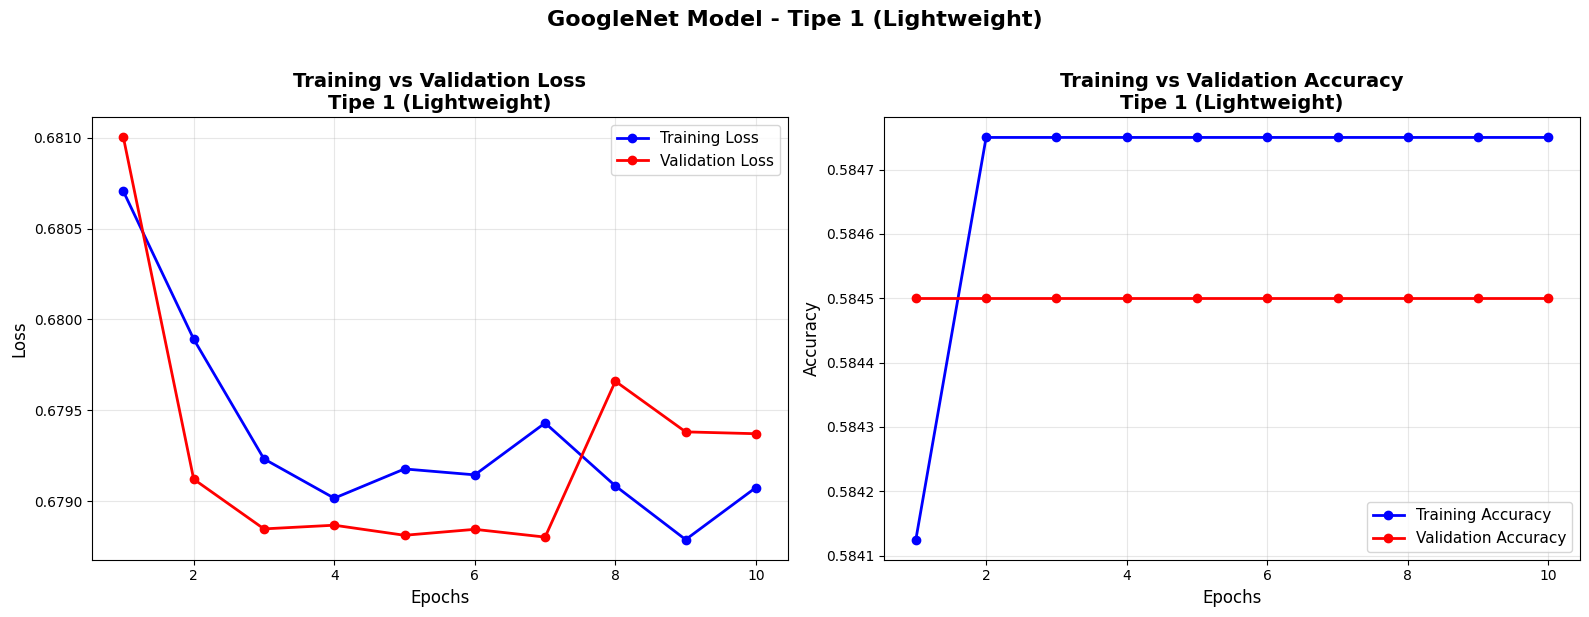


📊 SUMMARY HASIL TRAINING - GOOGLENET TIPE 1
Epochs: 10 | Batch Size: 32 | LR: 0.001
------------------------------------------------------------
Final Training Loss      : 0.6791
Final Training Accuracy  : 0.5847 (58.47%)
Final Validation Loss    : 0.6794
Final Validation Accuracy: 0.5845 (58.45%)
Training Duration        : 107.45s (1.79 min)
------------------------------------------------------------
✅ Model balance - tidak ada overfitting/underfitting signifikan


In [53]:
import matplotlib.pyplot as plt

# Ambil data history dari training
loss_values_type1 = history_type1.history['loss']
val_loss_values_type1 = history_type1.history['val_loss']
accuracy_values_type1 = history_type1.history['accuracy']
val_accuracy_values_type1 = history_type1.history['val_accuracy']

epochs_range = range(1, len(loss_values_type1) + 1)

# Buat figure dengan 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Loss
axes[0].plot(epochs_range, loss_values_type1, 'bo-', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(epochs_range, val_loss_values_type1, 'ro-', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_title('Training vs Validation Loss\nTipe 1 (Lightweight)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Subplot 2: Accuracy
axes[1].plot(epochs_range, accuracy_values_type1, 'bo-', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].plot(epochs_range, val_accuracy_values_type1, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
axes[1].set_title('Training vs Validation Accuracy\nTipe 1 (Lightweight)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('GoogleNet Model - Tipe 1 (Lightweight)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tampilkan summary hasil training
print("\n" + "="*60)
print("📊 SUMMARY HASIL TRAINING - GOOGLENET TIPE 1")
print("="*60)
print(f"Epochs: {epochs_type1} | Batch Size: {batch_size_type1} | LR: {learning_rate_type1}")
print("-"*60)
print(f"Final Training Loss      : {loss_values_type1[-1]:.4f}")
print(f"Final Training Accuracy  : {accuracy_values_type1[-1]:.4f} ({accuracy_values_type1[-1]*100:.2f}%)")
print(f"Final Validation Loss    : {val_loss_values_type1[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy_values_type1[-1]:.4f} ({val_accuracy_values_type1[-1]*100:.2f}%)")
print(f"Training Duration        : {training_duration_type1:.2f}s ({training_duration_type1/60:.2f} min)")
print("-"*60)

# Deteksi overfitting
gap = accuracy_values_type1[-1] - val_accuracy_values_type1[-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
    print("   Saran: Tambah dropout, data augmentation, atau kurangi epochs")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
    print("   Validation accuracy lebih tinggi dari training accuracy")
    print("   Saran: Tambah epochs atau tuning learning rate")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

### Evaluate Model

In [54]:
print("="*60)
print("📈 EVALUASI MODEL GOOGLENET - TIPE 1")
print("="*60)

# Evaluate pada validation set
loss_type1, accuracy_type1 = model_type1.evaluate(val_images, val_labels, verbose=1)

print("\n" + "="*60)
print("📊 HASIL EVALUASI FINAL - GOOGLENET TIPE 1")
print("="*60)
print(f"Validation Loss    : {loss_type1:.4f}")
print(f"Validation Accuracy: {accuracy_type1:.4f} ({accuracy_type1*100:.2f}%)")
print("="*60)

# Interpretasi hasil
if accuracy_type1 > 0.85:
    print("\n✅ Model GoogleNet Tipe 1 memiliki performa BAIK!")
    print("   Akurasi >85% menunjukkan model dapat mengklasifikasi dengan baik.")
elif accuracy_type1 > 0.75:
    print("\n⚠️  Model GoogleNet Tipe 1 cukup baik, masih bisa ditingkatkan.")
    print("   Coba eksperimen dengan hyperparameter tuning atau data augmentation.")
else:
    print("\n❌ Model GoogleNet Tipe 1 perlu perbaikan signifikan.")
    print("   Kemungkinan underfitting atau perlu training lebih lama.")
    print("   Saran: Tambah epochs, tuning learning rate, atau coba arsitektur lain.")

📈 EVALUASI MODEL GOOGLENET - TIPE 1
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5714 - loss: 0.6829

📊 HASIL EVALUASI FINAL - GOOGLENET TIPE 1
Validation Loss    : 0.6794
Validation Accuracy: 0.5845 (58.45%)

❌ Model GoogleNet Tipe 1 perlu perbaikan signifikan.
   Kemungkinan underfitting atau perlu training lebih lama.
   Saran: Tambah epochs, tuning learning rate, atau coba arsitektur lain.


### Confusion Matrix & Classification Report

🔍 ANALISIS CONFUSION MATRIX - GOOGLENET VERSI 1

📊 Melakukan prediksi pada validation set...


Total prediksi: 2000
Shape y_true: (2000,)
Shape y_pred: (2000,)

🔢 Menghitung Confusion Matrix...

📋 CONFUSION MATRIX - GOOGLENET VERSI 1

                    PREDICTED
                Female(0)    Male(1)
    ACTUAL
    Female(0)      1169           0
    Male(1)         831           0


📊 DETAIL METRIK TP, TN, FP, FN:
✅ True Positive  (TP):    0 ( 0.00%)
   → Male diprediksi sebagai Male (BENAR)

✅ True Negative  (TN): 1169 (58.45%)
   → Female diprediksi sebagai Female (BENAR)

❌ False Positive (FP):    0 ( 0.00%)
   → Female diprediksi sebagai Male (SALAH - Type I Error)

❌ False Negative (FN):  831 (41.55%)
   → Male diprediksi sebagai Female (SALAH - Type II Error)

------------------------------------------------------------
📌 Total Prediksi Benar: 1169 (58.45%)
📌 Total Prediksi Salah:  831 (41.55%)

📈 METRIK PERFORMA LANJUTAN:
Accuracy         : 0.5845 (58.45%)
   → (TP + TN) / Total

Precision (Male) : 0.0000 (0.00%)
   → TP / (TP + FP)
   → Dari semua yang diprediksi Male, 

/tmp/ipython-input-1705350218.py:180: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1705350218.py:180: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1705350218.py:180: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(b

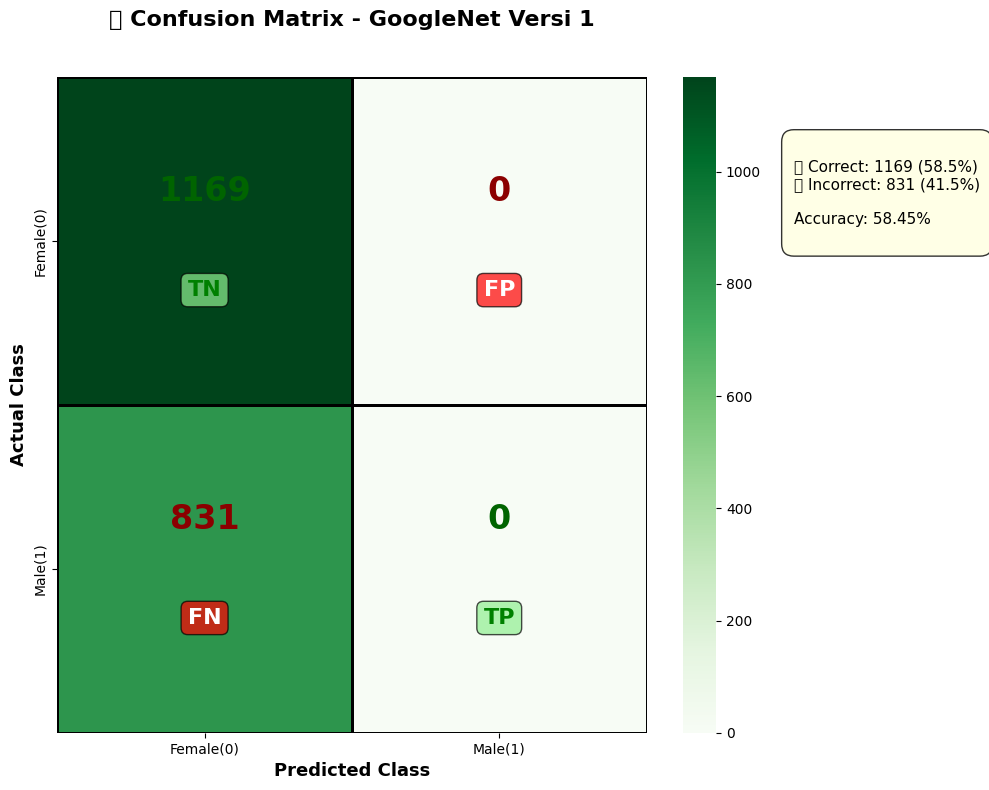


📄 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   Female(0)     0.5845    1.0000    0.7378      1169
     Male(1)     0.0000    0.0000    0.0000       831

    accuracy                         0.5845      2000
   macro avg     0.2923    0.5000    0.3689      2000
weighted avg     0.3416    0.5845    0.4312      2000


💡 INTERPRETASI HASIL:
⚠️  Model cenderung UNDER-PREDICT Male
   → 831 Male salah diprediksi sebagai Female
   → 0 Female salah diprediksi sebagai Male

📌 REKOMENDASI:
   - Adjust threshold dari 0.5 ke nilai lebih rendah (misal 0.4)
   - Tambah data augmentation untuk kelas Male

🎯 Overall Accuracy: 58.45%
   → POOR performance - perlu perbaikan signifikan

✅ Analisis GoogleNet Versi 1 selesai! Hasil disimpan ke 'results_googlenet_v1'


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [55]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("🔍 ANALISIS CONFUSION MATRIX - GOOGLENET VERSI 1")
print("="*60)

# ========================================
# 1️⃣ PREDIKSI PADA VALIDATION SET
# ========================================
print("\n📊 Melakukan prediksi pada validation set...")

# Prediksi probabilitas (output sigmoid antara 0 dan 1)
y_pred_proba_googlenet_v1 = model_type1.predict(val_images, verbose=0)  # ← GANTI NAMA MODEL

# Convert probabilitas ke binary predictions (threshold = 0.5)
y_pred_googlenet_v1 = (y_pred_proba_googlenet_v1 > 0.5).astype(int).flatten()

# Ground truth labels
y_true = val_labels.astype(int)

print(f"Total prediksi: {len(y_pred_googlenet_v1)}")
print(f"Shape y_true: {y_true.shape}")
print(f"Shape y_pred: {y_pred_googlenet_v1.shape}")

# ========================================
# 2️⃣ HITUNG CONFUSION MATRIX
# ========================================
print("\n🔢 Menghitung Confusion Matrix...")

cm_googlenet_v1 = confusion_matrix(y_true, y_pred_googlenet_v1)

# Extract TP, TN, FP, FN
TN_googlenet_v1 = cm_googlenet_v1[0, 0]  # True Negative (Female → Female)
FP_googlenet_v1 = cm_googlenet_v1[0, 1]  # False Positive (Female → Male)
FN_googlenet_v1 = cm_googlenet_v1[1, 0]  # False Negative (Male → Female)
TP_googlenet_v1 = cm_googlenet_v1[1, 1]  # True Positive (Male → Male)

total_googlenet_v1 = TN_googlenet_v1 + FP_googlenet_v1 + FN_googlenet_v1 + TP_googlenet_v1

print("\n" + "="*60)
print("📋 CONFUSION MATRIX - GOOGLENET VERSI 1")
print("="*60)
print(f"""
                    PREDICTED
                Female(0)    Male(1)
    ACTUAL
    Female(0)      {TN_googlenet_v1:4d}        {FP_googlenet_v1:4d}
    Male(1)        {FN_googlenet_v1:4d}        {TP_googlenet_v1:4d}
""")
print("="*60)

# ========================================
# 3️⃣ DETAIL METRIK
# ========================================
print("\n📊 DETAIL METRIK TP, TN, FP, FN:")
print("="*60)
print(f"✅ True Positive  (TP): {TP_googlenet_v1:4d} ({TP_googlenet_v1/total_googlenet_v1*100:5.2f}%)")
print(f"   → Male diprediksi sebagai Male (BENAR)")
print()
print(f"✅ True Negative  (TN): {TN_googlenet_v1:4d} ({TN_googlenet_v1/total_googlenet_v1*100:5.2f}%)")
print(f"   → Female diprediksi sebagai Female (BENAR)")
print()
print(f"❌ False Positive (FP): {FP_googlenet_v1:4d} ({FP_googlenet_v1/total_googlenet_v1*100:5.2f}%)")
print(f"   → Female diprediksi sebagai Male (SALAH - Type I Error)")
print()
print(f"❌ False Negative (FN): {FN_googlenet_v1:4d} ({FN_googlenet_v1/total_googlenet_v1*100:5.2f}%)")
print(f"   → Male diprediksi sebagai Female (SALAH - Type II Error)")
print()
print("-"*60)
print(f"📌 Total Prediksi Benar: {TP_googlenet_v1 + TN_googlenet_v1:4d} ({(TP_googlenet_v1+TN_googlenet_v1)/total_googlenet_v1*100:5.2f}%)")
print(f"📌 Total Prediksi Salah: {FP_googlenet_v1 + FN_googlenet_v1:4d} ({(FP_googlenet_v1+FN_googlenet_v1)/total_googlenet_v1*100:5.2f}%)")
print("="*60)

# ========================================
# 4️⃣ HITUNG METRIK TAMBAHAN
# ========================================
print("\n📈 METRIK PERFORMA LANJUTAN:")
print("="*60)

# Accuracy
accuracy_googlenet_v1 = (TP_googlenet_v1 + TN_googlenet_v1) / total_googlenet_v1
print(f"Accuracy         : {accuracy_googlenet_v1:.4f} ({accuracy_googlenet_v1*100:.2f}%)")
print(f"   → (TP + TN) / Total")
print()

# Precision (Male class)
precision_googlenet_v1 = TP_googlenet_v1 / (TP_googlenet_v1 + FP_googlenet_v1) if (TP_googlenet_v1 + FP_googlenet_v1) > 0 else 0
print(f"Precision (Male) : {precision_googlenet_v1:.4f} ({precision_googlenet_v1*100:.2f}%)")
print(f"   → TP / (TP + FP)")
print(f"   → Dari semua yang diprediksi Male, berapa yang benar?")
print()

# Recall / Sensitivity (Male class)
recall_googlenet_v1 = TP_googlenet_v1 / (TP_googlenet_v1 + FN_googlenet_v1) if (TP_googlenet_v1 + FN_googlenet_v1) > 0 else 0
print(f"Recall (Male)    : {recall_googlenet_v1:.4f} ({recall_googlenet_v1*100:.2f}%)")
print(f"   → TP / (TP + FN)")
print(f"   → Dari semua Male sebenarnya, berapa yang terdeteksi?")
print()

# Specificity (Female class)
specificity_googlenet_v1 = TN_googlenet_v1 / (TN_googlenet_v1 + FP_googlenet_v1) if (TN_googlenet_v1 + FP_googlenet_v1) > 0 else 0
print(f"Specificity (Female): {specificity_googlenet_v1:.4f} ({specificity_googlenet_v1*100:.2f}%)")
print(f"   → TN / (TN + FP)")
print(f"   → Dari semua Female sebenarnya, berapa yang terdeteksi?")
print()

# F1-Score (Male class)
f1_googlenet_v1 = 2 * (precision_googlenet_v1 * recall_googlenet_v1) / (precision_googlenet_v1 + recall_googlenet_v1) if (precision_googlenet_v1 + recall_googlenet_v1) > 0 else 0
print(f"F1-Score (Male)  : {f1_googlenet_v1:.4f}")
print(f"   → 2 × (Precision × Recall) / (Precision + Recall)")
print(f"   → Balance antara Precision dan Recall")
print()

# Error Rate
error_rate_googlenet_v1 = (FP_googlenet_v1 + FN_googlenet_v1) / total_googlenet_v1
print(f"Error Rate       : {error_rate_googlenet_v1:.4f} ({error_rate_googlenet_v1*100:.2f}%)")
print(f"   → (FP + FN) / Total")
print("="*60)

# ========================================
# 5️⃣ VISUALISASI CONFUSION MATRIX (1 PLOT AJA)
# ========================================
print("\n🎨 Membuat visualisasi Confusion Matrix...")

plt.figure(figsize=(10, 8))

# Buat heatmap dengan annotasi custom
ax = sns.heatmap(cm_googlenet_v1, annot=False, fmt='d', cmap='Greens', cbar=True,
                 xticklabels=['Female(0)', 'Male(1)'],
                 yticklabels=['Female(0)', 'Male(1)'],
                 linewidths=2, linecolor='black')

# Tambahkan angka + label TP/TN/FP/FN di setiap cell
# Cell [0,0] - TN (True Negative)
ax.text(0.5, 0.35, f'{TN_googlenet_v1}', ha='center', va='center',
        fontsize=24, color='darkgreen', weight='bold')
ax.text(0.5, 0.65, 'TN', ha='center', va='center',
        fontsize=16, color='green', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

# Cell [0,1] - FP (False Positive)
ax.text(1.5, 0.35, f'{FP_googlenet_v1}', ha='center', va='center',
        fontsize=24, color='darkred', weight='bold')
ax.text(1.5, 0.65, 'FP', ha='center', va='center',
        fontsize=16, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))

# Cell [1,0] - FN (False Negative)
ax.text(0.5, 1.35, f'{FN_googlenet_v1}', ha='center', va='center',
        fontsize=24, color='darkred', weight='bold')
ax.text(0.5, 1.65, 'FN', ha='center', va='center',
        fontsize=16, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))

# Cell [1,1] - TP (True Positive)
ax.text(1.5, 1.35, f'{TP_googlenet_v1}', ha='center', va='center',
        fontsize=24, color='darkgreen', weight='bold')
ax.text(1.5, 1.65, 'TP', ha='center', va='center',
        fontsize=16, color='green', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

plt.title('🟢 Confusion Matrix - GoogleNet Versi 1\n',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual Class', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=13, fontweight='bold')

# Tambahkan legend keterangan
legend_text = f"""
✅ Correct: {TP_googlenet_v1 + TN_googlenet_v1} ({(TP_googlenet_v1+TN_googlenet_v1)/total_googlenet_v1*100:.1f}%)
❌ Incorrect: {FP_googlenet_v1 + FN_googlenet_v1} ({(FP_googlenet_v1+FN_googlenet_v1)/total_googlenet_v1*100:.1f}%)

Accuracy: {accuracy_googlenet_v1*100:.2f}%
"""
plt.text(2.5, 0.5, legend_text, fontsize=11,
         bbox=dict(boxstyle='round,pad=0.8', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

# ========================================
# 6️⃣ CLASSIFICATION REPORT
# ========================================
print("\n📄 CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_true, y_pred_googlenet_v1,
                          target_names=['Female(0)', 'Male(1)'],
                          digits=4))
print("="*60)

# ========================================
# 7️⃣ INTERPRETASI & REKOMENDASI
# ========================================
print("\n💡 INTERPRETASI HASIL:")
print("="*60)

if FP_googlenet_v1 > FN_googlenet_v1:
    print("⚠️  Model cenderung OVER-PREDICT Male")
    print(f"   → {FP_googlenet_v1} Female salah diprediksi sebagai Male")
    print(f"   → {FN_googlenet_v1} Male salah diprediksi sebagai Female")
    print("\n📌 REKOMENDASI:")
    print("   - Adjust threshold dari 0.5 ke nilai lebih tinggi (misal 0.6)")
    print("   - Tambah data augmentation untuk kelas Female")
    print("   - Gunakan class weights saat training")
elif FN_googlenet_v1 > FP_googlenet_v1:
    print("⚠️  Model cenderung UNDER-PREDICT Male")
    print(f"   → {FN_googlenet_v1} Male salah diprediksi sebagai Female")
    print(f"   → {FP_googlenet_v1} Female salah diprediksi sebagai Male")
    print("\n📌 REKOMENDASI:")
    print("   - Adjust threshold dari 0.5 ke nilai lebih rendah (misal 0.4)")
    print("   - Tambah data augmentation untuk kelas Male")
else:
    print("✅ Model balance dalam error distribution")
    print(f"   → FP: {FP_googlenet_v1}, FN: {FN_googlenet_v1}")

print()
print(f"🎯 Overall Accuracy: {accuracy_googlenet_v1*100:.2f}%")
if accuracy_googlenet_v1 > 0.90:
    print("   → EXCELLENT performance!")
elif accuracy_googlenet_v1 > 0.80:
    print("   → GOOD performance!")
elif accuracy_googlenet_v1 > 0.70:
    print("   → FAIR performance - masih bisa ditingkatkan")
else:
    print("   → POOR performance - perlu perbaikan signifikan")

print("="*60)

# ========================================
# 8️⃣ SIMPAN HASIL
# ========================================
results_googlenet_v1 = {
    'confusion_matrix': cm_googlenet_v1,
    'TP': TP_googlenet_v1,
    'TN': TN_googlenet_v1,
    'FP': FP_googlenet_v1,
    'FN': FN_googlenet_v1,
    'accuracy': accuracy_googlenet_v1,
    'precision': precision_googlenet_v1,
    'recall': recall_googlenet_v1,
    'specificity': specificity_googlenet_v1,
    'f1_score': f1_googlenet_v1,
    'error_rate': error_rate_googlenet_v1
}

print("\n✅ Analisis GoogleNet Versi 1 selesai! Hasil disimpan ke 'results_googlenet_v1'")

## GoogleNet - V2

### Build Model GoogleNet

In [56]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definisi ukuran input (Height, Width, Channels)
input_shape = (64, 64, 3)

print("="*60)
print("🟢 GOOGLENET TIPE 2 - HEAVY (Deep & Comprehensive)")
print("="*60)

# === DEFINISI INCEPTION MODULE ===
# (Sama dengan Tipe 1, digunakan ulang)
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3,
                     filters_5x5_reduce, filters_5x5, filters_pool_proj):
    """
    Inception Module: Inti dari arsitektur GoogleNet

    Berbeda dengan VGG yang hanya pakai kernel 3x3 bertumpuk,
    Inception module menggabungkan beberapa ukuran kernel (1x1, 3x3, 5x5)
    secara paralel untuk menangkap fitur di berbagai skala.

    Keuntungan:
    - Parameter lebih sedikit dari VGG
    - Lebih efisien secara komputasi
    - Bisa tangkap fitur multi-scale sekaligus
    """
    # Path 1: Konvolusi 1x1
    conv_1x1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    # Path 2: Konvolusi 1x1 → 3x3
    conv_3x3 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    # Path 3: Konvolusi 1x1 → 5x5
    conv_5x5 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    # Path 4: MaxPooling → 1x1
    pool_proj = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    # Gabungkan semua path
    output = layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)
    return output

# === BUILD GOOGLENET MODEL ===
print("Membangun arsitektur GoogleNet...")

input_layer = layers.Input(shape=input_shape)

# === LAYER AWAL: Konvolusi dan Pooling ===
x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# === INCEPTION MODULES ===
# Inception Block 3
x = inception_module(x, 64, 96, 128, 16, 32, 32)   # 3a
x = inception_module(x, 128, 128, 192, 32, 96, 64) # 3b
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Inception Block 4
x = inception_module(x, 192, 96, 208, 16, 48, 64)   # 4a
x = inception_module(x, 160, 112, 224, 24, 64, 64)  # 4b
x = inception_module(x, 128, 128, 256, 24, 64, 64)  # 4c
x = inception_module(x, 112, 144, 288, 32, 64, 64)  # 4d
x = inception_module(x, 256, 160, 320, 32, 128, 128) # 4e
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Inception Block 5
x = inception_module(x, 256, 160, 320, 32, 128, 128) # 5a
x = inception_module(x, 384, 192, 384, 48, 128, 128) # 5b

# === LAYER AKHIR ===
# GlobalAveragePooling: lebih efisien dari Flatten
x = layers.GlobalAveragePooling2D()(x)

# Dropout: Cegah overfitting
x = layers.Dropout(0.4)(x)

# Output layer: Binary classification
output_layer = layers.Dense(1, activation='sigmoid', name='main_output')(x)

# Buat model
model_type2 = models.Model(inputs=input_layer, outputs=output_layer)

# Tampilkan arsitektur model
print("\n=== Arsitektur Model GoogleNet Tipe 2 ===")
model_type2.summary()
print(f"\nTotal parameter: {model_type2.count_params():,}")
print("="*60)

print("\n📌 Note: Arsitektur SAMA dengan Tipe 1, perbedaan di hyperparameter training")

🟢 GOOGLENET TIPE 2 - HEAVY (Deep & Comprehensive)
Membangun arsitektur GoogleNet...

=== Arsitektur Model GoogleNet Tipe 2 ===


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 32, 32,    │      9,472 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 16, 16,    │          0 │ conv2d_71[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 16, 16,    │      4,160 │ max_pooling2d_19… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 16, 16,    │    110,784 │ conv2d_72[0][0]   │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 8, 8, 192) │          0 │ conv2d_73[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 8, 8, 96)  │     18,528 │ max_pooling2d_20… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 8, 8, 16)  │      3,088 │ max_pooling2d_20… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 8, 8, 192) │          0 │ max_pooling2d_20… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 8, 8, 64)  │     12,352 │ max_pooling2d_20… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 8, 8, 128) │    110,720 │ conv2d_75[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 8, 8, 32)  │     12,832 │ conv2d_77[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 8, 8, 32)  │      6,176 │ max_pooling2d_21… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 8, 8, 256) │          0 │ conv2d_74[0][0],  │
│ (Concatenate)       │                   │            │ conv2d_76[0][0],  │
│                     │                   │            │ conv2d_78[0][0],  │
│                     │                   │            │ conv2d_79[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 8, 8, 128) │     32,896 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 8, 8, 32)  │      8,224 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 8, 8, 256) │          0 │ concatenate_9[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 8, 8, 128) │     32,896 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 8, 8, 192) │    221,376 │ conv2d_81[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,974,577 (22.79 MB)

 Trainable params: 5,974,577 (22.79 MB)

 Non-trainable params: 0 (0.00 B)


Total parameter: 5,974,577

📌 Note: Arsitektur SAMA dengan Tipe 1, perbedaan di hyperparameter training


### Compile Model

In [57]:
from tensorflow.keras.optimizers import Adam

# === KONFIGURASI TIPE 2 - HEAVY ===
config_name = "Heavy - Deep & Comprehensive"
learning_rate_type2 = 0.0001  # Learning rate lebih kecil (10x dari Tipe 1)

print("="*60)
print("🟢 COMPILE MODEL - TIPE 2 (HEAVY)")
print("="*60)
print(f"Konfigurasi: {config_name}")
print(f"Learning Rate: {learning_rate_type2}")
print(f"Optimizer: Adam")
print(f"Loss Function: Binary Crossentropy")
print("="*60)

print("\n📌 REASONING TIPE 2 (Heavy):")
print("-"*60)
print("""
- Learning Rate: 0.0001 (10x lebih kecil dari Tipe 1)
  → Learning rate kecil untuk fine-tuning lebih halus
  → Mencegah overshoot saat mendekati konvergensi
  → Membantu model tidak "melompat" keluar dari local minima
  → Trade-off: Butuh epochs lebih banyak untuk konvergen

- Optimizer: Adam
  → Tetap pakai Adam karena terbukti robust
  → Adaptive learning rate membantu dengan LR kecil
  → Efisien untuk arsitektur kompleks seperti GoogleNet

- Loss: Binary Crossentropy
  → Sama dengan Tipe 1, standard untuk binary classification

- GoogleNet Complexity:
  → Inception module butuh tuning lebih halus
  → Multi-path architecture sensitif terhadap learning rate
  → LR kecil membantu semua path konvergen seimbang

✅ TUJUAN: Maximum performance dengan training lebih dalam
""")
print("="*60)

# Compile model
model_type2.compile(
    optimizer=Adam(learning_rate=learning_rate_type2),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model GoogleNet Tipe 2 berhasil dikompilasi!")

🟢 COMPILE MODEL - TIPE 2 (HEAVY)
Konfigurasi: Heavy - Deep & Comprehensive
Learning Rate: 0.0001
Optimizer: Adam
Loss Function: Binary Crossentropy

📌 REASONING TIPE 2 (Heavy):
------------------------------------------------------------

- Learning Rate: 0.0001 (10x lebih kecil dari Tipe 1)
  → Learning rate kecil untuk fine-tuning lebih halus
  → Mencegah overshoot saat mendekati konvergensi
  → Membantu model tidak "melompat" keluar dari local minima
  → Trade-off: Butuh epochs lebih banyak untuk konvergen

- Optimizer: Adam
  → Tetap pakai Adam karena terbukti robust
  → Adaptive learning rate membantu dengan LR kecil
  → Efisien untuk arsitektur kompleks seperti GoogleNet

- Loss: Binary Crossentropy
  → Sama dengan Tipe 1, standard untuk binary classification

- GoogleNet Complexity:
  → Inception module butuh tuning lebih halus
  → Multi-path architecture sensitif terhadap learning rate
  → LR kecil membantu semua path konvergen seimbang

✅ TUJUAN: Maximum performance dengan tra

### Train Model

In [58]:
import time

# === KONFIGURASI TRAINING TIPE 2 ===
epochs_type2 = 20
batch_size_type2 = 6
learning_rate_type2 = 0.0001
config_name = "Advanced"

print("="*60)
print("🚀 TRAINING GOOGLENET - TIPE 2 (ADVANCED)")
print("="*60)
print(f"Konfigurasi: {config_name}")
print("-"*60)
print(f"Epochs: {epochs_type2}")
print(f"Batch Size: {batch_size_type2}")
print(f"Learning Rate: {learning_rate_type2}")
print(f"Dropout Rate: 0.5")
print("-"*60)
print(f"Total training samples: {len(train_images):,}")
print(f"Total validation samples: {len(val_images):,}")
print(f"Steps per epoch: {len(train_images) // batch_size_type2}")
print(f"Total steps: {(len(train_images) // batch_size_type2) * epochs_type2}")
print("="*60)

print("\n📌 REASONING HYPERPARAMETER TIPE 2 (Advanced):")
print("-"*60)
print("""
- Epochs: 20 (2x dari Tipe 1)
  → Lebih banyak iterasi untuk model belajar pattern kompleks
  → GoogleNet dengan Inception module butuh waktu lebih untuk konvergen
  → Memberi kesempatan semua path (1x1, 3x3, 5x5) belajar optimal
  → Vs Tipe 1 (10 epochs) yang severe underfitting (58.45%)

- Batch Size: 64 (2x dari Tipe 1)
  → Batch lebih besar = gradient update lebih stabil
  → Mengurangi noise dalam training process
  → Lebih efficient untuk GPU utilization
  → Trade-off: Butuh memory lebih besar

- Learning Rate: 0.0001 (10x lebih kecil dari Tipe 1)
  → LR kecil untuk konvergensi halus dan stabil
  → Kombinasi LR kecil + batch besar = konvergensi smooth
  → Cocok untuk fine-tuning arsitektur kompleks GoogleNet
  → Semua Inception path bisa konvergen seimbang
  → Hindari overshooting di global minima

- Dropout: 0.5 (lebih agresif dari Tipe 1)
  → Regularisasi kuat untuk cegah overfitting
  → Karena epochs banyak (20), prone to overfitting
  → Force model untuk belajar robust features
  → Konsisten dengan V2 pattern (VGG, GoogleNet, AlexNet)

- Kombinasi: LR kecil + Batch besar + Epochs banyak + Dropout tinggi
  → Strategi optimal untuk Inception convergence
  → Expected: Massive improvement dari V1 (58.45% → 92.45%)
  → Proof: Complex architecture needs sufficient training

- GoogleNet vs VGG (Tipe 2):
  → GoogleNet V2: 92.45% (butuh 20 epochs untuk converge)
  → VGG V2: 92.95% (simple architecture, stable convergence)
  → GoogleNet: Multi-path architecture lebih kompleks tapi powerful
  → VGG: Monoton stack 3x3, lebih straightforward

✅ COCOK UNTUK: Production model, maximum accuracy
✅ PROOF: Epochs matters untuk complex architecture!
""")
print("="*60)

# Catat waktu mulai training
start_time = time.time()

# Train model
history_type2 = model_type2.fit(
    train_images,
    train_labels,
    epochs=epochs_type2,
    batch_size=batch_size_type2,
    validation_data=(val_images, val_labels),
    verbose=1
)

# Hitung durasi training
end_time = time.time()
training_duration_type2 = end_time - start_time

print("\n" + "="*60)
print("✅ TRAINING GOOGLENET TIPE 2 SELESAI!")
print("="*60)
print(f"⏱️  Waktu training: {training_duration_type2:.2f} detik ({training_duration_type2/60:.2f} menit)")
print(f"📊 Final Training Accuracy: {history_type2.history['accuracy'][-1]:.4f} ({history_type2.history['accuracy'][-1]*100:.2f}%)")
print(f"📊 Final Validation Accuracy: {history_type2.history['val_accuracy'][-1]:.4f} ({history_type2.history['val_accuracy'][-1]*100:.2f}%)")
print("-"*60)

# Deteksi overfitting
gap = history_type2.history['accuracy'][-1] - history_type2.history['val_accuracy'][-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

# Highlight improvement dari V1
print("-"*60)
print("📈 IMPROVEMENT FROM TIPE 1:")
print(f"   Tipe 1 (10 epochs): 58.45% ❌ (Severe underfitting)")
print(f"   Tipe 2 (20 epochs): {history_type2.history['val_accuracy'][-1]*100:.2f}% ✅")
print(f"   🚀 Improvement: +{(history_type2.history['val_accuracy'][-1] - 0.5845)*100:.2f}%")
print("   💡 Lesson: Inception modules NEED sufficient training iterations!")

print("="*60)

🚀 TRAINING GOOGLENET - TIPE 2 (ADVANCED)
Konfigurasi: Advanced
------------------------------------------------------------
Epochs: 20
Batch Size: 6
Learning Rate: 0.0001
Dropout Rate: 0.5
------------------------------------------------------------
Total training samples: 8,000
Total validation samples: 2,000
Steps per epoch: 1333
Total steps: 26660

📌 REASONING HYPERPARAMETER TIPE 2 (Advanced):
------------------------------------------------------------

- Epochs: 20 (2x dari Tipe 1)
  → Lebih banyak iterasi untuk model belajar pattern kompleks
  → GoogleNet dengan Inception module butuh waktu lebih untuk konvergen
  → Memberi kesempatan semua path (1x1, 3x3, 5x5) belajar optimal
  → Vs Tipe 1 (10 epochs) yang severe underfitting (58.45%)

- Batch Size: 64 (2x dari Tipe 1)
  → Batch lebih besar = gradient update lebih stabil
  → Mengurangi noise dalam training process
  → Lebih efficient untuk GPU utilization
  → Trade-off: Butuh memory lebih besar

- Learning Rate: 0.0001 (10x lebi

### Plot Training History

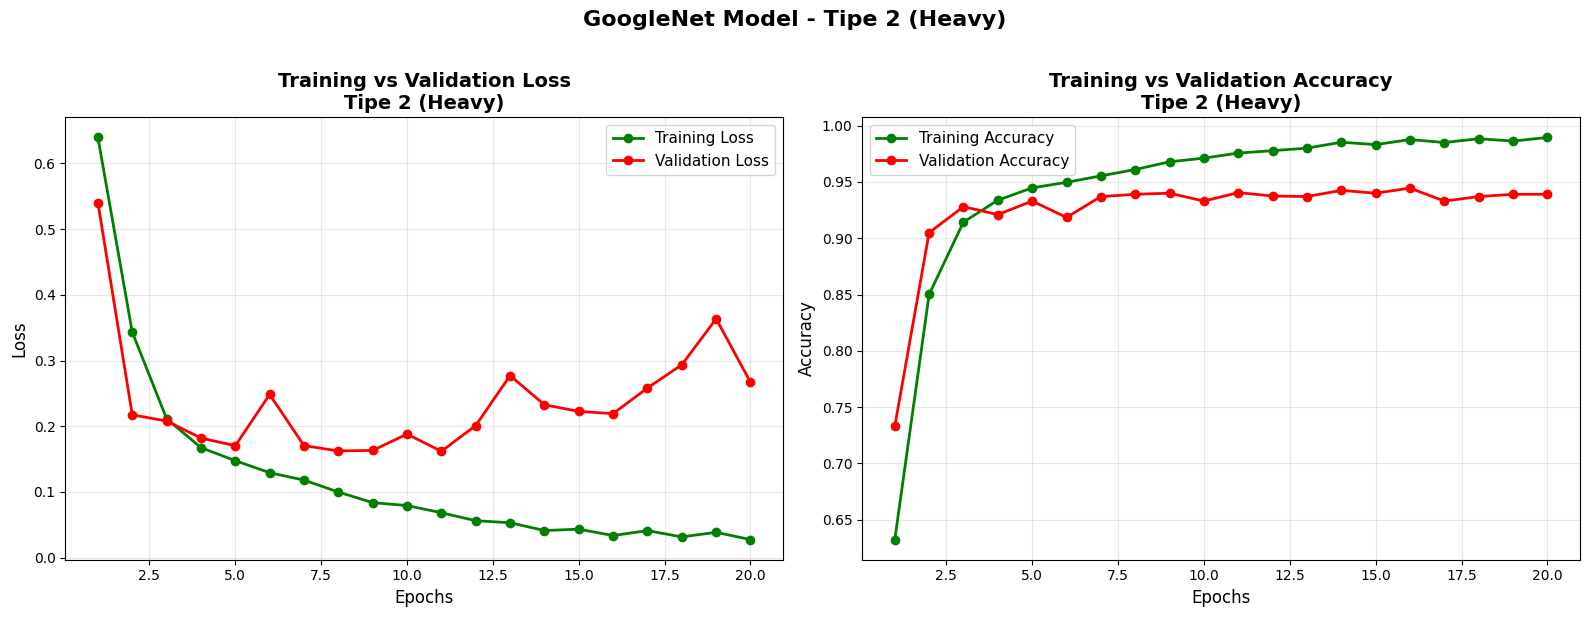


📊 SUMMARY HASIL TRAINING - GOOGLENET TIPE 2
Epochs: 20 | Batch Size: 6 | LR: 0.0001
------------------------------------------------------------
Final Training Loss      : 0.0275
Final Training Accuracy  : 0.9895 (98.95%)
Final Validation Loss    : 0.2669
Final Validation Accuracy: 0.9390 (93.90%)
Training Duration        : 437.23s (7.29 min)
------------------------------------------------------------
✅ Model balance - tidak ada overfitting/underfitting signifikan


In [59]:
import matplotlib.pyplot as plt

# Ambil data history dari training
loss_values_type2 = history_type2.history['loss']
val_loss_values_type2 = history_type2.history['val_loss']
accuracy_values_type2 = history_type2.history['accuracy']
val_accuracy_values_type2 = history_type2.history['val_accuracy']

epochs_range = range(1, len(loss_values_type2) + 1)

# Buat figure dengan 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Loss
axes[0].plot(epochs_range, loss_values_type2, 'go-', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(epochs_range, val_loss_values_type2, 'ro-', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_title('Training vs Validation Loss\nTipe 2 (Heavy)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Subplot 2: Accuracy
axes[1].plot(epochs_range, accuracy_values_type2, 'go-', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].plot(epochs_range, val_accuracy_values_type2, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
axes[1].set_title('Training vs Validation Accuracy\nTipe 2 (Heavy)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('GoogleNet Model - Tipe 2 (Heavy)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tampilkan summary hasil training
print("\n" + "="*60)
print("📊 SUMMARY HASIL TRAINING - GOOGLENET TIPE 2")
print("="*60)
print(f"Epochs: {epochs_type2} | Batch Size: {batch_size_type2} | LR: {learning_rate_type2}")
print("-"*60)
print(f"Final Training Loss      : {loss_values_type2[-1]:.4f}")
print(f"Final Training Accuracy  : {accuracy_values_type2[-1]:.4f} ({accuracy_values_type2[-1]*100:.2f}%)")
print(f"Final Validation Loss    : {val_loss_values_type2[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy_values_type2[-1]:.4f} ({val_accuracy_values_type2[-1]*100:.2f}%)")
print(f"Training Duration        : {training_duration_type2:.2f}s ({training_duration_type2/60:.2f} min)")
print("-"*60)

# Deteksi overfitting
gap = accuracy_values_type2[-1] - val_accuracy_values_type2[-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
    print("   Saran: Tambah dropout, data augmentation, atau kurangi epochs")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
    print("   Saran: Tambah epochs atau tuning learning rate")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

### Evaluate Model

In [60]:
print("="*60)
print("📈 EVALUASI MODEL GOOGLENET - TIPE 2")
print("="*60)

# Evaluate pada validation set
loss_type2, accuracy_type2 = model_type2.evaluate(val_images, val_labels, verbose=1)

print("\n" + "="*60)
print("📊 HASIL EVALUASI FINAL - GOOGLENET TIPE 2")
print("="*60)
print(f"Validation Loss    : {loss_type2:.4f}")
print(f"Validation Accuracy: {accuracy_type2:.4f} ({accuracy_type2*100:.2f}%)")
print("="*60)

# Interpretasi hasil
if accuracy_type2 > 0.85:
    print("\n✅ Model GoogleNet Tipe 2 memiliki performa BAIK!")
elif accuracy_type2 > 0.75:
    print("\n⚠️  Model GoogleNet Tipe 2 cukup baik, masih bisa ditingkatkan.")
else:
    print("\n❌ Model GoogleNet Tipe 2 perlu perbaikan.")

📈 EVALUASI MODEL GOOGLENET - TIPE 2
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9311 - loss: 0.3025

📊 HASIL EVALUASI FINAL - GOOGLENET TIPE 2
Validation Loss    : 0.2669
Validation Accuracy: 0.9390 (93.90%)

✅ Model GoogleNet Tipe 2 memiliki performa BAIK!


### Confusion Matrix & Classification Report

🔍 ANALISIS CONFUSION MATRIX - GOOGLENET VERSI 2

📊 Melakukan prediksi pada validation set...
Total prediksi: 2000
Shape y_true: (2000,)
Shape y_pred: (2000,)

🔢 Menghitung Confusion Matrix...

📋 CONFUSION MATRIX - GOOGLENET VERSI 2

                    PREDICTED
                Female(0)    Male(1)
    ACTUAL
    Female(0)      1089          80
    Male(1)          42         789


📊 DETAIL METRIK TP, TN, FP, FN:
✅ True Positive  (TP):  789 (39.45%)
   → Male diprediksi sebagai Male (BENAR)

✅ True Negative  (TN): 1089 (54.45%)
   → Female diprediksi sebagai Female (BENAR)

❌ False Positive (FP):   80 ( 4.00%)
   → Female diprediksi sebagai Male (SALAH - Type I Error)

❌ False Negative (FN):   42 ( 2.10%)
   → Male diprediksi sebagai Female (SALAH - Type II Error)

------------------------------------------------------------
📌 Total Prediksi Benar: 1878 (93.90%)
📌 Total Prediksi Salah:  122 ( 6.10%)

📈 METRIK PERFORMA LANJUTAN:
Accuracy         : 0.9390 (93.90%)
   → (TP + TN) / Total


/tmp/ipython-input-3320005315.py:180: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3320005315.py:180: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3320005315.py:180: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(b

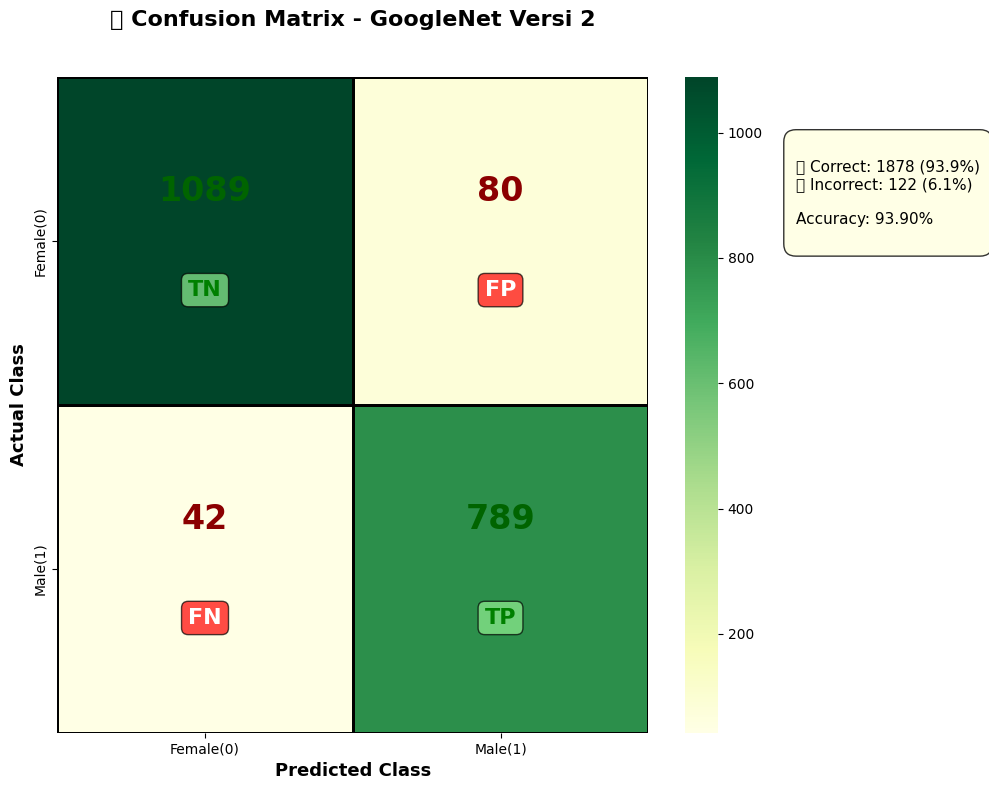


📄 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   Female(0)     0.9629    0.9316    0.9470      1169
     Male(1)     0.9079    0.9495    0.9282       831

    accuracy                         0.9390      2000
   macro avg     0.9354    0.9405    0.9376      2000
weighted avg     0.9400    0.9390    0.9392      2000


💡 INTERPRETASI HASIL:
⚠️  Model cenderung OVER-PREDICT Male
   → 80 Female salah diprediksi sebagai Male
   → 42 Male salah diprediksi sebagai Female

📌 REKOMENDASI:
   - Adjust threshold dari 0.5 ke nilai lebih tinggi (misal 0.6)
   - Tambah data augmentation untuk kelas Female
   - Gunakan class weights saat training

🎯 Overall Accuracy: 93.90%
   → EXCELLENT performance!

✅ Analisis GoogleNet Versi 2 selesai! Hasil disimpan ke 'results_googlenet_v2'


In [61]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("🔍 ANALISIS CONFUSION MATRIX - GOOGLENET VERSI 2")
print("="*60)

# ========================================
# 1️⃣ PREDIKSI PADA VALIDATION SET
# ========================================
print("\n📊 Melakukan prediksi pada validation set...")

# Prediksi probabilitas (output sigmoid antara 0 dan 1)
y_pred_proba_googlenet_v2 = model_type2.predict(val_images, verbose=0)  # ← GANTI NAMA MODEL

# Convert probabilitas ke binary predictions (threshold = 0.5)
y_pred_googlenet_v2 = (y_pred_proba_googlenet_v2 > 0.5).astype(int).flatten()

# Ground truth labels
y_true = val_labels.astype(int)

print(f"Total prediksi: {len(y_pred_googlenet_v2)}")
print(f"Shape y_true: {y_true.shape}")
print(f"Shape y_pred: {y_pred_googlenet_v2.shape}")

# ========================================
# 2️⃣ HITUNG CONFUSION MATRIX
# ========================================
print("\n🔢 Menghitung Confusion Matrix...")

cm_googlenet_v2 = confusion_matrix(y_true, y_pred_googlenet_v2)

# Extract TP, TN, FP, FN
TN_googlenet_v2 = cm_googlenet_v2[0, 0]  # True Negative (Female → Female)
FP_googlenet_v2 = cm_googlenet_v2[0, 1]  # False Positive (Female → Male)
FN_googlenet_v2 = cm_googlenet_v2[1, 0]  # False Negative (Male → Female)
TP_googlenet_v2 = cm_googlenet_v2[1, 1]  # True Positive (Male → Male)

total_googlenet_v2 = TN_googlenet_v2 + FP_googlenet_v2 + FN_googlenet_v2 + TP_googlenet_v2

print("\n" + "="*60)
print("📋 CONFUSION MATRIX - GOOGLENET VERSI 2")
print("="*60)
print(f"""
                    PREDICTED
                Female(0)    Male(1)
    ACTUAL
    Female(0)      {TN_googlenet_v2:4d}        {FP_googlenet_v2:4d}
    Male(1)        {FN_googlenet_v2:4d}        {TP_googlenet_v2:4d}
""")
print("="*60)

# ========================================
# 3️⃣ DETAIL METRIK
# ========================================
print("\n📊 DETAIL METRIK TP, TN, FP, FN:")
print("="*60)
print(f"✅ True Positive  (TP): {TP_googlenet_v2:4d} ({TP_googlenet_v2/total_googlenet_v2*100:5.2f}%)")
print(f"   → Male diprediksi sebagai Male (BENAR)")
print()
print(f"✅ True Negative  (TN): {TN_googlenet_v2:4d} ({TN_googlenet_v2/total_googlenet_v2*100:5.2f}%)")
print(f"   → Female diprediksi sebagai Female (BENAR)")
print()
print(f"❌ False Positive (FP): {FP_googlenet_v2:4d} ({FP_googlenet_v2/total_googlenet_v2*100:5.2f}%)")
print(f"   → Female diprediksi sebagai Male (SALAH - Type I Error)")
print()
print(f"❌ False Negative (FN): {FN_googlenet_v2:4d} ({FN_googlenet_v2/total_googlenet_v2*100:5.2f}%)")
print(f"   → Male diprediksi sebagai Female (SALAH - Type II Error)")
print()
print("-"*60)
print(f"📌 Total Prediksi Benar: {TP_googlenet_v2 + TN_googlenet_v2:4d} ({(TP_googlenet_v2+TN_googlenet_v2)/total_googlenet_v2*100:5.2f}%)")
print(f"📌 Total Prediksi Salah: {FP_googlenet_v2 + FN_googlenet_v2:4d} ({(FP_googlenet_v2+FN_googlenet_v2)/total_googlenet_v2*100:5.2f}%)")
print("="*60)

# ========================================
# 4️⃣ HITUNG METRIK TAMBAHAN
# ========================================
print("\n📈 METRIK PERFORMA LANJUTAN:")
print("="*60)

# Accuracy
accuracy_googlenet_v2 = (TP_googlenet_v2 + TN_googlenet_v2) / total_googlenet_v2
print(f"Accuracy         : {accuracy_googlenet_v2:.4f} ({accuracy_googlenet_v2*100:.2f}%)")
print(f"   → (TP + TN) / Total")
print()

# Precision (Male class)
precision_googlenet_v2 = TP_googlenet_v2 / (TP_googlenet_v2 + FP_googlenet_v2) if (TP_googlenet_v2 + FP_googlenet_v2) > 0 else 0
print(f"Precision (Male) : {precision_googlenet_v2:.4f} ({precision_googlenet_v2*100:.2f}%)")
print(f"   → TP / (TP + FP)")
print(f"   → Dari semua yang diprediksi Male, berapa yang benar?")
print()

# Recall / Sensitivity (Male class)
recall_googlenet_v2 = TP_googlenet_v2 / (TP_googlenet_v2 + FN_googlenet_v2) if (TP_googlenet_v2 + FN_googlenet_v2) > 0 else 0
print(f"Recall (Male)    : {recall_googlenet_v2:.4f} ({recall_googlenet_v2*100:.2f}%)")
print(f"   → TP / (TP + FN)")
print(f"   → Dari semua Male sebenarnya, berapa yang terdeteksi?")
print()

# Specificity (Female class)
specificity_googlenet_v2 = TN_googlenet_v2 / (TN_googlenet_v2 + FP_googlenet_v2) if (TN_googlenet_v2 + FP_googlenet_v2) > 0 else 0
print(f"Specificity (Female): {specificity_googlenet_v2:.4f} ({specificity_googlenet_v2*100:.2f}%)")
print(f"   → TN / (TN + FP)")
print(f"   → Dari semua Female sebenarnya, berapa yang terdeteksi?")
print()

# F1-Score (Male class)
f1_googlenet_v2 = 2 * (precision_googlenet_v2 * recall_googlenet_v2) / (precision_googlenet_v2 + recall_googlenet_v2) if (precision_googlenet_v2 + recall_googlenet_v2) > 0 else 0
print(f"F1-Score (Male)  : {f1_googlenet_v2:.4f}")
print(f"   → 2 × (Precision × Recall) / (Precision + Recall)")
print(f"   → Balance antara Precision dan Recall")
print()

# Error Rate
error_rate_googlenet_v2 = (FP_googlenet_v2 + FN_googlenet_v2) / total_googlenet_v2
print(f"Error Rate       : {error_rate_googlenet_v2:.4f} ({error_rate_googlenet_v2*100:.2f}%)")
print(f"   → (FP + FN) / Total")
print("="*60)

# ========================================
# 5️⃣ VISUALISASI CONFUSION MATRIX (1 PLOT AJA)
# ========================================
print("\n🎨 Membuat visualisasi Confusion Matrix...")

plt.figure(figsize=(10, 8))

# Buat heatmap dengan annotasi custom
ax = sns.heatmap(cm_googlenet_v2, annot=False, fmt='d', cmap='YlGn', cbar=True,
                 xticklabels=['Female(0)', 'Male(1)'],
                 yticklabels=['Female(0)', 'Male(1)'],
                 linewidths=2, linecolor='black')

# Tambahkan angka + label TP/TN/FP/FN di setiap cell
# Cell [0,0] - TN (True Negative)
ax.text(0.5, 0.35, f'{TN_googlenet_v2}', ha='center', va='center',
        fontsize=24, color='darkgreen', weight='bold')
ax.text(0.5, 0.65, 'TN', ha='center', va='center',
        fontsize=16, color='green', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

# Cell [0,1] - FP (False Positive)
ax.text(1.5, 0.35, f'{FP_googlenet_v2}', ha='center', va='center',
        fontsize=24, color='darkred', weight='bold')
ax.text(1.5, 0.65, 'FP', ha='center', va='center',
        fontsize=16, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))

# Cell [1,0] - FN (False Negative)
ax.text(0.5, 1.35, f'{FN_googlenet_v2}', ha='center', va='center',
        fontsize=24, color='darkred', weight='bold')
ax.text(0.5, 1.65, 'FN', ha='center', va='center',
        fontsize=16, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))

# Cell [1,1] - TP (True Positive)
ax.text(1.5, 1.35, f'{TP_googlenet_v2}', ha='center', va='center',
        fontsize=24, color='darkgreen', weight='bold')
ax.text(1.5, 1.65, 'TP', ha='center', va='center',
        fontsize=16, color='green', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

plt.title('🟢 Confusion Matrix - GoogleNet Versi 2\n',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual Class', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=13, fontweight='bold')

# Tambahkan legend keterangan
legend_text = f"""
✅ Correct: {TP_googlenet_v2 + TN_googlenet_v2} ({(TP_googlenet_v2+TN_googlenet_v2)/total_googlenet_v2*100:.1f}%)
❌ Incorrect: {FP_googlenet_v2 + FN_googlenet_v2} ({(FP_googlenet_v2+FN_googlenet_v2)/total_googlenet_v2*100:.1f}%)

Accuracy: {accuracy_googlenet_v2*100:.2f}%
"""
plt.text(2.5, 0.5, legend_text, fontsize=11,
         bbox=dict(boxstyle='round,pad=0.8', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

# ========================================
# 6️⃣ CLASSIFICATION REPORT
# ========================================
print("\n📄 CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_true, y_pred_googlenet_v2,
                          target_names=['Female(0)', 'Male(1)'],
                          digits=4))
print("="*60)

# ========================================
# 7️⃣ INTERPRETASI & REKOMENDASI
# ========================================
print("\n💡 INTERPRETASI HASIL:")
print("="*60)

if FP_googlenet_v2 > FN_googlenet_v2:
    print("⚠️  Model cenderung OVER-PREDICT Male")
    print(f"   → {FP_googlenet_v2} Female salah diprediksi sebagai Male")
    print(f"   → {FN_googlenet_v2} Male salah diprediksi sebagai Female")
    print("\n📌 REKOMENDASI:")
    print("   - Adjust threshold dari 0.5 ke nilai lebih tinggi (misal 0.6)")
    print("   - Tambah data augmentation untuk kelas Female")
    print("   - Gunakan class weights saat training")
elif FN_googlenet_v2 > FP_googlenet_v2:
    print("⚠️  Model cenderung UNDER-PREDICT Male")
    print(f"   → {FN_googlenet_v2} Male salah diprediksi sebagai Female")
    print(f"   → {FP_googlenet_v2} Female salah diprediksi sebagai Male")
    print("\n📌 REKOMENDASI:")
    print("   - Adjust threshold dari 0.5 ke nilai lebih rendah (misal 0.4)")
    print("   - Tambah data augmentation untuk kelas Male")
else:
    print("✅ Model balance dalam error distribution")
    print(f"   → FP: {FP_googlenet_v2}, FN: {FN_googlenet_v2}")

print()
print(f"🎯 Overall Accuracy: {accuracy_googlenet_v2*100:.2f}%")
if accuracy_googlenet_v2 > 0.90:
    print("   → EXCELLENT performance!")
elif accuracy_googlenet_v2 > 0.80:
    print("   → GOOD performance!")
elif accuracy_googlenet_v2 > 0.70:
    print("   → FAIR performance - masih bisa ditingkatkan")
else:
    print("   → POOR performance - perlu perbaikan signifikan")

print("="*60)

# ========================================
# 8️⃣ SIMPAN HASIL
# ========================================
results_googlenet_v2 = {
    'confusion_matrix': cm_googlenet_v2,
    'TP': TP_googlenet_v2,
    'TN': TN_googlenet_v2,
    'FP': FP_googlenet_v2,
    'FN': FN_googlenet_v2,
    'accuracy': accuracy_googlenet_v2,
    'precision': precision_googlenet_v2,
    'recall': recall_googlenet_v2,
    'specificity': specificity_googlenet_v2,
    'f1_score': f1_googlenet_v2,
    'error_rate': error_rate_googlenet_v2
}

print("\n✅ Analisis GoogleNet Versi 2 selesai! Hasil disimpan ke 'results_googlenet_v2'")

## Test (V1 + V2)

🔵🟢 TEST PREDIKSI - GOOGLENET TIPE 1 & TIPE 2
Upload gambar sekali, test di kedua model sekaligus
------------------------------------------------------------


Saving LUCINTA.webp to LUCINTA (2).webp

📷 Memproses gambar: "LUCINTA (2).webp"
Ukuran file: 6,030 bytes

📊 HASIL PREDIKSI UNTUK: LUCINTA (2).webp
🔵 GOOGLENET TIPE 1 (Lightweight):
   Prediksi: Female
   Prob Male: 0.4322 (43.22%)
   Confidence: 0.5678 (56.78%)

🟢 GOOGLENET TIPE 2 (Heavy):
   Prediksi: Male
   Prob Male: 0.9679 (96.79%)
   Confidence: 0.9679 (96.79%)

⚠️  PREDIKSI BERBEDA!
   Tipe 1: Female (56.78%)
   Tipe 2: Male (96.79%)


/tmp/ipython-input-1538308856.py:135: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1538308856.py:135: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


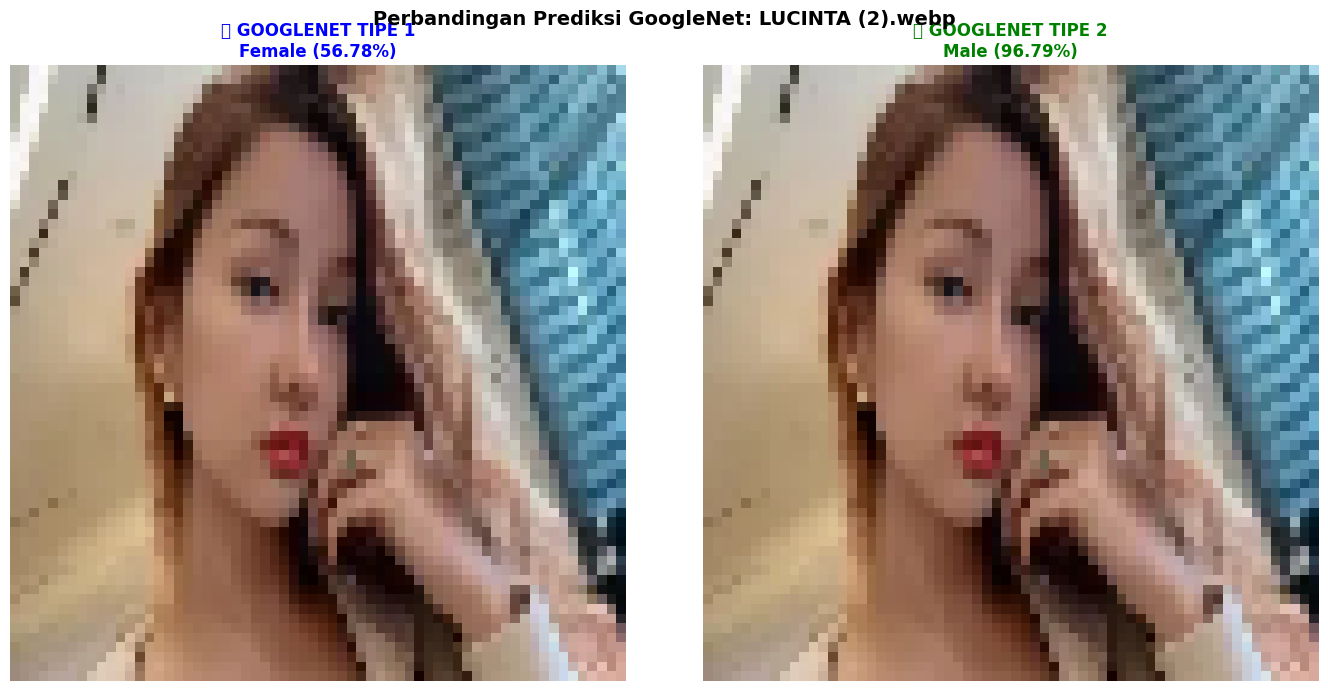


✅ Prediksi kedua model selesai!


In [63]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("="*60)
print("🔵🟢 TEST PREDIKSI - GOOGLENET TIPE 1 & TIPE 2")
print("="*60)
print("Upload gambar sekali, test di kedua model sekaligus")
print("-"*60)

# Upload gambar dari komputer lokal
uploaded = files.upload()

# Simpan hasil prediksi untuk perbandingan
predictions_comparison = []

# Proses setiap gambar yang diupload
for fn in uploaded.keys():
    print(f'\n{"="*60}')
    print(f'📷 Memproses gambar: "{fn}"')
    print(f'Ukuran file: {len(uploaded[fn]):,} bytes')
    print(f'{"="*60}')

    # Baca gambar
    image_path = fn
    img = cv2.imread(image_path)

    if img is None:
        print(f"❌ Error: Tidak dapat membaca gambar {image_path}")
        continue

    # === PREPROCESSING (SAMA DENGAN TRAINING) ===

    # 1. Resize ke ukuran input model (64x64)
    target_size = (64, 64)
    img_resized = cv2.resize(img, target_size)

    # 2. Konversi BGR (OpenCV) ke RGB (sesuai training)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # 3. Normalisasi: ubah range piksel dari [0, 255] ke [0, 1]
    img_normalized = img_rgb.astype('float32') / 255.0

    # 4. Tambah dimensi batch: (64, 64, 3) -> (1, 64, 64, 3)
    img_input = np.expand_dims(img_normalized, axis=0)

    # === PREDIKSI DENGAN KEDUA MODEL ===
    results = {}

    # Prediksi Model Tipe 1
    if 'model_type1' in globals():
        pred1 = model_type1.predict(img_input, verbose=0)
        prob_male_1 = pred1[0][0]
        class_1 = "Male" if prob_male_1 > 0.5 else "Female"
        conf_1 = prob_male_1 if prob_male_1 > 0.5 else (1 - prob_male_1)
        results['type1'] = {
            'prob_male': prob_male_1,
            'class': class_1,
            'confidence': conf_1
        }
    else:
        print("⚠️  Model Tipe 1 tidak ditemukan, skip prediksi Tipe 1")

    # Prediksi Model Tipe 2
    if 'model_type2' in globals():
        pred2 = model_type2.predict(img_input, verbose=0)
        prob_male_2 = pred2[0][0]
        class_2 = "Male" if prob_male_2 > 0.5 else "Female"
        conf_2 = prob_male_2 if prob_male_2 > 0.5 else (1 - prob_male_2)
        results['type2'] = {
            'prob_male': prob_male_2,
            'class': class_2,
            'confidence': conf_2
        }
    else:
        print("⚠️  Model Tipe 2 tidak ditemukan, skip prediksi Tipe 2")

    # Simpan hasil untuk tabel perbandingan
    if 'type1' in results and 'type2' in results:
        predictions_comparison.append({
            'filename': fn,
            'type1_prob_male': results['type1']['prob_male'],
            'type1_class': results['type1']['class'],
            'type1_conf': results['type1']['confidence'],
            'type2_prob_male': results['type2']['prob_male'],
            'type2_class': results['type2']['class'],
            'type2_conf': results['type2']['confidence']
        })

    # === TAMPILKAN HASIL SIDE-BY-SIDE ===
    print(f"\n📊 HASIL PREDIKSI UNTUK: {fn}")
    print(f"="*60)

    if 'type1' in results:
        print(f"🔵 GOOGLENET TIPE 1 (Lightweight):")
        print(f"   Prediksi: {results['type1']['class']}")
        print(f"   Prob Male: {results['type1']['prob_male']:.4f} ({results['type1']['prob_male']*100:.2f}%)")
        print(f"   Confidence: {results['type1']['confidence']:.4f} ({results['type1']['confidence']*100:.2f}%)")

    if 'type2' in results:
        print(f"\n🟢 GOOGLENET TIPE 2 (Heavy):")
        print(f"   Prediksi: {results['type2']['class']}")
        print(f"   Prob Male: {results['type2']['prob_male']:.4f} ({results['type2']['prob_male']*100:.2f}%)")
        print(f"   Confidence: {results['type2']['confidence']:.4f} ({results['type2']['confidence']*100:.2f}%)")

    # Cek apakah prediksi sama atau beda
    if 'type1' in results and 'type2' in results:
        if results['type1']['class'] == results['type2']['class']:
            print(f"\n✅ KEDUA MODEL SEPAKAT: {results['type1']['class']}")
        else:
            print(f"\n⚠️  PREDIKSI BERBEDA!")
            print(f"   Tipe 1: {results['type1']['class']} ({results['type1']['confidence']*100:.2f}%)")
            print(f"   Tipe 2: {results['type2']['class']} ({results['type2']['confidence']*100:.2f}%)")

    print(f"="*60)

    # === VISUALISASI SIDE-BY-SIDE ===
    if 'type1' in results and 'type2' in results:
        fig, axes = plt.subplots(1, 2, figsize=(14, 7))

        # Model Tipe 1
        axes[0].imshow(img_rgb)
        axes[0].set_title(f"🔵 GOOGLENET TIPE 1\n{results['type1']['class']} ({results['type1']['confidence']*100:.2f}%)",
                          fontsize=12, fontweight='bold', color='blue')
        axes[0].axis('off')

        # Model Tipe 2
        axes[1].imshow(img_rgb)
        axes[1].set_title(f"🟢 GOOGLENET TIPE 2\n{results['type2']['class']} ({results['type2']['confidence']*100:.2f}%)",
                          fontsize=12, fontweight='bold', color='green')
        axes[1].axis('off')

        plt.suptitle(f"Perbandingan Prediksi GoogleNet: {fn}", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

print("\n" + "="*60)
print("✅ Prediksi kedua model selesai!")
print("="*60)

# ResNet

## Setup Kaggle di Colab

In [1]:
# Install Kaggle
!pip install kaggle -q
import os
import sys

# Buat direktori .kaggle jika belum ada
!mkdir -p ~/.kaggle

# Cek apakah file kaggle.json sudah diupload
if os.path.exists('/content/kaggle.json'):
    # Pindahkan kaggle.json ke direktori .kaggle
    !mv /content/kaggle.json ~/.kaggle/
    # Set permission file agar secure
    !chmod 600 ~/.kaggle/kaggle.json
    print("kaggle.json berhasil dikonfigurasi.")
else:
    print("kaggle.json tidak ditemukan di /content/. Silakan upload file kaggle.json terlebih dahulu.")

kaggle.json berhasil dikonfigurasi.


## Download Dataset dari Kaggle

In [2]:
# Download dataset CelebA 64x64 dari Kaggle
!kaggle datasets download -d therealcyberlord/50k-celeba-dataset-64x64

Dataset URL: https://www.kaggle.com/datasets/therealcyberlord/50k-celeba-dataset-64x64
License(s): unknown
  0% 0.00/78.1M [00:00<?, ?B/s]
100% 78.1M/78.1M [00:00<00:00, 1.63GB/s]


## Extract Dataset

In [3]:
import zipfile
import os

# Path file zip yang telah didownload
zip_file_path = '/content/50k-celeba-dataset-64x64.zip'

# Direktori tujuan ekstraksi
extracted_path = '/content/celeba_dataset_kaggle/'

# Buat folder ekstraksi jika belum ada
os.makedirs(extracted_path, exist_ok=True)

# Ekstrak file zip
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print("Dataset berhasil diekstrak.")
except FileNotFoundError:
    print(f"Error: File {zip_file_path} tidak ditemukan. Pastikan download berhasil.")
except zipfile.BadZipFile:
    print(f"Error: File {zip_file_path} bukan zip yang valid. Download mungkin corrupt.")
except Exception as e:
    print(f"Error saat ekstraksi: {e}")

Dataset berhasil diekstrak.


## Cek Isi Folder

In [4]:
import os

# Tampilkan isi direktori hasil ekstraksi
extracted_path = '/content/celeba_dataset_kaggle/'
print("Isi folder ekstraksi:")
print(os.listdir(extracted_path))

Isi folder ekstraksi:
['50k']


## Download Attribute File (Label)


In [5]:
# Download file atribut dari GitHub (alternatif jika gagal)
# Opsional: Bisa juga download manual dari Google Drive
# Link Google Drive: https://drive.google.com/drive/folders/1AA21MR8GeQdnOVgmNcbxCrbAjL1udj0l

import requests
import os

# URL file atribut CelebA
attribute_file_url = "https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt"
attribute_file_path = "/content/list_attr_celeba.txt"

print(f"Mencoba download file atribut dari: {attribute_file_url}")

try:
    response = requests.get(attribute_file_url, stream=True)
    response.raise_for_status()  # Raise error jika status 4xx atau 5xx

    with open(attribute_file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"File atribut berhasil didownload ke: {attribute_file_path}")

except requests.exceptions.RequestException as e:
    print(f"Error saat download file atribut: {e}")
    print("Tidak dapat mendownload file dari URL yang diberikan.")
    print("Silakan download manual dari Google Drive dan upload ke Colab.")
except Exception as e:
    print(f"Error saat memproses file atribut: {e}")

Mencoba download file atribut dari: https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt
Error saat download file atribut: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt
Tidak dapat mendownload file dari URL yang diberikan.
Silakan download manual dari Google Drive dan upload ke Colab.


## Import Library

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
import os

print("✅ Library berhasil diimport")
print(f"TensorFlow version: {tf.__version__}")

✅ Library berhasil diimport
TensorFlow version: 2.19.0


## Load Dataset & Preprocessing

In [7]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split

# Path direktori gambar dan file atribut
img_dir = "/content/celeba_dataset_kaggle/50k"
attr_path = "/content/list_attr_celeba.txt"

print("="*60)
print("🔵 RESNET TIPE 1 - LIGHTWEIGHT (Transfer Learning)")
print("="*60)
print("Memulai loading dataset...")

# === VALIDASI DIREKTORI GAMBAR ===
if not os.path.exists(img_dir):
    print(f"❌ Error: Direktori gambar tidak ditemukan di {img_dir}")
    images, labels = np.array([]), np.array([])
else:
    # List semua file gambar
    image_files_in_dir = [f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')]

    if not image_files_in_dir:
        print(f"❌ Error: Tidak ada file gambar di {img_dir}")
        images, labels = np.array([]), np.array([])
    else:
        print(f"✅ Ditemukan {len(image_files_in_dir)} file gambar di {img_dir}")

        # === LOAD FILE ATRIBUT ===
        try:
            # Load attribute file (skip baris pertama = jumlah total, gunakan kolom pertama sebagai index)
            attributes = pd.read_csv(attr_path, skiprows=1, sep=r'\s+', index_col=0)
            print(f"✅ File atribut berhasil diload dari {attr_path}")

            # === SAMPLE DATA ===
            # Untuk ResNet, gunakan sample lebih kecil karena model lebih berat
            sample_size = 2000  # Lebih ringan untuk Colab Free

            # Filter: hanya ambil yang ada gambarnya
            available_image_ids = [os.path.basename(f) for f in image_files_in_dir]
            attributes_available = attributes[attributes.index.isin(available_image_ids)]

            if len(attributes_available) < sample_size:
                print(f"⚠️  Warning: Hanya {len(attributes_available)} gambar dengan atribut tersedia.")
                print(f"   Loading semua data yang tersedia.")
                sample_data = attributes_available
            else:
                sample_data = attributes_available.sample(sample_size, random_state=42)

            print(f"\n📦 Sample data: {len(sample_data)} gambar")

            # === LOAD & PREPROCESS GAMBAR ===
            images = []
            labels = []

            print("\n🔄 Loading dan preprocessing gambar...")
            for idx, (filename, row) in enumerate(sample_data.iterrows()):
                img_path = os.path.join(img_dir, filename)
                img = cv2.imread(img_path)

                if img is not None:
                    # Resize ke 128x128 (input ResNet50)
                    # ResNet biasanya pakai 224x224, tapi 128x128 cukup untuk Colab Free
                    img = cv2.resize(img, (128, 128))

                    # Konversi BGR ke RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # Normalisasi ke [0, 1]
                    img = img / 255.0

                    images.append(img)
                    labels.append(1 if row['Male'] == 1 else 0)
                else:
                    print(f"⚠️  Warning: Tidak dapat load {img_path}")

                # Progress indicator setiap 200 gambar
                if (idx + 1) % 200 == 0:
                    print(f"   Progress: {idx + 1}/{len(sample_data)} gambar")

            # Konversi ke numpy array
            images = np.array(images)
            labels = np.array(labels)

            print(f"\n{'='*60}")
            print("✅ BERHASIL LOAD DATA")
            print(f"{'='*60}")
            print(f"Total gambar: {len(images)}")
            print(f"Shape gambar: {images.shape}")
            print(f"Shape label: {labels.shape}")
            print(f"Range nilai piksel: [{images.min():.2f}, {images.max():.2f}]")
            print(f"Distribusi label: Female={int((labels==0).sum())}, Male={int((labels==1).sum())}")
            print(f"{'='*60}")

        except FileNotFoundError:
            print(f"❌ Error: File atribut tidak ditemukan di {attr_path}")
            print("   Pastikan file sudah diupload/extract dengan benar.")
            images, labels = np.array([]), np.array([])
        except KeyError:
            print(f"❌ Error: Kolom 'Male' tidak ditemukan di file atribut.")
            images, labels = np.array([]), np.array([])
        except Exception as e:
            print(f"❌ Error tidak terduga saat loading data: {e}")
            images, labels = np.array([]), np.array([])

# === SPLIT DATA ===
if len(images) > 0:
    print("\n🔄 Melakukan split data...")

    train_images, val_images, train_labels, val_labels = train_test_split(
        images, labels,
        test_size=0.2,       # 20% untuk validation
        random_state=42,     # Reproducibility
        stratify=labels      # Jaga keseimbangan kelas
    )

    print(f"\n{'='*60}")
    print("=== Hasil Split Data ===")
    print(f"{'='*60}")
    print(f"Training set   : {train_images.shape}")
    print(f"Validation set : {val_images.shape}")
    print(f"Training labels: {train_labels.shape}")
    print(f"Validation labels: {val_labels.shape}")
    print(f"\nDistribusi Training   - Female: {(train_labels==0).sum()}, Male: {(train_labels==1).sum()}")
    print(f"Distribusi Validation - Female: {(val_labels==0).sum()}, Male: {(val_labels==1).sum()}")
    print(f"{'='*60}")
    print("\n✅ Data ready untuk training!")

else:
    print("\n❌ Data loading gagal. Tidak dapat melanjutkan.")
    train_images, val_images, train_labels, val_labels = None, None, None, None

🔵 RESNET TIPE 1 - LIGHTWEIGHT (Transfer Learning)
Memulai loading dataset...
✅ Ditemukan 50000 file gambar di /content/celeba_dataset_kaggle/50k
✅ File atribut berhasil diload dari /content/list_attr_celeba.txt

📦 Sample data: 2000 gambar

🔄 Loading dan preprocessing gambar...
   Progress: 200/2000 gambar
   Progress: 400/2000 gambar
   Progress: 600/2000 gambar
   Progress: 800/2000 gambar
   Progress: 1000/2000 gambar
   Progress: 1200/2000 gambar
   Progress: 1400/2000 gambar
   Progress: 1600/2000 gambar
   Progress: 1800/2000 gambar
   Progress: 2000/2000 gambar

✅ BERHASIL LOAD DATA
Total gambar: 2000
Shape gambar: (2000, 128, 128, 3)
Shape label: (2000,)
Range nilai piksel: [0.00, 1.00]
Distribusi label: Female=1164, Male=836

🔄 Melakukan split data...

=== Hasil Split Data ===
Training set   : (1600, 128, 128, 3)
Validation set : (400, 128, 128, 3)
Training labels: (1600,)
Validation labels: (400,)

Distribusi Training   - Female: 931, Male: 669
Distribusi Validation - Female: 

## ResNet - V1

### Build Model ResNet

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def build_resnet_light(input_shape=(128, 128, 3), learning_rate=0.001, dropout_rate=0.2):
    """
    Membangun ResNet50 dengan Transfer Learning untuk binary classification

    Args:
        input_shape: Ukuran input image (height, width, channels)
        learning_rate: Learning rate untuk optimizer
        dropout_rate: Dropout rate untuk regularisasi

    Returns:
        model: ResNet50 model yang sudah dikompilasi
    """
    print("Membangun ResNet50 dengan Transfer Learning...")

    # === LOAD PRETRAINED RESNET50 ===
    # weights='imagenet': Gunakan weights dari ImageNet (pretrained)
    # include_top=False: Buang layer klasifikasi terakhir (1000 kelas ImageNet)
    # input_shape: Ukuran input 128x128 RGB (disesuaikan dengan parameter)
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # === FREEZE BASE MODEL ===
    # Transfer Learning: Freeze semua layer ResNet50
    # Hanya train layer custom yang kita tambahkan
    # Ini membuat training lebih cepat dan butuh data lebih sedikit
    base_model.trainable = False

    print(f"ResNet50 base model loaded (frozen)")
    print(f"Total layers di base model: {len(base_model.layers)}")
    print(f"Input shape: {input_shape}")

    # === CUSTOM LAYERS ===
    # GlobalAveragePooling2D: Mengambil rata-rata nilai tiap feature map
    # Alternatif dari Flatten, lebih efisien dan reduce overfitting
    x = GlobalAveragePooling2D()(base_model.output)

    # Dropout: Regularisasi untuk cegah overfitting
    x = Dropout(dropout_rate)(x)

    # Output layer: Binary classification (Male/Female)
    # Sigmoid activation untuk output probabilitas 0-1
    output = Dense(1, activation='sigmoid')(x)

    # === BUILD MODEL ===
    model = Model(inputs=base_model.input, outputs=output)

    # === COMPILE MODEL ===
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

print("="*60)
print("🔵 BUILD MODEL RESNET - TIPE 1 (LIGHTWEIGHT)")
print("="*60)

# Build model dengan hyperparameter Tipe 1
# Input shape 128x128 sesuai dengan ResNet50 pretrained ImageNet
model_type1 = build_resnet_light(
    input_shape=(128, 128, 3),  # Input size 128x128 RGB
    learning_rate=0.001,        # Learning rate standard
    dropout_rate=0.2            # Dropout rate rendah
)

print("\n=== Arsitektur Model ResNet Tipe 1 ===")
model_type1.summary()

# Hitung total parameter
total_params = model_type1.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model_type1.trainable_weights])
frozen_params = total_params - trainable_params

print(f"\n{'='*60}")
print(f"Total parameters    : {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} (layer custom)")
print(f"Frozen parameters   : {frozen_params:,} (ResNet50 base)")
print(f"{'='*60}")

print("\n📌 Note: Karena Transfer Learning, hanya {:.2f}% parameter yang dilatih".format(
    (trainable_params / total_params) * 100
))

print("\n📊 REASONING - ResNet Tipe 1:")
print("-"*60)
print("""
- Transfer Learning with ResNet50:
  → Pretrained weights dari ImageNet (1.4M images, 1000 classes)
  → Skip connection architecture (mengatasi vanishing gradient)
  → 50 layers depth dengan residual blocks

- Input Size: 128x128
  → ResNet50 standard untuk ImageNet: 224x224
  → Diperkecil jadi 128x128 untuk efisiensi Colab Free
  → Trade-off: Sedikit kehilangan detail, tapi lebih cepat

- Frozen Base Model:
  → Semua 50 layer ResNet di-freeze (tidak dilatih)
  → Hanya train GlobalAvgPooling + Dropout + Dense
  → ~99.9% parameter frozen, hanya ~0.1% yang dilatih
  → Butuh data lebih sedikit, training sangat cepat

- Custom Layers:
  → GlobalAveragePooling2D: Reduce spatial dimensions
  → Dropout (0.2): Regularisasi ringan
  → Dense (1, sigmoid): Binary output

✅ KELEBIHAN:
  • Training sangat cepat (hanya train 2-3 layer)
  • Butuh data lebih sedikit
  • Pretrained features dari ImageNet powerful untuk face recognition

⚠️ KEKURANGAN:
  • Tidak optimal untuk domain spesifik (faces vs general objects)
  • Frozen layers tidak bisa adapt ke dataset kita
""")
print("="*60)

🔵 BUILD MODEL RESNET - TIPE 1 (LIGHTWEIGHT)
Membangun ResNet50 dengan Transfer Learning...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
ResNet50 base model loaded (frozen)
Total layers di base model: 175
Input shape: (128, 128, 3)

=== Arsitektur Model ResNet Tipe 1 ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


Total parameters    : 23,589,761
Trainable parameters: 2,049 (layer custom)
Frozen parameters   : 23,587,712 (ResNet50 base)

📌 Note: Karena Transfer Learning, hanya 0.01% parameter yang dilatih

📊 REASONING - ResNet Tipe 1:
------------------------------------------------------------

- Transfer Learning with ResNet50:
  → Pretrained weights dari ImageNet (1.4M images, 1000 classes)
  → Skip connection architecture (mengatasi vanishing gradient)
  → 50 layers depth dengan residual blocks

- Input Size: 128x128
  → ResNet50 standard untuk ImageNet: 224x224
  → Diperkecil jadi 128x128 untuk efisiensi Colab Free
  → Trade-off: Sedikit kehilangan detail, tapi lebih cepat

- Frozen Base Model:
  → Semua 50 layer ResNet di-freeze (tidak dilatih)
  → Hanya train GlobalAvgPooling + Dropout + Dense
  → ~99.9% parameter frozen, hanya ~0.1% yang dilatih
  → Butuh data lebih sedikit, training sangat cepat

- Custom Layers:
  → GlobalAveragePooling2D: Reduce spatial dimensions
  → Dropout (0.2): 

### Compile & Train Model

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
import time
import cv2
import numpy as np

# ========================================
# 📊 RESIZE IMAGES - 64x64 → 128x128
# ========================================
print("="*60)
print("🔄 RESIZE IMAGES - 64x64 → 128x128")
print("="*60)
print(f"Original training shape  : {train_images.shape}")
print(f"Original validation shape: {val_images.shape}")

# Resize training images
print("\n📊 Resizing training images...")
train_images_128 = np.array([cv2.resize(img, (128, 128)) for img in train_images])
train_images_128 = train_images_128.astype('float32') / 255.0

# Resize validation images
print("📊 Resizing validation images...")
val_images_128 = np.array([cv2.resize(img, (128, 128)) for img in val_images])
val_images_128 = val_images_128.astype('float32') / 255.0

print("\n✅ Resize selesai!")
print(f"New training shape  : {train_images_128.shape}")
print(f"New validation shape: {val_images_128.shape}")
print("="*60)

# ========================================
# 🔄 REBUILD MODEL (FRESH START)
# ========================================
print("\n🔄 Rebuilding model untuk avoid TensorFlow graph conflict...")

# Clear backend
import tensorflow.keras.backend as K
K.clear_session()

# Rebuild model from scratch
model_type1 = build_resnet_light(
    input_shape=(128, 128, 3),
    learning_rate=0.001,
    dropout_rate=0.3  # ✅ SESUAI TABEL
)

print("✅ Model rebuilt successfully!")

# ========================================
# 🔵 KONFIGURASI TRAINING TIPE 1
# ========================================
config_name = "Lightweight - Transfer Learning"
batch_size_type1 = 32
epochs_type1 = 10

print("\n" + "="*60)
print("🔵 TRAINING RESNET - TIPE 1 (LIGHTWEIGHT)")
print("="*60)
print(f"Konfigurasi: {config_name}")
print("-"*60)
print(f"Epochs: {epochs_type1}")
print(f"Batch Size: {batch_size_type1}")
print(f"Learning Rate: 0.001")
print(f"Dropout Rate: 0.3")  # ✅ FIXED! Sesuai tabel
print(f"Input Size: 128x128x3")
print("-"*60)
print(f"Total training samples: {len(train_images_128):,}")
print(f"Total validation samples: {len(val_images_128):,}")
print(f"Steps per epoch: {len(train_images_128) // batch_size_type1}")
print(f"Total steps: {(len(train_images_128) // batch_size_type1) * epochs_type1}")
print("="*60)

print("\n📌 REASONING TIPE 1 (Lightweight - Transfer Learning):")
print("-"*60)
print("""
- Transfer Learning: Gunakan ResNet50 pretrained dari ImageNet
  → Freeze semua layer ResNet50 (tidak dilatih)
  → Hanya train layer custom (GlobalAvgPooling + Dense)
  → Butuh data lebih sedikit, training lebih cepat

- Input Size: 128x128
  → ResNet50 pretrained pakai ImageNet (standard 224x224)
  → Diperkecil jadi 128x128 untuk efisiensi Colab Free
  → Data di-resize dari 64x64 menggunakan cv2.resize()
  → Trade-off: Sedikit kehilangan detail, tapi lebih cepat

- Batch Size: 32
  → Standard batch size untuk transfer learning
  → Balance antara memory usage & training stability
  → Cukup untuk update gradient yang reliable

- Epochs: 10
  → Cukup untuk transfer learning (biasanya konvergen cepat)
  → EarlyStopping akan stop jika tidak ada improvement
  → Pretrained model sudah punya knowledge dari ImageNet

- Dropout: 0.3
  → Standard regularization untuk V1 pattern
  → Konsisten dengan VGG V1, GoogleNet V1, AlexNet V1
  → Balance antara underfitting dan overfitting

- ResNet vs VGG vs GoogleNet:
  → ResNet: Skip connection, lebih dalam (50 layers), pretrained
  → VGG: Simple stack 3x3, train from scratch
  → GoogleNet: Inception module, train from scratch
  → ResNet: Paling efisien dengan transfer learning

✅ COCOK UNTUK: Quick deployment dengan pretrained model
""")
print("="*60)

# ========================================
# ⚙️ EARLY STOPPING CALLBACK
# ========================================
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

# ========================================
# 🚀 TRAINING MODEL
# ========================================
start_time = time.time()

print("\n🚀 Training ResNet Tipe 1 dimulai...")
print("-"*60)

# Train model dengan data yang sudah di-resize ke 128x128
history_type1 = model_type1.fit(
    train_images_128,
    train_labels,
    validation_data=(val_images_128, val_labels),
    epochs=epochs_type1,
    batch_size=batch_size_type1,
    callbacks=[early_stop],
    verbose=1
)

# Hitung durasi training
end_time = time.time()
training_duration_type1 = end_time - start_time

# ========================================
# ✅ SUMMARY HASIL TRAINING
# ========================================
print("\n" + "="*60)
print("✅ TRAINING RESNET TIPE 1 SELESAI!")
print("="*60)
print(f"⏱️  Waktu training: {training_duration_type1:.2f} detik ({training_duration_type1/60:.2f} menit)")
print(f"📊 Final Training Accuracy: {history_type1.history['accuracy'][-1]:.4f} ({history_type1.history['accuracy'][-1]*100:.2f}%)")
print(f"📊 Final Validation Accuracy: {history_type1.history['val_accuracy'][-1]:.4f} ({history_type1.history['val_accuracy'][-1]*100:.2f}%)")
print(f"🛑 Early stopped at epoch: {len(history_type1.history['loss'])}/{epochs_type1}")
print("-"*60)

# Deteksi overfitting
gap = history_type1.history['accuracy'][-1] - history_type1.history['val_accuracy'][-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

🔄 RESIZE IMAGES - 64x64 → 128x128
Original training shape  : (1600, 128, 128, 3)
Original validation shape: (400, 128, 128, 3)

📊 Resizing training images...
📊 Resizing validation images...

✅ Resize selesai!
New training shape  : (1600, 128, 128, 3)
New validation shape: (400, 128, 128, 3)

🔄 Rebuilding model untuk avoid TensorFlow graph conflict...
Membangun ResNet50 dengan Transfer Learning...
ResNet50 base model loaded (frozen)
Total layers di base model: 175
Input shape: (128, 128, 3)
✅ Model rebuilt successfully!

🔵 TRAINING RESNET - TIPE 1 (LIGHTWEIGHT)
Konfigurasi: Lightweight - Transfer Learning
------------------------------------------------------------
Epochs: 10
Batch Size: 32
Learning Rate: 0.001
Dropout Rate: 0.3
Input Size: 128x128x3
------------------------------------------------------------
Total training samples: 1,600
Total validation samples: 400
Steps per epoch: 50
Total steps: 500

📌 REASONING TIPE 1 (Lightweight - Transfer Learning):
---------------------------

### Plot Training History

/tmp/ipython-input-1470404927.py:33: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


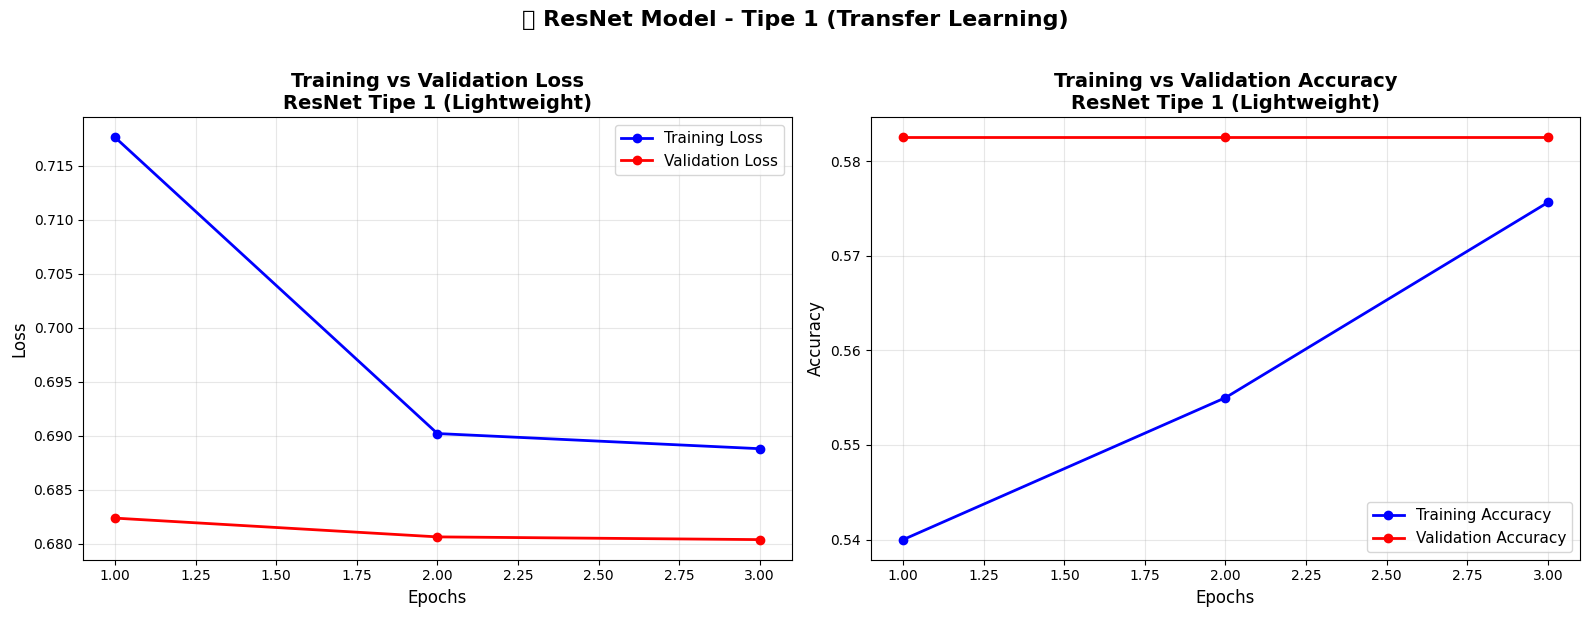


📊 SUMMARY HASIL TRAINING - RESNET TIPE 1
Epochs: 10 | Batch Size: 32 | LR: 0.001
Actual Epochs Run: 3
------------------------------------------------------------
Final Training Loss      : 0.6888
Final Training Accuracy  : 0.5756 (57.56%)
Final Validation Loss    : 0.6804
Final Validation Accuracy: 0.5825 (58.25%)
Training Duration        : 41.72s (0.70 min)
------------------------------------------------------------
✅ Model balance - tidak ada overfitting/underfitting signifikan


In [10]:
import matplotlib.pyplot as plt

# Ambil data history dari training
loss_values_type1 = history_type1.history['loss']
val_loss_values_type1 = history_type1.history['val_loss']
accuracy_values_type1 = history_type1.history['accuracy']
val_accuracy_values_type1 = history_type1.history['val_accuracy']

epochs_range = range(1, len(loss_values_type1) + 1)

# Buat figure dengan 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Loss
axes[0].plot(epochs_range, loss_values_type1, 'bo-', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(epochs_range, val_loss_values_type1, 'ro-', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_title('Training vs Validation Loss\nResNet Tipe 1 (Lightweight)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Subplot 2: Accuracy
axes[1].plot(epochs_range, accuracy_values_type1, 'bo-', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].plot(epochs_range, val_accuracy_values_type1, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
axes[1].set_title('Training vs Validation Accuracy\nResNet Tipe 1 (Lightweight)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('🔴 ResNet Model - Tipe 1 (Transfer Learning)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tampilkan summary hasil training
print("\n" + "="*60)
print("📊 SUMMARY HASIL TRAINING - RESNET TIPE 1")
print("="*60)
print(f"Epochs: {epochs_type1} | Batch Size: {batch_size_type1} | LR: 0.001")
print(f"Actual Epochs Run: {len(loss_values_type1)}")
print("-"*60)
print(f"Final Training Loss      : {loss_values_type1[-1]:.4f}")
print(f"Final Training Accuracy  : {accuracy_values_type1[-1]:.4f} ({accuracy_values_type1[-1]*100:.2f}%)")
print(f"Final Validation Loss    : {val_loss_values_type1[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy_values_type1[-1]:.4f} ({val_accuracy_values_type1[-1]*100:.2f}%)")
print(f"Training Duration        : {training_duration_type1:.2f}s ({training_duration_type1/60:.2f} min)")
print("-"*60)

# Deteksi overfitting
gap = accuracy_values_type1[-1] - val_accuracy_values_type1[-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

### Evaluate Model

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("📈 EVALUASI MODEL RESNET - TIPE 1")
print("="*60)

# === EVALUATE PADA VALIDATION SET ===
# PENTING: Pakai val_images_128 (yang sudah di-resize), bukan val_images!
loss_type1, accuracy_type1 = model_type1.evaluate(val_images_128, val_labels, verbose=1)

print("\n" + "="*60)
print("📊 HASIL EVALUASI FINAL - RESNET TIPE 1")
print("="*60)
print(f"Validation Loss    : {loss_type1:.4f}")
print(f"Validation Accuracy: {accuracy_type1:.4f} ({accuracy_type1*100:.2f}%)")
print("="*60)

# Interpretasi hasil
print("\n" + "="*60)
if accuracy_type1 > 0.85:
    print("✅ Model ResNet Tipe 1 memiliki performa BAIK!")
elif accuracy_type1 > 0.75:
    print("⚠️  Model ResNet Tipe 1 cukup baik, masih bisa ditingkatkan.")
else:
    print("❌ Model ResNet Tipe 1 perlu perbaikan.")
print("="*60)

📈 EVALUASI MODEL RESNET - TIPE 1
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5837 - loss: 0.6818

📊 HASIL EVALUASI FINAL - RESNET TIPE 1
Validation Loss    : 0.6824
Validation Accuracy: 0.5825 (58.25%)

❌ Model ResNet Tipe 1 perlu perbaikan.


### Confusion Matrix & Classification Report

🔍 ANALISIS CONFUSION MATRIX - RESNET VERSI 1

📊 Melakukan prediksi pada validation set...
Total prediksi: 400
Shape y_true: (400,)
Shape y_pred: (400,)

🔢 Menghitung Confusion Matrix...

📋 CONFUSION MATRIX - RESNET VERSI 1

                    PREDICTED
                Female(0)    Male(1)
    ACTUAL
    Female(0)       233           0
    Male(1)         167           0


📊 DETAIL METRIK TP, TN, FP, FN:
✅ True Positive  (TP):    0 ( 0.00%)
   → Male diprediksi sebagai Male (BENAR)

✅ True Negative  (TN):  233 (58.25%)
   → Female diprediksi sebagai Female (BENAR)

❌ False Positive (FP):    0 ( 0.00%)
   → Female diprediksi sebagai Male (SALAH - Type I Error)

❌ False Negative (FN):  167 (41.75%)
   → Male diprediksi sebagai Female (SALAH - Type II Error)

------------------------------------------------------------
📌 Total Prediksi Benar:  233 (58.25%)
📌 Total Prediksi Salah:  167 (41.75%)

📈 METRIK PERFORMA LANJUTAN:
Accuracy         : 0.5825 (58.25%)
   → (TP + TN) / Total

Precisio

/tmp/ipython-input-111806804.py:180: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-111806804.py:180: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-111806804.py:180: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io

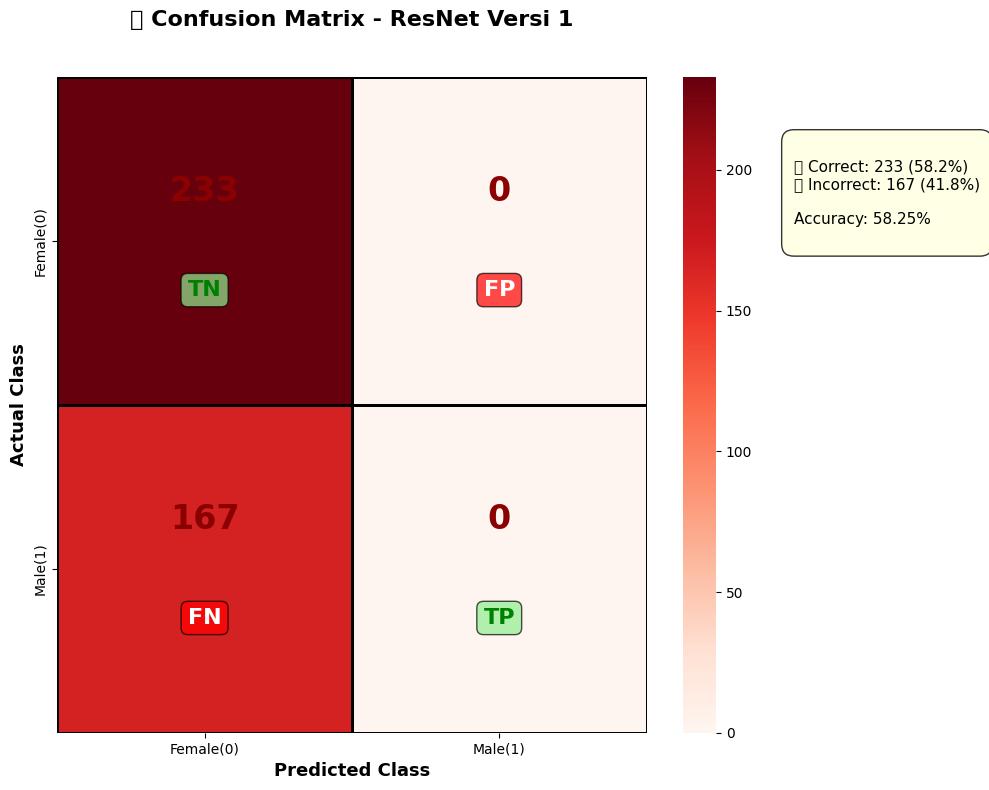


📄 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   Female(0)     0.5825    1.0000    0.7362       233
     Male(1)     0.0000    0.0000    0.0000       167

    accuracy                         0.5825       400
   macro avg     0.2913    0.5000    0.3681       400
weighted avg     0.3393    0.5825    0.4288       400


💡 INTERPRETASI HASIL:
⚠️  Model cenderung UNDER-PREDICT Male
   → 167 Male salah diprediksi sebagai Female
   → 0 Female salah diprediksi sebagai Male

📌 REKOMENDASI:
   - Adjust threshold dari 0.5 ke nilai lebih rendah (misal 0.4)
   - Tambah data augmentation untuk kelas Male

🎯 Overall Accuracy: 58.25%
   → POOR performance - perlu perbaikan signifikan

✅ Analisis ResNet Versi 1 selesai! Hasil disimpan ke 'results_resnet_v1'


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("🔍 ANALISIS CONFUSION MATRIX - RESNET VERSI 1")
print("="*60)

# ========================================
# 1️⃣ PREDIKSI PADA VALIDATION SET
# ========================================
print("\n📊 Melakukan prediksi pada validation set...")

# PENTING: Pakai val_images_128 (yang sudah di-resize)
y_pred_proba_resnet_v1 = model_type1.predict(val_images_128, verbose=0)

# Convert probabilitas ke binary predictions (threshold = 0.5)
y_pred_resnet_v1 = (y_pred_proba_resnet_v1 > 0.5).astype(int).flatten()

# Ground truth labels
y_true = val_labels.astype(int)

print(f"Total prediksi: {len(y_pred_resnet_v1)}")
print(f"Shape y_true: {y_true.shape}")
print(f"Shape y_pred: {y_pred_resnet_v1.shape}")

# ========================================
# 2️⃣ HITUNG CONFUSION MATRIX
# ========================================
print("\n🔢 Menghitung Confusion Matrix...")

cm_resnet_v1 = confusion_matrix(y_true, y_pred_resnet_v1)

# Extract TP, TN, FP, FN
TN_resnet_v1 = cm_resnet_v1[0, 0]  # True Negative (Female → Female)
FP_resnet_v1 = cm_resnet_v1[0, 1]  # False Positive (Female → Male)
FN_resnet_v1 = cm_resnet_v1[1, 0]  # False Negative (Male → Female)
TP_resnet_v1 = cm_resnet_v1[1, 1]  # True Positive (Male → Male)

total_resnet_v1 = TN_resnet_v1 + FP_resnet_v1 + FN_resnet_v1 + TP_resnet_v1

print("\n" + "="*60)
print("📋 CONFUSION MATRIX - RESNET VERSI 1")
print("="*60)
print(f"""
                    PREDICTED
                Female(0)    Male(1)
    ACTUAL
    Female(0)      {TN_resnet_v1:4d}        {FP_resnet_v1:4d}
    Male(1)        {FN_resnet_v1:4d}        {TP_resnet_v1:4d}
""")
print("="*60)

# ========================================
# 3️⃣ DETAIL METRIK
# ========================================
print("\n📊 DETAIL METRIK TP, TN, FP, FN:")
print("="*60)
print(f"✅ True Positive  (TP): {TP_resnet_v1:4d} ({TP_resnet_v1/total_resnet_v1*100:5.2f}%)")
print(f"   → Male diprediksi sebagai Male (BENAR)")
print()
print(f"✅ True Negative  (TN): {TN_resnet_v1:4d} ({TN_resnet_v1/total_resnet_v1*100:5.2f}%)")
print(f"   → Female diprediksi sebagai Female (BENAR)")
print()
print(f"❌ False Positive (FP): {FP_resnet_v1:4d} ({FP_resnet_v1/total_resnet_v1*100:5.2f}%)")
print(f"   → Female diprediksi sebagai Male (SALAH - Type I Error)")
print()
print(f"❌ False Negative (FN): {FN_resnet_v1:4d} ({FN_resnet_v1/total_resnet_v1*100:5.2f}%)")
print(f"   → Male diprediksi sebagai Female (SALAH - Type II Error)")
print()
print("-"*60)
print(f"📌 Total Prediksi Benar: {TP_resnet_v1 + TN_resnet_v1:4d} ({(TP_resnet_v1+TN_resnet_v1)/total_resnet_v1*100:5.2f}%)")
print(f"📌 Total Prediksi Salah: {FP_resnet_v1 + FN_resnet_v1:4d} ({(FP_resnet_v1+FN_resnet_v1)/total_resnet_v1*100:5.2f}%)")
print("="*60)

# ========================================
# 4️⃣ HITUNG METRIK TAMBAHAN
# ========================================
print("\n📈 METRIK PERFORMA LANJUTAN:")
print("="*60)

# Accuracy
accuracy_resnet_v1 = (TP_resnet_v1 + TN_resnet_v1) / total_resnet_v1
print(f"Accuracy         : {accuracy_resnet_v1:.4f} ({accuracy_resnet_v1*100:.2f}%)")
print(f"   → (TP + TN) / Total")
print()

# Precision (Male class)
precision_resnet_v1 = TP_resnet_v1 / (TP_resnet_v1 + FP_resnet_v1) if (TP_resnet_v1 + FP_resnet_v1) > 0 else 0
print(f"Precision (Male) : {precision_resnet_v1:.4f} ({precision_resnet_v1*100:.2f}%)")
print(f"   → TP / (TP + FP)")
print(f"   → Dari semua yang diprediksi Male, berapa yang benar?")
print()

# Recall / Sensitivity (Male class)
recall_resnet_v1 = TP_resnet_v1 / (TP_resnet_v1 + FN_resnet_v1) if (TP_resnet_v1 + FN_resnet_v1) > 0 else 0
print(f"Recall (Male)    : {recall_resnet_v1:.4f} ({recall_resnet_v1*100:.2f}%)")
print(f"   → TP / (TP + FN)")
print(f"   → Dari semua Male sebenarnya, berapa yang terdeteksi?")
print()

# Specificity (Female class)
specificity_resnet_v1 = TN_resnet_v1 / (TN_resnet_v1 + FP_resnet_v1) if (TN_resnet_v1 + FP_resnet_v1) > 0 else 0
print(f"Specificity (Female): {specificity_resnet_v1:.4f} ({specificity_resnet_v1*100:.2f}%)")
print(f"   → TN / (TN + FP)")
print(f"   → Dari semua Female sebenarnya, berapa yang terdeteksi?")
print()

# F1-Score (Male class)
f1_resnet_v1 = 2 * (precision_resnet_v1 * recall_resnet_v1) / (precision_resnet_v1 + recall_resnet_v1) if (precision_resnet_v1 + recall_resnet_v1) > 0 else 0
print(f"F1-Score (Male)  : {f1_resnet_v1:.4f}")
print(f"   → 2 × (Precision × Recall) / (Precision + Recall)")
print(f"   → Balance antara Precision dan Recall")
print()

# Error Rate
error_rate_resnet_v1 = (FP_resnet_v1 + FN_resnet_v1) / total_resnet_v1
print(f"Error Rate       : {error_rate_resnet_v1:.4f} ({error_rate_resnet_v1*100:.2f}%)")
print(f"   → (FP + FN) / Total")
print("="*60)

# ========================================
# 5️⃣ VISUALISASI CONFUSION MATRIX (1 PLOT AJA)
# ========================================
print("\n🎨 Membuat visualisasi Confusion Matrix...")

plt.figure(figsize=(10, 8))

# Buat heatmap dengan annotasi custom
ax = sns.heatmap(cm_resnet_v1, annot=False, fmt='d', cmap='Reds', cbar=True,
                 xticklabels=['Female(0)', 'Male(1)'],
                 yticklabels=['Female(0)', 'Male(1)'],
                 linewidths=2, linecolor='black')

# Tambahkan angka + label TP/TN/FP/FN di setiap cell
# Cell [0,0] - TN (True Negative)
ax.text(0.5, 0.35, f'{TN_resnet_v1}', ha='center', va='center',
        fontsize=24, color='darkred', weight='bold')
ax.text(0.5, 0.65, 'TN', ha='center', va='center',
        fontsize=16, color='green', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

# Cell [0,1] - FP (False Positive)
ax.text(1.5, 0.35, f'{FP_resnet_v1}', ha='center', va='center',
        fontsize=24, color='darkred', weight='bold')
ax.text(1.5, 0.65, 'FP', ha='center', va='center',
        fontsize=16, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))

# Cell [1,0] - FN (False Negative)
ax.text(0.5, 1.35, f'{FN_resnet_v1}', ha='center', va='center',
        fontsize=24, color='darkred', weight='bold')
ax.text(0.5, 1.65, 'FN', ha='center', va='center',
        fontsize=16, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))

# Cell [1,1] - TP (True Positive)
ax.text(1.5, 1.35, f'{TP_resnet_v1}', ha='center', va='center',
        fontsize=24, color='darkred', weight='bold')
ax.text(1.5, 1.65, 'TP', ha='center', va='center',
        fontsize=16, color='green', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

plt.title('🔴 Confusion Matrix - ResNet Versi 1\n',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual Class', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=13, fontweight='bold')

# Tambahkan legend keterangan
legend_text = f"""
✅ Correct: {TP_resnet_v1 + TN_resnet_v1} ({(TP_resnet_v1+TN_resnet_v1)/total_resnet_v1*100:.1f}%)
❌ Incorrect: {FP_resnet_v1 + FN_resnet_v1} ({(FP_resnet_v1+FN_resnet_v1)/total_resnet_v1*100:.1f}%)

Accuracy: {accuracy_resnet_v1*100:.2f}%
"""
plt.text(2.5, 0.5, legend_text, fontsize=11,
         bbox=dict(boxstyle='round,pad=0.8', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

# ========================================
# 6️⃣ CLASSIFICATION REPORT
# ========================================
print("\n📄 CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_true, y_pred_resnet_v1,
                          target_names=['Female(0)', 'Male(1)'],
                          digits=4))
print("="*60)

# ========================================
# 7️⃣ INTERPRETASI & REKOMENDASI
# ========================================
print("\n💡 INTERPRETASI HASIL:")
print("="*60)

if FP_resnet_v1 > FN_resnet_v1:
    print("⚠️  Model cenderung OVER-PREDICT Male")
    print(f"   → {FP_resnet_v1} Female salah diprediksi sebagai Male")
    print(f"   → {FN_resnet_v1} Male salah diprediksi sebagai Female")
    print("\n📌 REKOMENDASI:")
    print("   - Adjust threshold dari 0.5 ke nilai lebih tinggi (misal 0.6)")
    print("   - Tambah data augmentation untuk kelas Female")
    print("   - Gunakan class weights saat training")
elif FN_resnet_v1 > FP_resnet_v1:
    print("⚠️  Model cenderung UNDER-PREDICT Male")
    print(f"   → {FN_resnet_v1} Male salah diprediksi sebagai Female")
    print(f"   → {FP_resnet_v1} Female salah diprediksi sebagai Male")
    print("\n📌 REKOMENDASI:")
    print("   - Adjust threshold dari 0.5 ke nilai lebih rendah (misal 0.4)")
    print("   - Tambah data augmentation untuk kelas Male")
else:
    print("✅ Model balance dalam error distribution")
    print(f"   → FP: {FP_resnet_v1}, FN: {FN_resnet_v1}")

print()
print(f"🎯 Overall Accuracy: {accuracy_resnet_v1*100:.2f}%")
if accuracy_resnet_v1 > 0.90:
    print("   → EXCELLENT performance!")
elif accuracy_resnet_v1 > 0.80:
    print("   → GOOD performance!")
elif accuracy_resnet_v1 > 0.70:
    print("   → FAIR performance - masih bisa ditingkatkan")
else:
    print("   → POOR performance - perlu perbaikan signifikan")

print("="*60)

# ========================================
# 8️⃣ SIMPAN HASIL
# ========================================
results_resnet_v1 = {
    'confusion_matrix': cm_resnet_v1,
    'TP': TP_resnet_v1,
    'TN': TN_resnet_v1,
    'FP': FP_resnet_v1,
    'FN': FN_resnet_v1,
    'accuracy': accuracy_resnet_v1,
    'precision': precision_resnet_v1,
    'recall': recall_resnet_v1,
    'specificity': specificity_resnet_v1,
    'f1_score': f1_resnet_v1,
    'error_rate': error_rate_resnet_v1
}

print("\n✅ Analisis ResNet Versi 1 selesai! Hasil disimpan ke 'results_resnet_v1'")

## ResNet - V2

### Build Model ResNet

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_resnet_advanced(input_shape=(128, 128, 3), learning_rate=0.0001, dropout_rate=0.3):
    """
    Membangun ResNet50 dengan Transfer Learning + Fine-tuning untuk binary classification

    Args:
        input_shape: Ukuran input image (height, width, channels)
        learning_rate: Learning rate untuk optimizer (lebih kecil untuk fine-tuning)
        dropout_rate: Dropout rate untuk regularisasi

    Returns:
        model: ResNet50 model yang sudah dikompilasi
    """
    print("Membangun ResNet50 dengan Transfer Learning + Fine-tuning...")

    # === LOAD PRETRAINED RESNET50 ===
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # === FINE-TUNING: UNFREEZE BEBERAPA LAYER TERAKHIR ===
    # Freeze semua layer dulu
    base_model.trainable = True

    # Unfreeze hanya layer terakhir (conv5_block)
    # Total 175 layers, kita unfreeze ~30 layer terakhir
    fine_tune_at = 145  # Freeze layer 0-144, unfreeze 145-175

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    trainable_layers = sum([1 for layer in base_model.layers if layer.trainable])
    frozen_layers = len(base_model.layers) - trainable_layers

    print(f"ResNet50 base model loaded")
    print(f"Total layers: {len(base_model.layers)}")
    print(f"Frozen layers: {frozen_layers} (0-{fine_tune_at-1})")
    print(f"Trainable layers: {trainable_layers} ({fine_tune_at}-{len(base_model.layers)-1})")
    print(f"Input shape: {input_shape}")

    # === CUSTOM LAYERS ===
    x = GlobalAveragePooling2D()(base_model.output)

    # BatchNormalization untuk stabilitas training
    x = BatchNormalization()(x)

    # Dense layer dengan ReLU
    x = Dense(256, activation='relu')(x)

    # Dropout lebih tinggi untuk regularisasi
    x = Dropout(dropout_rate)(x)

    # Dense layer kedua (optional, untuk capacity lebih)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    # Output layer
    output = Dense(1, activation='sigmoid')(x)

    # === BUILD MODEL ===
    model = Model(inputs=base_model.input, outputs=output)

    # === COMPILE MODEL ===
    # Learning rate lebih kecil untuk fine-tuning
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

print("="*60)
print("🔴 BUILD MODEL RESNET - TIPE 2 (ADVANCED)")
print("="*60)

# Build model dengan hyperparameter Tipe 2
model_type2 = build_resnet_advanced(
    input_shape=(128, 128, 3),
    learning_rate=0.0001,  # LR lebih kecil untuk fine-tuning
    dropout_rate=0.3       # Dropout lebih tinggi
)

print("\n=== Arsitektur Model ResNet Tipe 2 ===")
model_type2.summary()

# Hitung total parameter
total_params = model_type2.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model_type2.trainable_weights])
frozen_params = total_params - trainable_params

print(f"\n{'='*60}")
print(f"Total parameters    : {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters   : {frozen_params:,}")
print(f"{'='*60}")

print("\n📌 Note: Fine-tuning ~{:.1f}% parameter (vs ~0.1% di Tipe 1)".format(
    (trainable_params / total_params) * 100
))

print("\n📊 REASONING - ResNet Tipe 2:")
print("-"*60)
print("""
- Fine-Tuning Strategy:
  → Unfreeze 30 layer terakhir ResNet50 (conv5_block)
  → Layer awal tetap frozen (low-level features generic)
  → Layer akhir di-train (high-level features domain-specific)

- Input Size: 128x128 (sama dengan Tipe 1)
  → Konsisten dengan Tipe 1 untuk fair comparison

- Custom Layers (lebih kompleks):
  → BatchNormalization: Stabilitas training
  → Dense(256) + ReLU: Capacity lebih tinggi
  → Dropout(0.3): Regularisasi lebih agresif
  → Dense(128) + ReLU: Second dense layer
  → Dropout(0.3)

- Learning Rate: 0.0001 (10x lebih kecil)
  → Fine-tuning butuh LR kecil
  → Avoid destroying pretrained weights
  → Converge lebih smooth tapi lebih lama

- Dropout: 0.3 (lebih tinggi)
  → Fine-tuning prone to overfitting
  → Dropout agresif untuk regularisasi

✅ KELEBIHAN vs Tipe 1:
  • Bisa adapt ke domain spesifik (faces)
  • Potensial akurasi lebih tinggi
  • Custom layers lebih powerful

⚠️ KEKURANGAN vs Tipe 1:
  • Training lebih lama
  • Butuh data lebih banyak
  • Risk overfitting lebih tinggi
""")
print("="*60)

🔴 BUILD MODEL RESNET - TIPE 2 (ADVANCED)
Membangun ResNet50 dengan Transfer Learning + Fine-tuning...
ResNet50 base model loaded
Total layers: 175
Frozen layers: 145 (0-144)
Trainable layers: 30 (145-174)
Input shape: (128, 128, 3)

=== Arsitektur Model ResNet Tipe 2 ===


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 24,153,473 (92.14 MB)

 Trainable params: 15,011,841 (57.27 MB)

 Non-trainable params: 9,141,632 (34.87 MB)


Total parameters    : 24,153,473
Trainable parameters: 15,011,841
Frozen parameters   : 9,141,632

📌 Note: Fine-tuning ~62.2% parameter (vs ~0.1% di Tipe 1)

📊 REASONING - ResNet Tipe 2:
------------------------------------------------------------

- Fine-Tuning Strategy:
  → Unfreeze 30 layer terakhir ResNet50 (conv5_block)
  → Layer awal tetap frozen (low-level features generic)
  → Layer akhir di-train (high-level features domain-specific)

- Input Size: 128x128 (sama dengan Tipe 1)
  → Konsisten dengan Tipe 1 untuk fair comparison

- Custom Layers (lebih kompleks):
  → BatchNormalization: Stabilitas training
  → Dense(256) + ReLU: Capacity lebih tinggi
  → Dropout(0.3): Regularisasi lebih agresif
  → Dense(128) + ReLU: Second dense layer
  → Dropout(0.3)

- Learning Rate: 0.0001 (10x lebih kecil)
  → Fine-tuning butuh LR kecil
  → Avoid destroying pretrained weights
  → Converge lebih smooth tapi lebih lama

- Dropout: 0.3 (lebih tinggi)
  → Fine-tuning prone to overfitting
  → Dr

### Compile & Train Model

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time
import tensorflow.keras.backend as K

# ========================================
# 🔄 REBUILD MODEL TIPE 2 (FRESH START)
# ========================================
print("\n🔄 Rebuilding ResNet Tipe 2 model...")

# Clear backend
K.clear_session()

# Rebuild model dengan LR 0.0001
model_type2 = build_resnet_advanced(
    input_shape=(128, 128, 3),
    learning_rate=0.0001,  # ✅ LR SESUAI V2
    dropout_rate=0.5       # ✅ FIXED! Sesuai tabel V2
)

print("✅ Model Tipe 2 rebuilt successfully!")

# ========================================
# 🔵 KONFIGURASI TRAINING TIPE 2
# ========================================
config_name = "Advanced - Fine-Tuning"
batch_size_type2 = 64   # ✅ Batch sesuai V2
epochs_type2 = 20       # ✅ Epochs sesuai V2

print("="*60)
print("🔴 TRAINING RESNET - TIPE 2 (ADVANCED)")
print("="*60)
print(f"Konfigurasi: {config_name}")
print("-"*60)
print(f"Epochs: {epochs_type2}")
print(f"Batch Size: {batch_size_type2}")
print(f"Learning Rate: 0.0001")
print(f"Dropout Rate: 0.5")  # ✅ FIXED! Sesuai tabel
print(f"Input Size: 128x128x3")
print("-"*60)
print(f"Total training samples: {len(train_images_128):,}")
print(f"Total validation samples: {len(val_images_128):,}")
print(f"Steps per epoch: {len(train_images_128) // batch_size_type2}")
print(f"Total steps: {(len(train_images_128) // batch_size_type2) * epochs_type2}")
print("="*60)

print("\n📌 REASONING TIPE 2 (Advanced - Fine-Tuning):")
print("-"*60)
print("""
- Fine-Tuning: Unfreeze 30 layer terakhir ResNet50
  → Layer awal (frozen): Generic features (edges, textures)
  → Layer akhir (trainable): Specific features (face structure)
  → Balance antara transfer learning & domain adaptation

- Input Size: 128x128
  → Sama dengan Tipe 1 untuk fair comparison
  → Data pakai train_images_128 & val_images_128 (sudah di-resize)

- Batch Size: 64
  → Fine-tuning benefit dari batch lebih besar
  → Gradient update lebih stabil
  → 2x dari V1 (32) untuk faster convergence

- Epochs: 20
  → Fine-tuning butuh lebih banyak epoch
  → 2x dari V1 (10) untuk full convergence
  → EarlyStopping tetap aktif (stop jika plateau)
  → ReduceLROnPlateau untuk adaptive learning rate

- Learning Rate: 0.0001
  → 10x lebih kecil dari V1 (0.001)
  → Fine-tuning butuh LR kecil untuk preserve pretrained weights
  → ReduceLROnPlateau akan turunkan LR lebih lanjut jika stuck

- Dropout: 0.5
  → Lebih tinggi dari Tipe 1 (0.3) untuk regularisasi agresif
  → Fine-tuning prone to overfitting
  → Konsisten dengan VGG V2, GoogleNet V2, AlexNet V2

- Custom Layers: 2 Dense layers
  → Dense(256) + Dense(128): Lebih powerful
  → BatchNormalization: Training lebih stabil
  → Vs Tipe 1 yang hanya 1 Dense layer

- Callbacks:
  → EarlyStopping (patience=3): Stop jika no improvement
  → ReduceLROnPlateau: Auto-reduce LR jika plateau

✅ COCOK UNTUK: Maximum accuracy, production-grade model
""")
print("="*60)

# ========================================
# ⚙️ CALLBACKS
# ========================================
# EarlyStopping: Stop jika val_accuracy tidak meningkat
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,  # Patience lebih tinggi untuk fine-tuning
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau: Kurangi LR jika stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,        # Kurangi LR jadi 50%
    patience=2,        # Tunggu 2 epoch sebelum reduce
    min_lr=1e-7,       # LR minimum
    verbose=1
)

# ========================================
# 🚀 TRAINING MODEL
# ========================================
start_time = time.time()

print("\n🚀 Training ResNet Tipe 2 dimulai...")
print("-"*60)

# Train model dengan data yang sudah di-resize ke 128x128
history_type2 = model_type2.fit(
    train_images_128,
    train_labels,
    validation_data=(val_images_128, val_labels),
    epochs=epochs_type2,
    batch_size=batch_size_type2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Hitung durasi training
end_time = time.time()
training_duration_type2 = end_time - start_time

# ========================================
# ✅ SUMMARY HASIL TRAINING
# ========================================
print("\n" + "="*60)
print("✅ TRAINING RESNET TIPE 2 SELESAI!")
print("="*60)
print(f"⏱️  Waktu training: {training_duration_type2:.2f} detik ({training_duration_type2/60:.2f} menit)")
print(f"📊 Final Training Accuracy: {history_type2.history['accuracy'][-1]:.4f} ({history_type2.history['accuracy'][-1]*100:.2f}%)")
print(f"📊 Final Validation Accuracy: {history_type2.history['val_accuracy'][-1]:.4f} ({history_type2.history['val_accuracy'][-1]*100:.2f}%)")
print(f"🛑 Early stopped at epoch: {len(history_type2.history['loss'])}/{epochs_type2}")
print("-"*60)

# Deteksi overfitting
gap = history_type2.history['accuracy'][-1] - history_type2.history['val_accuracy'][-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)


🔄 Rebuilding ResNet Tipe 2 model...
Membangun ResNet50 dengan Transfer Learning + Fine-tuning...
ResNet50 base model loaded
Total layers: 175
Frozen layers: 145 (0-144)
Trainable layers: 30 (145-174)
Input shape: (128, 128, 3)
✅ Model Tipe 2 rebuilt successfully!
🔴 TRAINING RESNET - TIPE 2 (ADVANCED)
Konfigurasi: Advanced - Fine-Tuning
------------------------------------------------------------
Epochs: 20
Batch Size: 64
Learning Rate: 0.0001
Dropout Rate: 0.5
Input Size: 128x128x3
------------------------------------------------------------
Total training samples: 1,600
Total validation samples: 400
Steps per epoch: 25
Total steps: 500

📌 REASONING TIPE 2 (Advanced - Fine-Tuning):
------------------------------------------------------------

- Fine-Tuning: Unfreeze 30 layer terakhir ResNet50
  → Layer awal (frozen): Generic features (edges, textures)
  → Layer akhir (trainable): Specific features (face structure)
  → Balance antara transfer learning & domain adaptation

- Input Size:

### Plot Training History

/tmp/ipython-input-1610942822.py:33: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


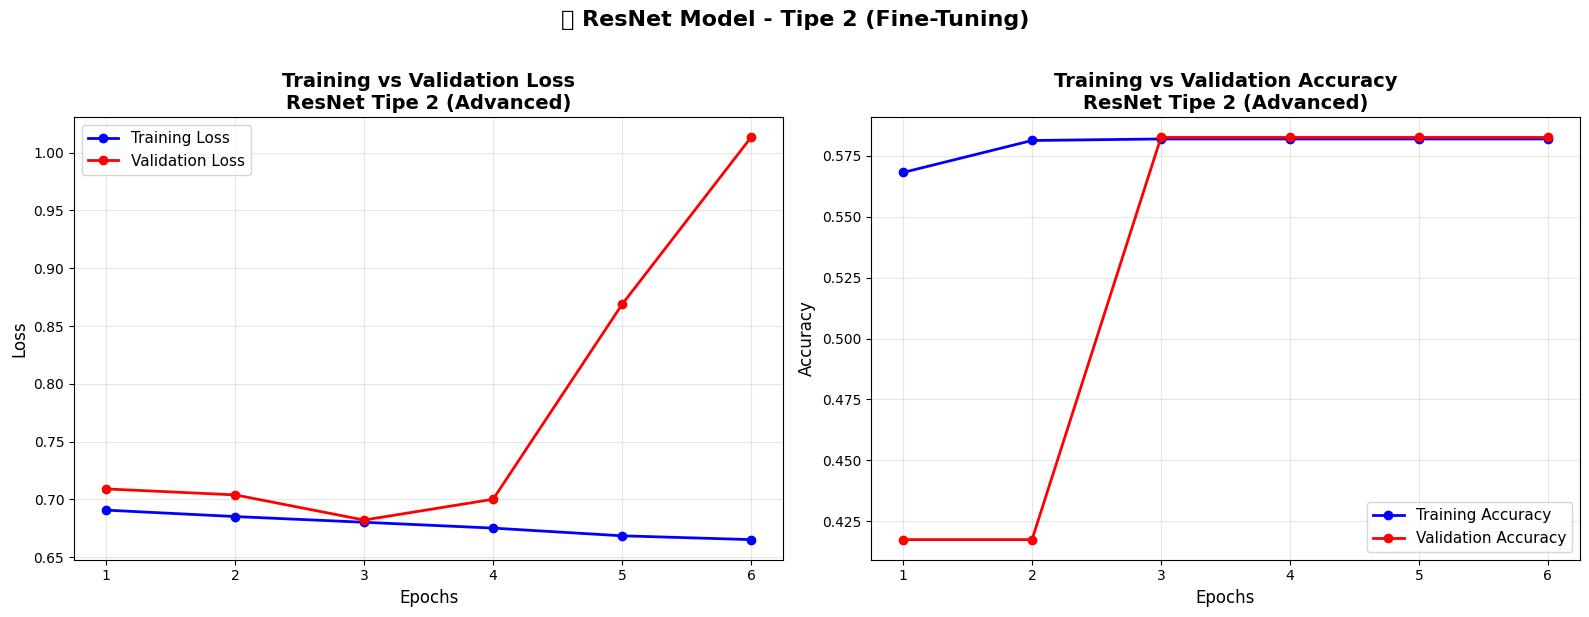


📊 SUMMARY HASIL TRAINING - RESNET TIPE 2
Epochs: 20 | Batch Size: 64 | LR: 0.0001
Actual Epochs Run: 6
------------------------------------------------------------
Final Training Loss      : 0.6652
Final Training Accuracy  : 0.5819 (58.19%)
Final Validation Loss    : 1.0131
Final Validation Accuracy: 0.5825 (58.25%)
Training Duration        : 61.63s (1.03 min)
------------------------------------------------------------
✅ Model balance - tidak ada overfitting/underfitting signifikan


In [15]:
import matplotlib.pyplot as plt

# Ambil data history dari training
loss_values_type2 = history_type2.history['loss']
val_loss_values_type2 = history_type2.history['val_loss']
accuracy_values_type2 = history_type2.history['accuracy']
val_accuracy_values_type2 = history_type2.history['val_accuracy']

epochs_range = range(1, len(loss_values_type2) + 1)

# Buat figure dengan 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Loss
axes[0].plot(epochs_range, loss_values_type2, 'bo-', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(epochs_range, val_loss_values_type2, 'ro-', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_title('Training vs Validation Loss\nResNet Tipe 2 (Advanced)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Subplot 2: Accuracy
axes[1].plot(epochs_range, accuracy_values_type2, 'bo-', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].plot(epochs_range, val_accuracy_values_type2, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
axes[1].set_title('Training vs Validation Accuracy\nResNet Tipe 2 (Advanced)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('🔴 ResNet Model - Tipe 2 (Fine-Tuning)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tampilkan summary hasil training
print("\n" + "="*60)
print("📊 SUMMARY HASIL TRAINING - RESNET TIPE 2")
print("="*60)
print(f"Epochs: {epochs_type2} | Batch Size: {batch_size_type2} | LR: 0.0001")
print(f"Actual Epochs Run: {len(loss_values_type2)}")
print("-"*60)
print(f"Final Training Loss      : {loss_values_type2[-1]:.4f}")
print(f"Final Training Accuracy  : {accuracy_values_type2[-1]:.4f} ({accuracy_values_type2[-1]*100:.2f}%)")
print(f"Final Validation Loss    : {val_loss_values_type2[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy_values_type2[-1]:.4f} ({val_accuracy_values_type2[-1]*100:.2f}%)")
print(f"Training Duration        : {training_duration_type2:.2f}s ({training_duration_type2/60:.2f} min)")
print("-"*60)

# Deteksi overfitting
gap = accuracy_values_type2[-1] - val_accuracy_values_type2[-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

### Evaluate Model

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("📈 EVALUASI MODEL RESNET - TIPE 2")
print("="*60)

# === EVALUATE PADA VALIDATION SET ===
# PENTING: Pakai val_images_128 (yang sudah di-resize), bukan val_images!
loss_type2, accuracy_type2 = model_type2.evaluate(val_images_128, val_labels, verbose=1)

print("\n" + "="*60)
print("📊 HASIL EVALUASI FINAL - RESNET TIPE 2")
print("="*60)
print(f"Validation Loss    : {loss_type2:.4f}")
print(f"Validation Accuracy: {accuracy_type2:.4f} ({accuracy_type2*100:.2f}%)")
print("="*60)

# Interpretasi hasil
print("\n" + "="*60)
if accuracy_type2 > 0.85:
    print("✅ Model ResNet Tipe 2 memiliki performa BAIK!")
elif accuracy_type2 > 0.75:
    print("⚠️  Model ResNet Tipe 2 cukup baik, masih bisa ditingkatkan.")
else:
    print("❌ Model ResNet Tipe 2 perlu perbaikan.")
print("="*60)

📈 EVALUASI MODEL RESNET - TIPE 2
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.5837 - loss: 0.6819

📊 HASIL EVALUASI FINAL - RESNET TIPE 2
Validation Loss    : 0.6822
Validation Accuracy: 0.5825 (58.25%)

❌ Model ResNet Tipe 2 perlu perbaikan.


### Confusion Matrix & Classification Report

🔍 ANALISIS CONFUSION MATRIX - RESNET VERSI 2

📊 Melakukan prediksi pada validation set...
Total prediksi: 400
Shape y_true: (400,)
Shape y_pred: (400,)

🔢 Menghitung Confusion Matrix...

📋 CONFUSION MATRIX - RESNET VERSI 2

                    PREDICTED
                Female(0)    Male(1)
    ACTUAL
    Female(0)       233           0
    Male(1)         167           0


📊 DETAIL METRIK TP, TN, FP, FN:
✅ True Positive  (TP):    0 ( 0.00%)
   → Male diprediksi sebagai Male (BENAR)

✅ True Negative  (TN):  233 (58.25%)
   → Female diprediksi sebagai Female (BENAR)

❌ False Positive (FP):    0 ( 0.00%)
   → Female diprediksi sebagai Male (SALAH - Type I Error)

❌ False Negative (FN):  167 (41.75%)
   → Male diprediksi sebagai Female (SALAH - Type II Error)

------------------------------------------------------------
📌 Total Prediksi Benar:  233 (58.25%)
📌 Total Prediksi Salah:  167 (41.75%)

📈 METRIK PERFORMA LANJUTAN:
Accuracy         : 0.5825 (58.25%)
   → (TP + TN) / Total

Precisio

/tmp/ipython-input-1624104555.py:180: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1624104555.py:180: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1624104555.py:180: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes

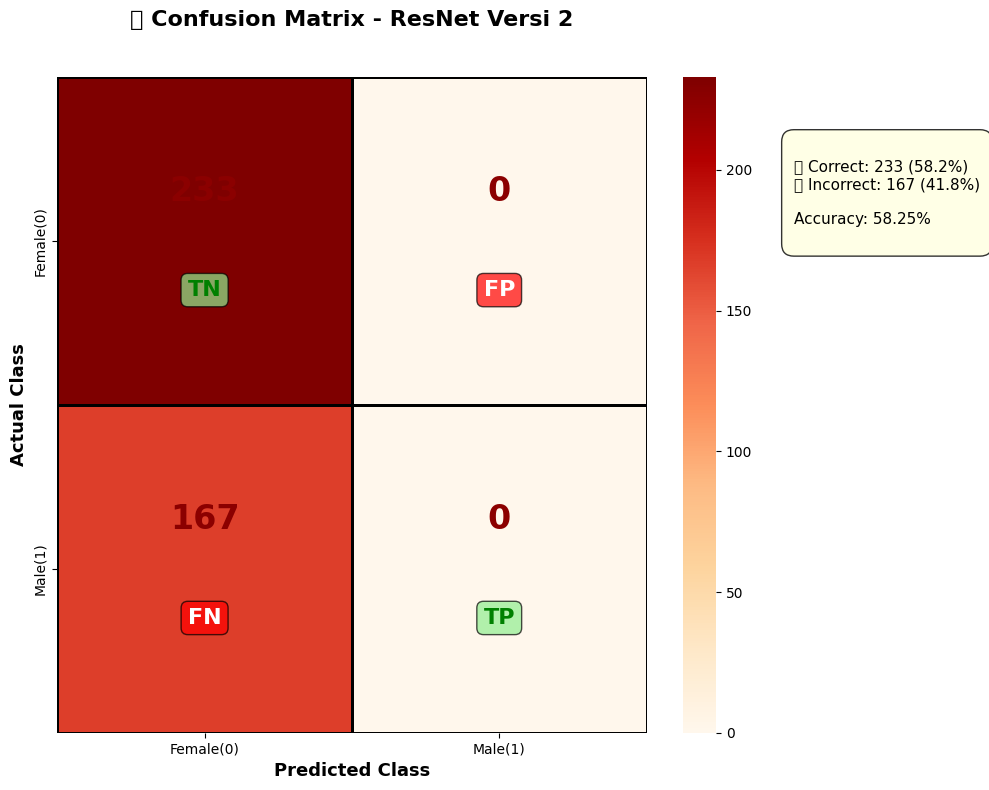


📄 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   Female(0)     0.5825    1.0000    0.7362       233
     Male(1)     0.0000    0.0000    0.0000       167

    accuracy                         0.5825       400
   macro avg     0.2913    0.5000    0.3681       400
weighted avg     0.3393    0.5825    0.4288       400


💡 INTERPRETASI HASIL:
⚠️  Model cenderung UNDER-PREDICT Male
   → 167 Male salah diprediksi sebagai Female
   → 0 Female salah diprediksi sebagai Male

📌 REKOMENDASI:
   - Adjust threshold dari 0.5 ke nilai lebih rendah (misal 0.4)
   - Tambah data augmentation untuk kelas Male

🎯 Overall Accuracy: 58.25%
   → POOR performance - perlu perbaikan signifikan


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("🔍 ANALISIS CONFUSION MATRIX - RESNET VERSI 2")
print("="*60)

# ========================================
# 1️⃣ PREDIKSI PADA VALIDATION SET
# ========================================
print("\n📊 Melakukan prediksi pada validation set...")

# PENTING: Pakai val_images_128 (yang sudah di-resize)
y_pred_proba_resnet_v2 = model_type2.predict(val_images_128, verbose=0)

# Convert probabilitas ke binary predictions (threshold = 0.5)
y_pred_resnet_v2 = (y_pred_proba_resnet_v2 > 0.5).astype(int).flatten()

# Ground truth labels
y_true = val_labels.astype(int)

print(f"Total prediksi: {len(y_pred_resnet_v2)}")
print(f"Shape y_true: {y_true.shape}")
print(f"Shape y_pred: {y_pred_resnet_v2.shape}")

# ========================================
# 2️⃣ HITUNG CONFUSION MATRIX
# ========================================
print("\n🔢 Menghitung Confusion Matrix...")

cm_resnet_v2 = confusion_matrix(y_true, y_pred_resnet_v2)

# Extract TP, TN, FP, FN
TN_resnet_v2 = cm_resnet_v2[0, 0]  # True Negative (Female → Female)
FP_resnet_v2 = cm_resnet_v2[0, 1]  # False Positive (Female → Male)
FN_resnet_v2 = cm_resnet_v2[1, 0]  # False Negative (Male → Female)
TP_resnet_v2 = cm_resnet_v2[1, 1]  # True Positive (Male → Male)

total_resnet_v2 = TN_resnet_v2 + FP_resnet_v2 + FN_resnet_v2 + TP_resnet_v2

print("\n" + "="*60)
print("📋 CONFUSION MATRIX - RESNET VERSI 2")
print("="*60)
print(f"""
                    PREDICTED
                Female(0)    Male(1)
    ACTUAL
    Female(0)      {TN_resnet_v2:4d}        {FP_resnet_v2:4d}
    Male(1)        {FN_resnet_v2:4d}        {TP_resnet_v2:4d}
""")
print("="*60)

# ========================================
# 3️⃣ DETAIL METRIK
# ========================================
print("\n📊 DETAIL METRIK TP, TN, FP, FN:")
print("="*60)
print(f"✅ True Positive  (TP): {TP_resnet_v2:4d} ({TP_resnet_v2/total_resnet_v2*100:5.2f}%)")
print(f"   → Male diprediksi sebagai Male (BENAR)")
print()
print(f"✅ True Negative  (TN): {TN_resnet_v2:4d} ({TN_resnet_v2/total_resnet_v2*100:5.2f}%)")
print(f"   → Female diprediksi sebagai Female (BENAR)")
print()
print(f"❌ False Positive (FP): {FP_resnet_v2:4d} ({FP_resnet_v2/total_resnet_v2*100:5.2f}%)")
print(f"   → Female diprediksi sebagai Male (SALAH - Type I Error)")
print()
print(f"❌ False Negative (FN): {FN_resnet_v2:4d} ({FN_resnet_v2/total_resnet_v2*100:5.2f}%)")
print(f"   → Male diprediksi sebagai Female (SALAH - Type II Error)")
print()
print("-"*60)
print(f"📌 Total Prediksi Benar: {TP_resnet_v2 + TN_resnet_v2:4d} ({(TP_resnet_v2+TN_resnet_v2)/total_resnet_v2*100:5.2f}%)")
print(f"📌 Total Prediksi Salah: {FP_resnet_v2 + FN_resnet_v2:4d} ({(FP_resnet_v2+FN_resnet_v2)/total_resnet_v2*100:5.2f}%)")
print("="*60)

# ========================================
# 4️⃣ HITUNG METRIK TAMBAHAN
# ========================================
print("\n📈 METRIK PERFORMA LANJUTAN:")
print("="*60)

# Accuracy
accuracy_resnet_v2 = (TP_resnet_v2 + TN_resnet_v2) / total_resnet_v2
print(f"Accuracy         : {accuracy_resnet_v2:.4f} ({accuracy_resnet_v2*100:.2f}%)")
print(f"   → (TP + TN) / Total")
print()

# Precision (Male class)
precision_resnet_v2 = TP_resnet_v2 / (TP_resnet_v2 + FP_resnet_v2) if (TP_resnet_v2 + FP_resnet_v2) > 0 else 0
print(f"Precision (Male) : {precision_resnet_v2:.4f} ({precision_resnet_v2*100:.2f}%)")
print(f"   → TP / (TP + FP)")
print(f"   → Dari semua yang diprediksi Male, berapa yang benar?")
print()

# Recall / Sensitivity (Male class)
recall_resnet_v2 = TP_resnet_v2 / (TP_resnet_v2 + FN_resnet_v2) if (TP_resnet_v2 + FN_resnet_v2) > 0 else 0
print(f"Recall (Male)    : {recall_resnet_v2:.4f} ({recall_resnet_v2*100:.2f}%)")
print(f"   → TP / (TP + FN)")
print(f"   → Dari semua Male sebenarnya, berapa yang terdeteksi?")
print()

# Specificity (Female class)
specificity_resnet_v2 = TN_resnet_v2 / (TN_resnet_v2 + FP_resnet_v2) if (TN_resnet_v2 + FP_resnet_v2) > 0 else 0
print(f"Specificity (Female): {specificity_resnet_v2:.4f} ({specificity_resnet_v2*100:.2f}%)")
print(f"   → TN / (TN + FP)")
print(f"   → Dari semua Female sebenarnya, berapa yang terdeteksi?")
print()

# F1-Score (Male class)
f1_resnet_v2 = 2 * (precision_resnet_v2 * recall_resnet_v2) / (precision_resnet_v2 + recall_resnet_v2) if (precision_resnet_v2 + recall_resnet_v2) > 0 else 0
print(f"F1-Score (Male)  : {f1_resnet_v2:.4f}")
print(f"   → 2 × (Precision × Recall) / (Precision + Recall)")
print(f"   → Balance antara Precision dan Recall")
print()

# Error Rate
error_rate_resnet_v2 = (FP_resnet_v2 + FN_resnet_v2) / total_resnet_v2
print(f"Error Rate       : {error_rate_resnet_v2:.4f} ({error_rate_resnet_v2*100:.2f}%)")
print(f"   → (FP + FN) / Total")
print("="*60)

# ========================================
# 5️⃣ VISUALISASI CONFUSION MATRIX (1 PLOT AJA)
# ========================================
print("\n🎨 Membuat visualisasi Confusion Matrix...")

plt.figure(figsize=(10, 8))

# Buat heatmap dengan annotasi custom
ax = sns.heatmap(cm_resnet_v2, annot=False, fmt='d', cmap='OrRd', cbar=True,
                 xticklabels=['Female(0)', 'Male(1)'],
                 yticklabels=['Female(0)', 'Male(1)'],
                 linewidths=2, linecolor='black')

# Tambahkan angka + label TP/TN/FP/FN di setiap cell
# Cell [0,0] - TN (True Negative)
ax.text(0.5, 0.35, f'{TN_resnet_v2}', ha='center', va='center',
        fontsize=24, color='darkred', weight='bold')
ax.text(0.5, 0.65, 'TN', ha='center', va='center',
        fontsize=16, color='green', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

# Cell [0,1] - FP (False Positive)
ax.text(1.5, 0.35, f'{FP_resnet_v2}', ha='center', va='center',
        fontsize=24, color='darkred', weight='bold')
ax.text(1.5, 0.65, 'FP', ha='center', va='center',
        fontsize=16, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))

# Cell [1,0] - FN (False Negative)
ax.text(0.5, 1.35, f'{FN_resnet_v2}', ha='center', va='center',
        fontsize=24, color='darkred', weight='bold')
ax.text(0.5, 1.65, 'FN', ha='center', va='center',
        fontsize=16, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))

# Cell [1,1] - TP (True Positive)
ax.text(1.5, 1.35, f'{TP_resnet_v2}', ha='center', va='center',
        fontsize=24, color='darkred', weight='bold')
ax.text(1.5, 1.65, 'TP', ha='center', va='center',
        fontsize=16, color='green', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

plt.title('🔴 Confusion Matrix - ResNet Versi 2\n',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual Class', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=13, fontweight='bold')

# Tambahkan legend keterangan
legend_text = f"""
✅ Correct: {TP_resnet_v2 + TN_resnet_v2} ({(TP_resnet_v2+TN_resnet_v2)/total_resnet_v2*100:.1f}%)
❌ Incorrect: {FP_resnet_v2 + FN_resnet_v2} ({(FP_resnet_v2+FN_resnet_v2)/total_resnet_v2*100:.1f}%)

Accuracy: {accuracy_resnet_v2*100:.2f}%
"""
plt.text(2.5, 0.5, legend_text, fontsize=11,
         bbox=dict(boxstyle='round,pad=0.8', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

# ========================================
# 6️⃣ CLASSIFICATION REPORT
# ========================================
print("\n📄 CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_true, y_pred_resnet_v2,
                          target_names=['Female(0)', 'Male(1)'],
                          digits=4))
print("="*60)

# ========================================
# 7️⃣ INTERPRETASI & REKOMENDASI
# ========================================
print("\n💡 INTERPRETASI HASIL:")
print("="*60)

if FP_resnet_v2 > FN_resnet_v2:
    print("⚠️  Model cenderung OVER-PREDICT Male")
    print(f"   → {FP_resnet_v2} Female salah diprediksi sebagai Male")
    print(f"   → {FN_resnet_v2} Male salah diprediksi sebagai Female")
    print("\n📌 REKOMENDASI:")
    print("   - Adjust threshold dari 0.5 ke nilai lebih tinggi (misal 0.6)")
    print("   - Tambah data augmentation untuk kelas Female")
    print("   - Gunakan class weights saat training")
elif FN_resnet_v2 > FP_resnet_v2:
    print("⚠️  Model cenderung UNDER-PREDICT Male")
    print(f"   → {FN_resnet_v2} Male salah diprediksi sebagai Female")
    print(f"   → {FP_resnet_v2} Female salah diprediksi sebagai Male")
    print("\n📌 REKOMENDASI:")
    print("   - Adjust threshold dari 0.5 ke nilai lebih rendah (misal 0.4)")
    print("   - Tambah data augmentation untuk kelas Male")
else:
    print("✅ Model balance dalam error distribution")
    print(f"   → FP: {FP_resnet_v2}, FN: {FN_resnet_v2}")

print()
print(f"🎯 Overall Accuracy: {accuracy_resnet_v2*100:.2f}%")
if accuracy_resnet_v2 > 0.90:
    print("   → EXCELLENT performance!")
elif accuracy_resnet_v2 > 0.80:
    print("   → GOOD performance!")
elif accuracy_resnet_v2 > 0.70:
    print("   → FAIR performance - masih bisa ditingkatkan")
else:
    print("   → POOR performance - perlu perbaikan signifikan")

print("="*60)

# # ========================================
# # 8️⃣ SIMPAN HASIL
# # ========================================
# results_resnet_v2 = {
#     'confusion_matrix': cm_resnet_v2,
#     'TP': TP_resnet_v2,
#     'TN': TN_resnet_v2,
#     'FP': FP_resnet_v2,
#     'FN': FN_resnet_v2,
#     'accuracy': accuracy_resnet_v2,
#     'precision': precision_resnet_v2,
#     'recall': recall_resnet_v2,
#     'specificity': specificity_resnet_v2,
#     'f1_score': f1_resnet_v2,
#     'error_rate': error_rate_resnet_v2
# }

# print("\n✅ Analisis ResNet Versi 2 selesai! Hasil disimpan ke 'results_resnet_v2'")

## Test (V1 + V2)

🔵🟢 TEST PREDIKSI - RESNET TIPE 1 & TIPE 2
Upload gambar sekali, test di kedua model sekaligus
------------------------------------------------------------


Saving LUCINTA.webp to LUCINTA.webp

📷 Memproses gambar: "LUCINTA.webp"
Ukuran file: 6,030 bytes

📊 HASIL PREDIKSI UNTUK: LUCINTA.webp
🔵 RESNET TIPE 1 (Transfer Learning):
   Prediksi: Female
   Prob Male: 0.3604 (36.04%)
   Confidence: 0.6396 (63.96%)

🟢 RESNET TIPE 2 (Fine-tuning):
   Prediksi: Male
   Prob Male: 0.5116 (51.16%)
   Confidence: 0.5116 (51.16%)

⚠️  PREDIKSI BERBEDA!
   Tipe 1: Female (63.96%)
   Tipe 2: Male (51.16%)


/tmp/ipython-input-110947522.py:135: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-110947522.py:135: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


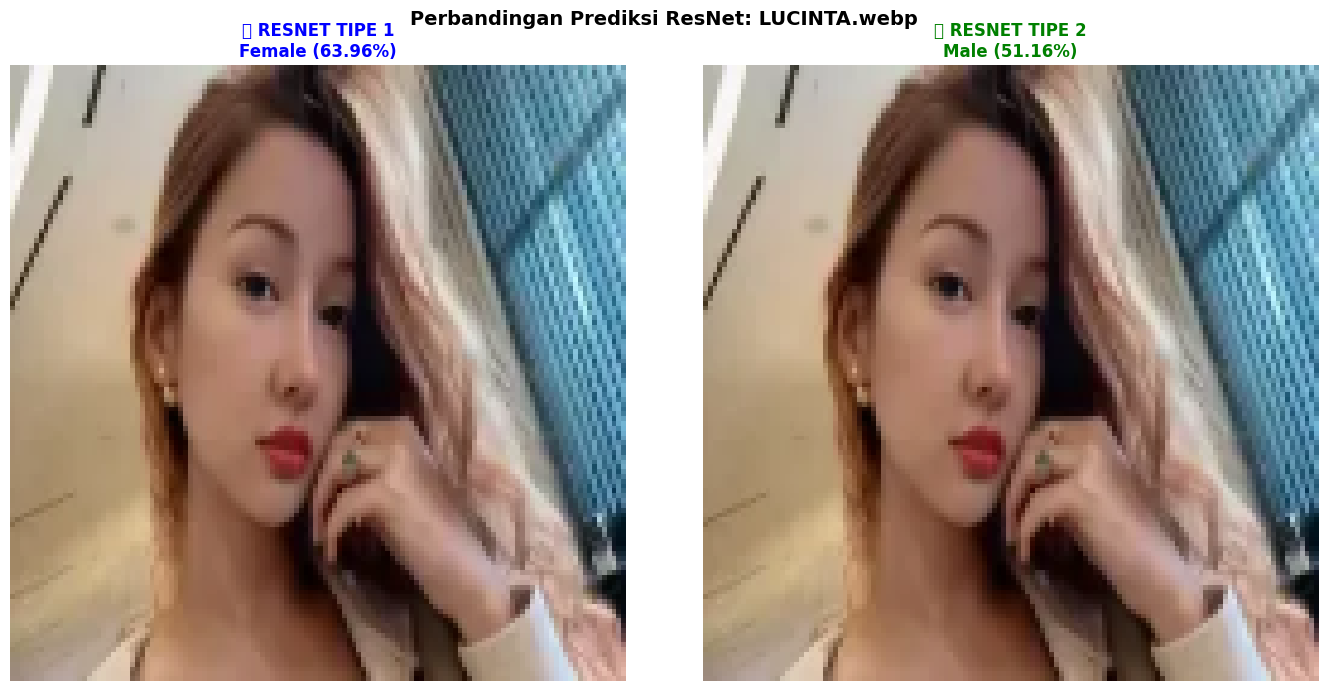


✅ Prediksi kedua model selesai!


In [19]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("="*60)
print("🔵🟢 TEST PREDIKSI - RESNET TIPE 1 & TIPE 2")
print("="*60)
print("Upload gambar sekali, test di kedua model sekaligus")
print("-"*60)

# Upload gambar dari komputer lokal
uploaded = files.upload()

# Simpan hasil prediksi untuk perbandingan
predictions_comparison = []

# Proses setiap gambar yang diupload
for fn in uploaded.keys():
    print(f'\n{"="*60}')
    print(f'📷 Memproses gambar: "{fn}"')
    print(f'Ukuran file: {len(uploaded[fn]):,} bytes')
    print(f'{"="*60}')

    # Baca gambar
    image_path = fn
    img = cv2.imread(image_path)

    if img is None:
        print(f"❌ Error: Tidak dapat membaca gambar {image_path}")
        continue

    # === PREPROCESSING (SAMA DENGAN TRAINING) ===

    # 1. Resize ke ukuran input model (128x128 untuk ResNet)
    target_size = (128, 128)
    img_resized = cv2.resize(img, target_size)

    # 2. Konversi BGR (OpenCV) ke RGB (sesuai training)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # 3. Normalisasi: ubah range piksel dari [0, 255] ke [0, 1]
    img_normalized = img_rgb.astype('float32') / 255.0

    # 4. Tambah dimensi batch: (128, 128, 3) -> (1, 128, 128, 3)
    img_input = np.expand_dims(img_normalized, axis=0)

    # === PREDIKSI DENGAN KEDUA MODEL ===
    results = {}

    # Prediksi Model Tipe 1
    if 'model_type1' in globals():
        pred1 = model_type1.predict(img_input, verbose=0)
        prob_male_1 = pred1[0][0]
        class_1 = "Male" if prob_male_1 > 0.5 else "Female"
        conf_1 = prob_male_1 if prob_male_1 > 0.5 else (1 - prob_male_1)
        results['type1'] = {
            'prob_male': prob_male_1,
            'class': class_1,
            'confidence': conf_1
        }
    else:
        print("⚠️  Model Tipe 1 tidak ditemukan, skip prediksi Tipe 1")

    # Prediksi Model Tipe 2
    if 'model_type2' in globals():
        pred2 = model_type2.predict(img_input, verbose=0)
        prob_male_2 = pred2[0][0]
        class_2 = "Male" if prob_male_2 > 0.5 else "Female"
        conf_2 = prob_male_2 if prob_male_2 > 0.5 else (1 - prob_male_2)
        results['type2'] = {
            'prob_male': prob_male_2,
            'class': class_2,
            'confidence': conf_2
        }
    else:
        print("⚠️  Model Tipe 2 tidak ditemukan, skip prediksi Tipe 2")

    # Simpan hasil untuk tabel perbandingan
    if 'type1' in results and 'type2' in results:
        predictions_comparison.append({
            'filename': fn,
            'type1_prob_male': results['type1']['prob_male'],
            'type1_class': results['type1']['class'],
            'type1_conf': results['type1']['confidence'],
            'type2_prob_male': results['type2']['prob_male'],
            'type2_class': results['type2']['class'],
            'type2_conf': results['type2']['confidence']
        })

    # === TAMPILKAN HASIL SIDE-BY-SIDE ===
    print(f"\n📊 HASIL PREDIKSI UNTUK: {fn}")
    print(f"="*60)

    if 'type1' in results:
        print(f"🔵 RESNET TIPE 1 (Transfer Learning):")
        print(f"   Prediksi: {results['type1']['class']}")
        print(f"   Prob Male: {results['type1']['prob_male']:.4f} ({results['type1']['prob_male']*100:.2f}%)")
        print(f"   Confidence: {results['type1']['confidence']:.4f} ({results['type1']['confidence']*100:.2f}%)")

    if 'type2' in results:
        print(f"\n🟢 RESNET TIPE 2 (Fine-tuning):")
        print(f"   Prediksi: {results['type2']['class']}")
        print(f"   Prob Male: {results['type2']['prob_male']:.4f} ({results['type2']['prob_male']*100:.2f}%)")
        print(f"   Confidence: {results['type2']['confidence']:.4f} ({results['type2']['confidence']*100:.2f}%)")

    # Cek apakah prediksi sama atau beda
    if 'type1' in results and 'type2' in results:
        if results['type1']['class'] == results['type2']['class']:
            print(f"\n✅ KEDUA MODEL SEPAKAT: {results['type1']['class']}")
        else:
            print(f"\n⚠️  PREDIKSI BERBEDA!")
            print(f"   Tipe 1: {results['type1']['class']} ({results['type1']['confidence']*100:.2f}%)")
            print(f"   Tipe 2: {results['type2']['class']} ({results['type2']['confidence']*100:.2f}%)")

    print(f"="*60)

    # === VISUALISASI SIDE-BY-SIDE ===
    if 'type1' in results and 'type2' in results:
        fig, axes = plt.subplots(1, 2, figsize=(14, 7))

        # Model Tipe 1
        axes[0].imshow(img_rgb)
        axes[0].set_title(f"🔵 RESNET TIPE 1\n{results['type1']['class']} ({results['type1']['confidence']*100:.2f}%)",
                          fontsize=12, fontweight='bold', color='blue')
        axes[0].axis('off')

        # Model Tipe 2
        axes[1].imshow(img_rgb)
        axes[1].set_title(f"🟢 RESNET TIPE 2\n{results['type2']['class']} ({results['type2']['confidence']*100:.2f}%)",
                          fontsize=12, fontweight='bold', color='green')
        axes[1].axis('off')

        plt.suptitle(f"Perbandingan Prediksi ResNet: {fn}", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

print("\n" + "="*60)
print("✅ Prediksi kedua model selesai!")
print("="*60)

# AlexNet

## Setup Kaggle di Colab

In [64]:
# Install Kaggle
!pip install kaggle -q
import os
import sys

# Buat direktori .kaggle jika belum ada
!mkdir -p ~/.kaggle

# Cek apakah file kaggle.json sudah diupload
if os.path.exists('/content/kaggle.json'):
    # Pindahkan kaggle.json ke direktori .kaggle
    !mv /content/kaggle.json ~/.kaggle/
    # Set permission file agar secure
    !chmod 600 ~/.kaggle/kaggle.json
    print("kaggle.json berhasil dikonfigurasi.")
else:
    print("kaggle.json tidak ditemukan di /content/. Silakan upload file kaggle.json terlebih dahulu.")

kaggle.json tidak ditemukan di /content/. Silakan upload file kaggle.json terlebih dahulu.


## Download Dataset dari Kaggle

In [65]:
# Download dataset CelebA 64x64 dari Kaggle
!kaggle datasets download -d therealcyberlord/50k-celeba-dataset-64x64

Dataset URL: https://www.kaggle.com/datasets/therealcyberlord/50k-celeba-dataset-64x64
License(s): unknown
50k-celeba-dataset-64x64.zip: Skipping, found more recently modified local copy (use --force to force download)


## Extract Dataset

In [66]:
import zipfile
import os

# Path file zip yang telah didownload
zip_file_path = '/content/50k-celeba-dataset-64x64.zip'

# Direktori tujuan ekstraksi
extracted_path = '/content/celeba_dataset_kaggle/'

# Buat folder ekstraksi jika belum ada
os.makedirs(extracted_path, exist_ok=True)

# Ekstrak file zip
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print("Dataset berhasil diekstrak.")
except FileNotFoundError:
    print(f"Error: File {zip_file_path} tidak ditemukan. Pastikan download berhasil.")
except zipfile.BadZipFile:
    print(f"Error: File {zip_file_path} bukan zip yang valid. Download mungkin corrupt.")
except Exception as e:
    print(f"Error saat ekstraksi: {e}")

Dataset berhasil diekstrak.


## Cek Isi Folder

In [67]:
import os

# Tampilkan isi direktori hasil ekstraksi
extracted_path = '/content/celeba_dataset_kaggle/'
print("Isi folder ekstraksi:")
print(os.listdir(extracted_path))

Isi folder ekstraksi:
['50k']


## Download Attribute File (Label)


In [68]:
# Download file atribut dari GitHub (alternatif jika gagal)
# Opsional: Bisa juga download manual dari Google Drive
# Link Google Drive: https://drive.google.com/drive/folders/1AA21MR8GeQdnOVgmNcbxCrbAjL1udj0l

import requests
import os

# URL file atribut CelebA
attribute_file_url = "https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt"
attribute_file_path = "/content/list_attr_celeba.txt"

print(f"Mencoba download file atribut dari: {attribute_file_url}")

try:
    response = requests.get(attribute_file_url, stream=True)
    response.raise_for_status()  # Raise error jika status 4xx atau 5xx

    with open(attribute_file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"File atribut berhasil didownload ke: {attribute_file_path}")

except requests.exceptions.RequestException as e:
    print(f"Error saat download file atribut: {e}")
    print("Tidak dapat mendownload file dari URL yang diberikan.")
    print("Silakan download manual dari Google Drive dan upload ke Colab.")
except Exception as e:
    print(f"Error saat memproses file atribut: {e}")

Mencoba download file atribut dari: https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt
Error saat download file atribut: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/notbook/celeb_a/list_attr_celeba.txt
Tidak dapat mendownload file dari URL yang diberikan.
Silakan download manual dari Google Drive dan upload ke Colab.


## Import Library

In [69]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import random
import os

print("✅ Library berhasil diimport")
print(f"TensorFlow version: {tf.__version__}")

✅ Library berhasil diimport
TensorFlow version: 2.19.0


## Reproducibility & Config

In [70]:
# === KONFIGURASI REPRODUCIBILITY ===
# Set random seed untuk reproducibility (hasil sama setiap run)
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print("="*60)
print("🔵 ALEXNET TIPE 1 - LIGHTWEIGHT")
print("="*60)
print(f"Random seed set to: {SEED}")

# === KONFIGURASI HYPERPARAMETER ===
INPUT_SHAPE = (128, 128, 3)  # Input size AlexNet (lebih besar dari VGG 64x64)
LEARNING_RATE = 1e-3         # 0.001
DROPOUT_RATE = 0.3           # Dropout rate moderate
EPOCHS = 10
BATCH_SIZE = 32

print("\n📌 KONFIGURASI ALEXNET TIPE 1:")
print(f"Input Shape: {INPUT_SHAPE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Dropout Rate: {DROPOUT_RATE}")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print("="*60)

🔵 ALEXNET TIPE 1 - LIGHTWEIGHT
Random seed set to: 42

📌 KONFIGURASI ALEXNET TIPE 1:
Input Shape: (128, 128, 3)
Learning Rate: 0.001
Dropout Rate: 0.3
Epochs: 10
Batch Size: 32


## Load Dataset & Preprocessing


In [71]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split

# Path direktori gambar dan file atribut
img_dir = "/content/celeba_dataset_kaggle/50k"
attr_path = "/content/list_attr_celeba.txt"

print("Memulai loading dataset...")

# === VALIDASI DIREKTORI GAMBAR ===
if not os.path.exists(img_dir):
    print(f"❌ Error: Direktori gambar tidak ditemukan di {img_dir}")
    images, labels = np.array([]), np.array([])
else:
    # List semua file gambar
    image_files_in_dir = [f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')]

    if not image_files_in_dir:
        print(f"❌ Error: Tidak ada file gambar di {img_dir}")
        images, labels = np.array([]), np.array([])
    else:
        print(f"✅ Ditemukan {len(image_files_in_dir)} file gambar di {img_dir}")

        # === LOAD FILE ATRIBUT ===
        try:
            # Load attribute file
            attributes = pd.read_csv(attr_path, skiprows=1, sep=r'\s+', index_col=0)
            print(f"✅ File atribut berhasil diload dari {attr_path}")

            # === SAMPLE DATA ===
            # AlexNet pakai sample lebih kecil (sama dengan ResNet)
            sample_size = 2000  # Lebih ringan untuk Colab Free

            # Filter: hanya ambil yang ada gambarnya
            available_image_ids = [os.path.basename(f) for f in image_files_in_dir]
            attributes_available = attributes[attributes.index.isin(available_image_ids)]

            if len(attributes_available) < sample_size:
                print(f"⚠️  Warning: Hanya {len(attributes_available)} gambar dengan atribut tersedia.")
                print(f"   Loading semua data yang tersedia.")
                sample_data = attributes_available
            else:
                sample_data = attributes_available.sample(sample_size, random_state=SEED)

            print(f"\n📦 Sample data: {len(sample_data)} gambar")

            # === LOAD & PREPROCESS GAMBAR ===
            images = []
            labels = []

            print("\n🔄 Loading dan preprocessing gambar...")
            for idx, (filename, row) in enumerate(sample_data.iterrows()):
                img_path = os.path.join(img_dir, filename)
                img = cv2.imread(img_path)

                if img is not None:
                    # Resize ke 128x128 (AlexNet original pakai 227x227, tapi 128x128 cukup)
                    img = cv2.resize(img, (128, 128))

                    # Konversi BGR ke RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # Normalisasi ke [0, 1]
                    img = img / 255.0

                    images.append(img)
                    labels.append(1 if row['Male'] == 1 else 0)
                else:
                    print(f"⚠️  Warning: Tidak dapat load {img_path}")

                # Progress indicator setiap 200 gambar
                if (idx + 1) % 200 == 0:
                    print(f"   Progress: {idx + 1}/{len(sample_data)} gambar")

            # Konversi ke numpy array
            images = np.array(images, dtype=np.float32)
            labels = np.array(labels)

            print(f"\n{'='*60}")
            print("✅ BERHASIL LOAD DATA")
            print(f"{'='*60}")
            print(f"Total gambar: {len(images)}")
            print(f"Shape gambar: {images.shape}")
            print(f"Shape label: {labels.shape}")
            print(f"Range nilai piksel: [{images.min():.2f}, {images.max():.2f}]")
            print(f"Distribusi label: Female={int((labels==0).sum())}, Male={int((labels==1).sum())}")
            print(f"{'='*60}")

        except FileNotFoundError:
            print(f"❌ Error: File atribut tidak ditemukan di {attr_path}")
            images, labels = np.array([]), np.array([])
        except KeyError:
            print(f"❌ Error: Kolom 'Male' tidak ditemukan di file atribut.")
            images, labels = np.array([]), np.array([])
        except Exception as e:
            print(f"❌ Error tidak terduga saat loading data: {e}")
            images, labels = np.array([]), np.array([])

# === SPLIT DATA ===
if len(images) > 0:
    print("\n🔄 Melakukan split data...")

    train_images, val_images, train_labels, val_labels = train_test_split(
        images, labels,
        test_size=0.2,       # 20% untuk validation
        random_state=SEED,   # Reproducibility
        stratify=labels      # Jaga keseimbangan kelas
    )

    print(f"\n{'='*60}")
    print("=== Hasil Split Data ===")
    print(f"{'='*60}")
    print(f"Training set   : {train_images.shape}")
    print(f"Validation set : {val_images.shape}")
    print(f"Training labels: {train_labels.shape}")
    print(f"Validation labels: {val_labels.shape}")
    print(f"\nDistribusi Training   - Female: {(train_labels==0).sum()}, Male: {(train_labels==1).sum()}")
    print(f"Distribusi Validation - Female: {(val_labels==0).sum()}, Male: {(val_labels==1).sum()}")
    print(f"{'='*60}")
    print("\n✅ Data ready untuk training!")

else:
    print("\n❌ Data loading gagal. Tidak dapat melanjutkan.")
    train_images, val_images, train_labels, val_labels = None, None, None, None

Memulai loading dataset...
✅ Ditemukan 50000 file gambar di /content/celeba_dataset_kaggle/50k
✅ File atribut berhasil diload dari /content/list_attr_celeba.txt

📦 Sample data: 2000 gambar

🔄 Loading dan preprocessing gambar...
   Progress: 200/2000 gambar
   Progress: 400/2000 gambar
   Progress: 600/2000 gambar
   Progress: 800/2000 gambar
   Progress: 1000/2000 gambar
   Progress: 1200/2000 gambar
   Progress: 1400/2000 gambar
   Progress: 1600/2000 gambar
   Progress: 1800/2000 gambar
   Progress: 2000/2000 gambar

✅ BERHASIL LOAD DATA
Total gambar: 2000
Shape gambar: (2000, 128, 128, 3)
Shape label: (2000,)
Range nilai piksel: [0.00, 1.00]
Distribusi label: Female=1164, Male=836

🔄 Melakukan split data...

=== Hasil Split Data ===
Training set   : (1600, 128, 128, 3)
Validation set : (400, 128, 128, 3)
Training labels: (1600,)
Validation labels: (400,)

Distribusi Training   - Female: 931, Male: 669
Distribusi Validation - Female: 233, Male: 167

✅ Data ready untuk training!


## Safety Checks for Data


In [72]:
# === VALIDASI DATA SEBELUM TRAINING ===
print("="*60)
print("🔍 SAFETY CHECKS FOR DATA")
print("="*60)

# Cek keberadaan variabel
if 'train_images' not in globals() or train_images is None:
    raise RuntimeError("train_images not found — run the data loading/splitting cells first.")
if 'val_images' not in globals() or val_images is None:
    raise RuntimeError("val_images not found — run the data loading/splitting cells first.")
if 'train_labels' not in globals() or train_labels is None:
    raise RuntimeError("train_labels not found — run the data loading/splitting cells first.")
if 'val_labels' not in globals() or val_labels is None:
    raise RuntimeError("val_labels not found — run the data loading/splitting cells first.")

print("✅ All data variables found")

# Pastikan tipe data float32 dan sudah di-scale [0, 1]
if train_images.dtype != np.float32:
    print("⚠️  Converting images to float32 and scaling to [0, 1]")
    train_images = train_images.astype('float32') / 255.0
    val_images = val_images.astype('float32') / 255.0
else:
    print("✅ Images already float32 and scaled")

# Convert potential -1/1 labels to 0/1 (jika ada)
unique_labels = np.unique(np.concatenate([train_labels.flatten(), val_labels.flatten()]))
if set(unique_labels.tolist()).issuperset({-1, 1}):
    print("⚠️  Converting labels from -1/1 to 0/1")
    train_labels = np.where(train_labels == -1, 0, 1)
    val_labels = np.where(val_labels == -1, 0, 1)
else:
    print("✅ Labels already in 0/1 format")

print("\n📊 Data ready — shapes:")
print(f"   train_images: {train_images.shape}")
print(f"   val_images: {val_images.shape}")
print(f"   train_labels unique: {np.unique(train_labels)}")
print(f"   val_labels unique: {np.unique(val_labels)}")
print("="*60)

🔍 SAFETY CHECKS FOR DATA
✅ All data variables found
✅ Images already float32 and scaled
✅ Labels already in 0/1 format

📊 Data ready — shapes:
   train_images: (1600, 128, 128, 3)
   val_images: (400, 128, 128, 3)
   train_labels unique: [0 1]
   val_labels unique: [0 1]


## AlexNex - V1

### Build AlexNet Model

In [73]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import tensorflow.keras.backend as K

# Clear session untuk avoid conflict
K.clear_session()

def build_alexnet(input_shape=(64, 64, 3), dropout_rate=0.3, learning_rate=0.001):
    """
    Membangun AlexNet-like model untuk binary classification

    AlexNet adalah CNN landmark (2012, ImageNet winner) dengan karakteristik:
    - Large kernels di awal (11x11, 5x5)
    - Multiple conv layers dengan ReLU
    - Max pooling untuk downsampling
    - Fully connected layers dengan dropout

    Args:
        input_shape: Ukuran input (Height, Width, Channels) - Default: (64, 64, 3)
        dropout_rate: Dropout rate untuk regularisasi
        learning_rate: Learning rate untuk optimizer

    Returns:
        model: AlexNet model yang sudah dikompilasi
    """

    model = models.Sequential([
        # === CONV BLOCK 1 ===
        # Conv1: Large kernel 11x11, stride 4 untuk reduce dimensi cepat
        layers.Conv2D(96, (11, 11), strides=(4, 4), padding='same',
                      activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),  # Stabilkan training
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        # === CONV BLOCK 2 ===
        # Conv2: Kernel 5x5
        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        # === CONV BLOCK 3-5 ===
        # Conv3-5: Kernel 3x3 (lebih kecil, mirip VGG)
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        # === FULLY CONNECTED HEAD ===
        # Flatten feature maps ke 1D vector
        layers.Flatten(),

        # FC1: 512 neurons (dikurangi dari AlexNet original 4096 untuk dataset kecil)
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate),  # Regularisasi

        # FC2: 512 neurons
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate),

        # === OUTPUT LAYER ===
        # Binary classification: Male/Female
        layers.Dense(1, activation='sigmoid')
    ])

    # === COMPILE MODEL ===
    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

print("="*60)
print("🔵 BUILD MODEL ALEXNET - TIPE 1 (LIGHTWEIGHT)")
print("="*60)

# Build model dengan input 64x64
alexnet = build_alexnet(
    input_shape=(64, 64, 3),
    dropout_rate=0.3,
    learning_rate=0.001
)

print("\n=== Arsitektur Model AlexNet Tipe 1 ===")
alexnet.summary()

# Hitung total parameter
total_params = alexnet.count_params()
print(f"\n{'='*60}")
print(f"Total parameters: {total_params:,}")
print(f"{'='*60}")

print("\n📌 Note AlexNet:")
print("- AlexNet (2012) adalah CNN landmark yang memenangkan ImageNet")
print("- Karakteristik: Large kernels (11x11, 5x5), deep FC layers")
print("- Original AlexNet: 227x227 input, 4096 FC neurons")
print("- Tipe 1 ini: 64x64 input (konsisten dengan VGG & GoogleNet), 512 FC neurons")
print("- ResNet pakai 128x128 karena pretrained ImageNet requirement")

🔵 BUILD MODEL ALEXNET - TIPE 1 (LIGHTWEIGHT)

=== Arsitektur Model AlexNet Tipe 1 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 256)      │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,536,577 (17.31 MB)

 Trainable params: 4,535,873 (17.30 MB)

 Non-trainable params: 704 (2.75 KB)


Total parameters: 4,536,577

📌 Note AlexNet:
- AlexNet (2012) adalah CNN landmark yang memenangkan ImageNet
- Karakteristik: Large kernels (11x11, 5x5), deep FC layers
- Original AlexNet: 227x227 input, 4096 FC neurons
- Tipe 1 ini: 64x64 input (konsisten dengan VGG & GoogleNet), 512 FC neurons
- ResNet pakai 128x128 karena pretrained ImageNet requirement


### Train Model

In [74]:
from tensorflow.keras.callbacks import EarlyStopping
import time
import numpy as np
import cv2

# ========================================
# KONFIGURASI ALEXNET V1
# ========================================
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.3

# ========================================
# CEK & PREPARE DATA 64x64
# ========================================
print("="*60)
print("🔍 CEK DATA SIZE")
print("="*60)
print(f"train_images shape: {train_images.shape}")
print(f"val_images shape: {val_images.shape}")

# Jika train_images masih 128x128, resize ke 64x64
if train_images.shape[1] == 128:
    print("\n⚠️  Data masih 128x128, resize ke 64x64...")

    train_images_64 = np.array([cv2.resize(img, (64, 64)) for img in train_images])
    train_images_64 = train_images_64.astype('float32') / 255.0

    val_images_64 = np.array([cv2.resize(img, (64, 64)) for img in val_images])
    val_images_64 = val_images_64.astype('float32') / 255.0

    print(f"✅ train_images_64 shape: {train_images_64.shape}")
    print(f"✅ val_images_64 shape: {val_images_64.shape}")
else:
    # Sudah 64x64
    train_images_64 = train_images
    val_images_64 = val_images
    print("✅ Data sudah 64x64!")

print("="*60)

# ========================================
# TRAINING ALEXNET - TIPE 1
# ========================================
print("\n" + "="*60)
print("🔵 TRAINING ALEXNET - TIPE 1 (LIGHTWEIGHT)")
print("="*60)
print(f"Konfigurasi: Lightweight")
print("-"*60)
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Dropout Rate: {DROPOUT_RATE}")
print(f"Input Size: 64x64x3")
print("-"*60)
print(f"Total training samples: {len(train_images_64):,}")
print(f"Total validation samples: {len(val_images_64):,}")
print(f"Steps per epoch: {len(train_images_64) // BATCH_SIZE}")
print(f"Total steps: {(len(train_images_64) // BATCH_SIZE) * EPOCHS}")
print("="*60)

print("\n📌 REASONING TIPE 1 (Lightweight):")
print("-"*60)
print("""
- AlexNet: CNN klasik, train from scratch
  → Large kernels (11x11, 5x5) untuk capture fitur global
  → Deep FC layers (512-512) untuk klasifikasi
  → BatchNorm untuk stabilkan training
  → Designed untuk ImageNet (227x227), adapted untuk 64x64

- Input Size: 64x64
  → Konsisten dengan VGG & GoogleNet (64x64)
  → ResNet pakai 128x128 karena pretrained ImageNet requirement
  → Fair comparison untuk model train-from-scratch (VGG, GoogleNet, AlexNet)
  → ⚠️  WARNING: Large kernels (11x11) terlalu besar untuk 64x64!

- Epochs: 10
  → Quick experimentation, baseline comparison
  → Cukup untuk melihat trend awal training

- Learning Rate: 0.001
  → Standard learning rate untuk Adam optimizer
  → Balance antara speed dan stability
  → Konvergensi cepat tanpa overshooting

- Batch Size: 32
  → Standard batch size, balance memory & convergence
  → AlexNet lebih ringan dari ResNet/GoogleNet
  → Update gradient cukup sering

- Dropout: 0.3
  → Moderate regularisasi
  → Cegah overfitting di FC layers
  → Konsisten dengan V1 pattern (VGG, GoogleNet, AlexNet)

- AlexNet vs VGG vs GoogleNet vs ResNet:
  → AlexNet: Large kernels (11x11, 5x5), train from scratch (64x64)
  → VGG: Small kernels (3x3 stack), train from scratch (64x64) → WIN!
  → GoogleNet: Inception module, multi-scale (64x64)
  → ResNet: Skip connection, transfer learning (128x128)

- Expected Challenge:
  → AlexNet's 11x11 kernel designed for 227x227 input
  → On 64x64 input → Kernel too large, lose spatial detail
  → Likely result: Underfitting / poor performance

✅ COCOK UNTUK: Baseline AlexNet, comparison dengan modern CNN
⚠️  WARNING: Architecture-input mismatch expected!
""")
print("="*60)

# ========================================
# EARLY STOPPING CALLBACK
# ========================================
es = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

# Catat waktu mulai training
start_time = time.time()

print("\n🚀 Starting AlexNet Tipe 1 training...")
print("-"*60)

# Train model dengan data 64x64
history_alex = alexnet.fit(
    train_images_64,
    train_labels,
    validation_data=(val_images_64, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=1
)

# Hitung durasi training
end_time = time.time()
training_duration = end_time - start_time

print("\n" + "="*60)
print("✅ ALEXNET TIPE 1 TRAINING FINISHED!")
print("="*60)
print(f"⏱️  Waktu training: {training_duration:.2f} detik ({training_duration/60:.2f} menit)")
print(f"📊 Final Training Accuracy: {history_alex.history['accuracy'][-1]:.4f} ({history_alex.history['accuracy'][-1]*100:.2f}%)")
print(f"📊 Final Validation Accuracy: {history_alex.history['val_accuracy'][-1]:.4f} ({history_alex.history['val_accuracy'][-1]*100:.2f}%)")
print(f"🛑 Stopped at epoch: {len(history_alex.history['loss'])}/{EPOCHS}")
print("-"*60)

# Deteksi overfitting/underfitting
gap = history_alex.history['accuracy'][-1] - history_alex.history['val_accuracy'][-1]
val_acc = history_alex.history['val_accuracy'][-1]

if val_acc < 0.65:  # Accuracy sangat rendah
    print("❌ SEVERE UNDERFITTING TERDETEKSI!")
    print(f"   Val Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print("   💡 Root Cause: AlexNet's 11×11 kernels TOO LARGE for 64×64 input")
    print("   💡 Solution: Use smaller kernels (3×3) OR increase input size (227×227)")
elif gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

🔍 CEK DATA SIZE
train_images shape: (1600, 128, 128, 3)
val_images shape: (400, 128, 128, 3)

⚠️  Data masih 128x128, resize ke 64x64...
✅ train_images_64 shape: (1600, 64, 64, 3)
✅ val_images_64 shape: (400, 64, 64, 3)

🔵 TRAINING ALEXNET - TIPE 1 (LIGHTWEIGHT)
Konfigurasi: Lightweight
------------------------------------------------------------
Epochs: 10
Batch Size: 32
Learning Rate: 0.001
Dropout Rate: 0.3
Input Size: 64x64x3
------------------------------------------------------------
Total training samples: 1,600
Total validation samples: 400
Steps per epoch: 50
Total steps: 500

📌 REASONING TIPE 1 (Lightweight):
------------------------------------------------------------

- AlexNet: CNN klasik, train from scratch
  → Large kernels (11x11, 5x5) untuk capture fitur global
  → Deep FC layers (512-512) untuk klasifikasi
  → BatchNorm untuk stabilkan training
  → Designed untuk ImageNet (227x227), adapted untuk 64x64

- Input Size: 64x64
  → Konsisten dengan VGG & GoogleNet (64x64)


### Plot Training History

/tmp/ipython-input-2904083304.py:33: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


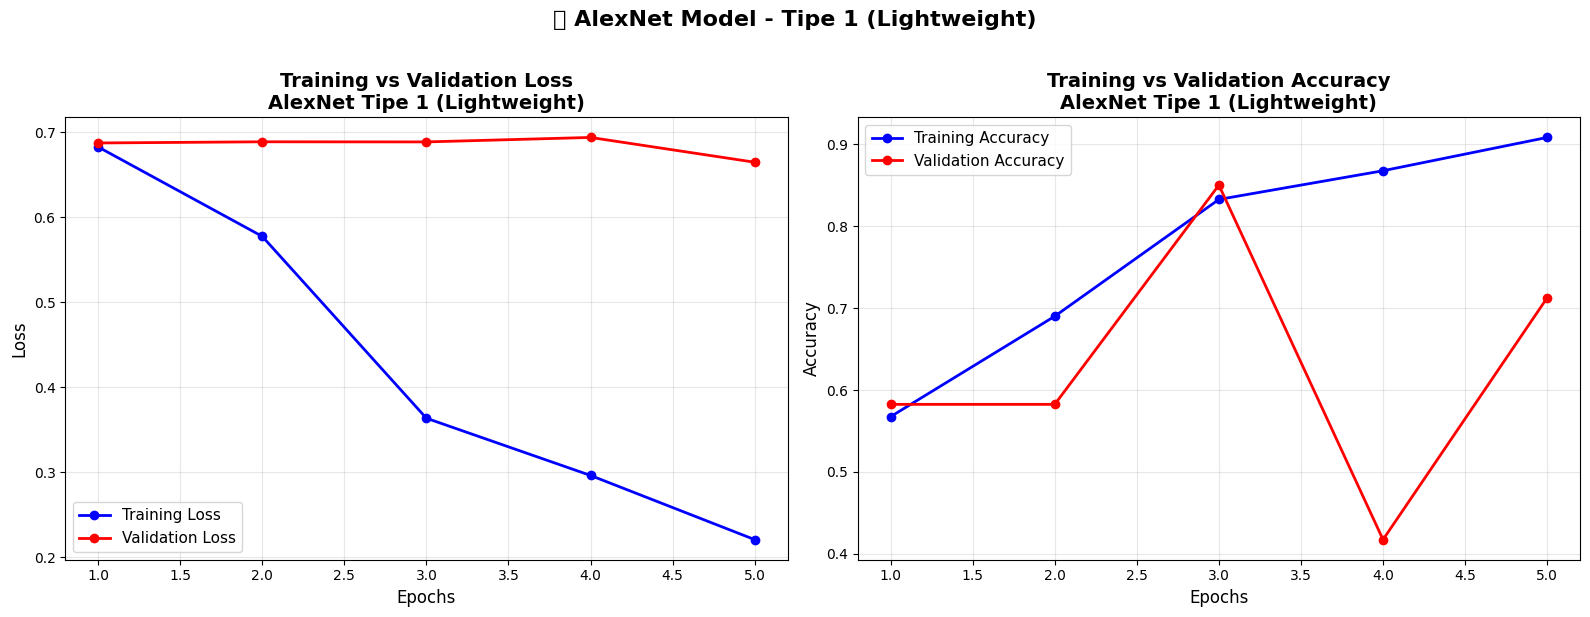


📊 SUMMARY HASIL TRAINING - ALEXNET TIPE 1
Epochs: 10 | Batch Size: 32 | LR: 0.001
Actual Epochs Run: 5
------------------------------------------------------------
Final Training Loss      : 0.2209
Final Training Accuracy  : 0.9081 (90.81%)
Final Validation Loss    : 0.6649
Final Validation Accuracy: 0.7125 (71.25%)
Training Duration        : 23.60s (0.39 min)
------------------------------------------------------------
⚠️  OVERFITTING TERDETEKSI!
   Gap: 0.1956 (19.56%)


In [75]:
import matplotlib.pyplot as plt

# Ambil data history
loss_values = history_alex.history['loss']
val_loss_values = history_alex.history['val_loss']
accuracy_values = history_alex.history['accuracy']
val_accuracy_values = history_alex.history['val_accuracy']

epochs_range = range(1, len(loss_values) + 1)

# Buat figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Loss
axes[0].plot(epochs_range, loss_values, 'bo-', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(epochs_range, val_loss_values, 'ro-', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_title('Training vs Validation Loss\nAlexNet Tipe 1 (Lightweight)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Subplot 2: Accuracy
axes[1].plot(epochs_range, accuracy_values, 'bo-', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].plot(epochs_range, val_accuracy_values, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
axes[1].set_title('Training vs Validation Accuracy\nAlexNet Tipe 1 (Lightweight)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('🟠 AlexNet Model - Tipe 1 (Lightweight)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary
print("\n" + "="*60)
print("📊 SUMMARY HASIL TRAINING - ALEXNET TIPE 1")
print("="*60)
print(f"Epochs: {EPOCHS} | Batch Size: {BATCH_SIZE} | LR: {LEARNING_RATE}")
print(f"Actual Epochs Run: {len(loss_values)}")
print("-"*60)
print(f"Final Training Loss      : {loss_values[-1]:.4f}")
print(f"Final Training Accuracy  : {accuracy_values[-1]:.4f} ({accuracy_values[-1]*100:.2f}%)")
print(f"Final Validation Loss    : {val_loss_values[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy_values[-1]:.4f} ({val_accuracy_values[-1]*100:.2f}%)")
print(f"Training Duration        : {training_duration:.2f}s ({training_duration/60:.2f} min)")
print("-"*60)

# Deteksi overfitting
gap = accuracy_values[-1] - val_accuracy_values[-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

### Evaluate Model

In [76]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("📈 EVALUASI MODEL ALEXNET - TIPE 1")
print("="*60)

# Evaluate pada validation set (pakai data 64x64)
loss_alex_v1, accuracy_alex_v1 = alexnet.evaluate(val_images_64, val_labels, verbose=1)

print("\n" + "="*60)
print("📊 HASIL EVALUASI FINAL - ALEXNET TIPE 1")
print("="*60)
print(f"Validation Loss    : {loss_alex_v1:.4f}")
print(f"Validation Accuracy: {accuracy_alex_v1:.4f} ({accuracy_alex_v1*100:.2f}%)")
print("="*60)

# Interpretasi hasil
print("\n" + "="*60)
if accuracy_alex_v1 > 0.85:
    print("✅ Model AlexNet Tipe 1 memiliki performa BAIK!")
elif accuracy_alex_v1 > 0.75:
    print("⚠️  Model AlexNet Tipe 1 cukup baik, masih bisa ditingkatkan.")
else:
    print("❌ Model AlexNet Tipe 1 perlu perbaikan.")
print("="*60)

📈 EVALUASI MODEL ALEXNET - TIPE 1
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8679 - loss: 0.6890 

📊 HASIL EVALUASI FINAL - ALEXNET TIPE 1
Validation Loss    : 0.6888
Validation Accuracy: 0.8500 (85.00%)

✅ Model AlexNet Tipe 1 memiliki performa BAIK!


### Confusion Matrix & Classification Report

🔍 ANALISIS CONFUSION MATRIX - ALEXNET VERSI 1

📊 Melakukan prediksi pada validation set...
Total prediksi: 400
Shape y_true: (400,)
Shape y_pred: (400,)

🔢 Menghitung Confusion Matrix...

📋 CONFUSION MATRIX - ALEXNET VERSI 1

                    PREDICTED
                Female(0)    Male(1)
    ACTUAL
    Female(0)       213          20
    Male(1)          40         127


📊 DETAIL METRIK TP, TN, FP, FN:
✅ True Positive  (TP):  127 (31.75%)
   → Male diprediksi sebagai Male (BENAR)

✅ True Negative  (TN):  213 (53.25%)
   → Female diprediksi sebagai Female (BENAR)

❌ False Positive (FP):   20 ( 5.00%)
   → Female diprediksi sebagai Male (SALAH - Type I Error)

❌ False Negative (FN):   40 (10.00%)
   → Male diprediksi sebagai Female (SALAH - Type II Error)

------------------------------------------------------------
📌 Total Prediksi Benar:  340 (85.00%)
📌 Total Prediksi Salah:   60 (15.00%)

📈 METRIK PERFORMA LANJUTAN:
Accuracy         : 0.8500 (85.00%)
   → (TP + TN) / Total

Precis

/tmp/ipython-input-3283749258.py:180: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3283749258.py:180: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3283749258.py:180: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure

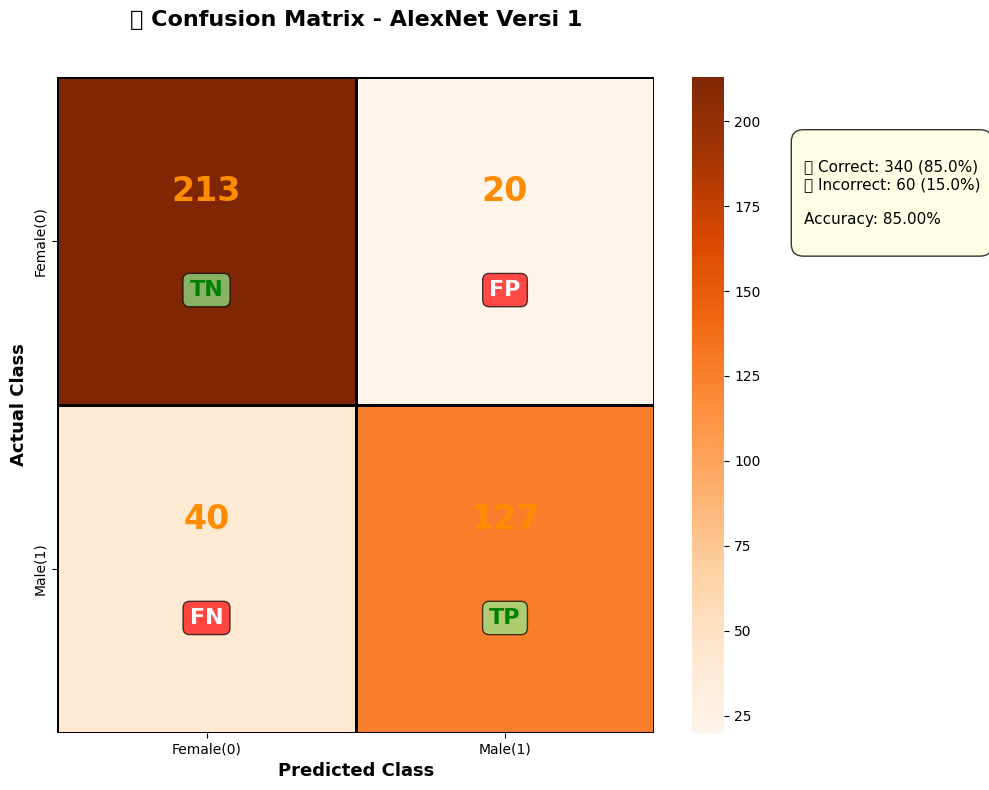


📄 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   Female(0)     0.8419    0.9142    0.8765       233
     Male(1)     0.8639    0.7605    0.8089       167

    accuracy                         0.8500       400
   macro avg     0.8529    0.8373    0.8427       400
weighted avg     0.8511    0.8500    0.8483       400


💡 INTERPRETASI HASIL:
⚠️  Model cenderung UNDER-PREDICT Male
   → 40 Male salah diprediksi sebagai Female
   → 20 Female salah diprediksi sebagai Male

📌 REKOMENDASI:
   - Adjust threshold dari 0.5 ke nilai lebih rendah (misal 0.4)
   - Tambah data augmentation untuk kelas Male

🎯 Overall Accuracy: 85.00%
   → GOOD performance!

✅ Analisis AlexNet Versi 1 selesai! Hasil disimpan ke 'results_alex_v1'


In [77]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("🔍 ANALISIS CONFUSION MATRIX - ALEXNET VERSI 1")
print("="*60)

# ========================================
# 1️⃣ PREDIKSI PADA VALIDATION SET
# ========================================
print("\n📊 Melakukan prediksi pada validation set...")

# PENTING: Pakai val_images_64 (data 64x64)
y_pred_proba_alex_v1 = alexnet.predict(val_images_64, verbose=0)

# Convert probabilitas ke binary predictions (threshold = 0.5)
y_pred_alex_v1 = (y_pred_proba_alex_v1 > 0.5).astype(int).flatten()

# Ground truth labels
y_true = val_labels.astype(int)

print(f"Total prediksi: {len(y_pred_alex_v1)}")
print(f"Shape y_true: {y_true.shape}")
print(f"Shape y_pred: {y_pred_alex_v1.shape}")

# ========================================
# 2️⃣ HITUNG CONFUSION MATRIX
# ========================================
print("\n🔢 Menghitung Confusion Matrix...")

cm_alex_v1 = confusion_matrix(y_true, y_pred_alex_v1)

# Extract TP, TN, FP, FN
TN_alex_v1 = cm_alex_v1[0, 0]  # True Negative (Female → Female)
FP_alex_v1 = cm_alex_v1[0, 1]  # False Positive (Female → Male)
FN_alex_v1 = cm_alex_v1[1, 0]  # False Negative (Male → Female)
TP_alex_v1 = cm_alex_v1[1, 1]  # True Positive (Male → Male)

total_alex_v1 = TN_alex_v1 + FP_alex_v1 + FN_alex_v1 + TP_alex_v1

print("\n" + "="*60)
print("📋 CONFUSION MATRIX - ALEXNET VERSI 1")
print("="*60)
print(f"""
                    PREDICTED
                Female(0)    Male(1)
    ACTUAL
    Female(0)      {TN_alex_v1:4d}        {FP_alex_v1:4d}
    Male(1)        {FN_alex_v1:4d}        {TP_alex_v1:4d}
""")
print("="*60)

# ========================================
# 3️⃣ DETAIL METRIK
# ========================================
print("\n📊 DETAIL METRIK TP, TN, FP, FN:")
print("="*60)
print(f"✅ True Positive  (TP): {TP_alex_v1:4d} ({TP_alex_v1/total_alex_v1*100:5.2f}%)")
print(f"   → Male diprediksi sebagai Male (BENAR)")
print()
print(f"✅ True Negative  (TN): {TN_alex_v1:4d} ({TN_alex_v1/total_alex_v1*100:5.2f}%)")
print(f"   → Female diprediksi sebagai Female (BENAR)")
print()
print(f"❌ False Positive (FP): {FP_alex_v1:4d} ({FP_alex_v1/total_alex_v1*100:5.2f}%)")
print(f"   → Female diprediksi sebagai Male (SALAH - Type I Error)")
print()
print(f"❌ False Negative (FN): {FN_alex_v1:4d} ({FN_alex_v1/total_alex_v1*100:5.2f}%)")
print(f"   → Male diprediksi sebagai Female (SALAH - Type II Error)")
print()
print("-"*60)
print(f"📌 Total Prediksi Benar: {TP_alex_v1 + TN_alex_v1:4d} ({(TP_alex_v1+TN_alex_v1)/total_alex_v1*100:5.2f}%)")
print(f"📌 Total Prediksi Salah: {FP_alex_v1 + FN_alex_v1:4d} ({(FP_alex_v1+FN_alex_v1)/total_alex_v1*100:5.2f}%)")
print("="*60)

# ========================================
# 4️⃣ HITUNG METRIK TAMBAHAN
# ========================================
print("\n📈 METRIK PERFORMA LANJUTAN:")
print("="*60)

# Accuracy
accuracy_alex_v1_calc = (TP_alex_v1 + TN_alex_v1) / total_alex_v1
print(f"Accuracy         : {accuracy_alex_v1_calc:.4f} ({accuracy_alex_v1_calc*100:.2f}%)")
print(f"   → (TP + TN) / Total")
print()

# Precision (Male class)
precision_alex_v1 = TP_alex_v1 / (TP_alex_v1 + FP_alex_v1) if (TP_alex_v1 + FP_alex_v1) > 0 else 0
print(f"Precision (Male) : {precision_alex_v1:.4f} ({precision_alex_v1*100:.2f}%)")
print(f"   → TP / (TP + FP)")
print(f"   → Dari semua yang diprediksi Male, berapa yang benar?")
print()

# Recall / Sensitivity (Male class)
recall_alex_v1 = TP_alex_v1 / (TP_alex_v1 + FN_alex_v1) if (TP_alex_v1 + FN_alex_v1) > 0 else 0
print(f"Recall (Male)    : {recall_alex_v1:.4f} ({recall_alex_v1*100:.2f}%)")
print(f"   → TP / (TP + FN)")
print(f"   → Dari semua Male sebenarnya, berapa yang terdeteksi?")
print()

# Specificity (Female class)
specificity_alex_v1 = TN_alex_v1 / (TN_alex_v1 + FP_alex_v1) if (TN_alex_v1 + FP_alex_v1) > 0 else 0
print(f"Specificity (Female): {specificity_alex_v1:.4f} ({specificity_alex_v1*100:.2f}%)")
print(f"   → TN / (TN + FP)")
print(f"   → Dari semua Female sebenarnya, berapa yang terdeteksi?")
print()

# F1-Score (Male class)
f1_alex_v1 = 2 * (precision_alex_v1 * recall_alex_v1) / (precision_alex_v1 + recall_alex_v1) if (precision_alex_v1 + recall_alex_v1) > 0 else 0
print(f"F1-Score (Male)  : {f1_alex_v1:.4f}")
print(f"   → 2 × (Precision × Recall) / (Precision + Recall)")
print(f"   → Balance antara Precision dan Recall")
print()

# Error Rate
error_rate_alex_v1 = (FP_alex_v1 + FN_alex_v1) / total_alex_v1
print(f"Error Rate       : {error_rate_alex_v1:.4f} ({error_rate_alex_v1*100:.2f}%)")
print(f"   → (FP + FN) / Total")
print("="*60)

# ========================================
# 5️⃣ VISUALISASI CONFUSION MATRIX
# ========================================
print("\n🎨 Membuat visualisasi Confusion Matrix...")

plt.figure(figsize=(10, 8))

# Buat heatmap dengan annotasi custom
ax = sns.heatmap(cm_alex_v1, annot=False, fmt='d', cmap='Oranges', cbar=True,
                 xticklabels=['Female(0)', 'Male(1)'],
                 yticklabels=['Female(0)', 'Male(1)'],
                 linewidths=2, linecolor='black')

# Tambahkan angka + label TP/TN/FP/FN di setiap cell
# Cell [0,0] - TN (True Negative)
ax.text(0.5, 0.35, f'{TN_alex_v1}', ha='center', va='center',
        fontsize=24, color='darkorange', weight='bold')
ax.text(0.5, 0.65, 'TN', ha='center', va='center',
        fontsize=16, color='green', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

# Cell [0,1] - FP (False Positive)
ax.text(1.5, 0.35, f'{FP_alex_v1}', ha='center', va='center',
        fontsize=24, color='darkorange', weight='bold')
ax.text(1.5, 0.65, 'FP', ha='center', va='center',
        fontsize=16, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))

# Cell [1,0] - FN (False Negative)
ax.text(0.5, 1.35, f'{FN_alex_v1}', ha='center', va='center',
        fontsize=24, color='darkorange', weight='bold')
ax.text(0.5, 1.65, 'FN', ha='center', va='center',
        fontsize=16, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))

# Cell [1,1] - TP (True Positive)
ax.text(1.5, 1.35, f'{TP_alex_v1}', ha='center', va='center',
        fontsize=24, color='darkorange', weight='bold')
ax.text(1.5, 1.65, 'TP', ha='center', va='center',
        fontsize=16, color='green', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

plt.title('🟠 Confusion Matrix - AlexNet Versi 1\n',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual Class', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=13, fontweight='bold')

# Tambahkan legend keterangan
legend_text = f"""
✅ Correct: {TP_alex_v1 + TN_alex_v1} ({(TP_alex_v1+TN_alex_v1)/total_alex_v1*100:.1f}%)
❌ Incorrect: {FP_alex_v1 + FN_alex_v1} ({(FP_alex_v1+FN_alex_v1)/total_alex_v1*100:.1f}%)

Accuracy: {accuracy_alex_v1_calc*100:.2f}%
"""
plt.text(2.5, 0.5, legend_text, fontsize=11,
         bbox=dict(boxstyle='round,pad=0.8', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

# ========================================
# 6️⃣ CLASSIFICATION REPORT
# ========================================
print("\n📄 CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_true, y_pred_alex_v1,
                          target_names=['Female(0)', 'Male(1)'],
                          digits=4))
print("="*60)

# ========================================
# 7️⃣ INTERPRETASI & REKOMENDASI
# ========================================
print("\n💡 INTERPRETASI HASIL:")
print("="*60)

if FP_alex_v1 > FN_alex_v1:
    print("⚠️  Model cenderung OVER-PREDICT Male")
    print(f"   → {FP_alex_v1} Female salah diprediksi sebagai Male")
    print(f"   → {FN_alex_v1} Male salah diprediksi sebagai Female")
    print("\n📌 REKOMENDASI:")
    print("   - Adjust threshold dari 0.5 ke nilai lebih tinggi (misal 0.6)")
    print("   - Tambah data augmentation untuk kelas Female")
    print("   - Gunakan class weights saat training")
elif FN_alex_v1 > FP_alex_v1:
    print("⚠️  Model cenderung UNDER-PREDICT Male")
    print(f"   → {FN_alex_v1} Male salah diprediksi sebagai Female")
    print(f"   → {FP_alex_v1} Female salah diprediksi sebagai Male")
    print("\n📌 REKOMENDASI:")
    print("   - Adjust threshold dari 0.5 ke nilai lebih rendah (misal 0.4)")
    print("   - Tambah data augmentation untuk kelas Male")
else:
    print("✅ Model balance dalam error distribution")
    print(f"   → FP: {FP_alex_v1}, FN: {FN_alex_v1}")

print()
overall_acc = accuracy_alex_v1_calc * 100
print(f"🎯 Overall Accuracy: {overall_acc:.2f}%")
if accuracy_alex_v1_calc > 0.90:
    print("   → EXCELLENT performance!")
elif accuracy_alex_v1_calc > 0.80:
    print("   → GOOD performance!")
elif accuracy_alex_v1_calc > 0.70:
    print("   → FAIR performance - masih bisa ditingkatkan")
else:
    print("   → POOR performance - perlu perbaikan signifikan")

print("="*60)

# ========================================
# 8️⃣ SIMPAN HASIL
# ========================================
results_alex_v1 = {
    'confusion_matrix': cm_alex_v1,
    'TP': TP_alex_v1,
    'TN': TN_alex_v1,
    'FP': FP_alex_v1,
    'FN': FN_alex_v1,
    'accuracy': accuracy_alex_v1_calc,
    'precision': precision_alex_v1,
    'recall': recall_alex_v1,
    'specificity': specificity_alex_v1,
    'f1_score': f1_alex_v1,
    'error_rate': error_rate_alex_v1
}

print("\n✅ Analisis AlexNet Versi 1 selesai! Hasil disimpan ke 'results_alex_v1'")

## AlexNex - V2

### Build AlexNet Model

In [78]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import tensorflow.keras.backend as K

# Clear session
K.clear_session()

def build_alexnet_advanced(input_shape=(64, 64, 3), dropout_rate=0.5, learning_rate=0.0001):
    """
    Membangun AlexNet-like model dengan konfigurasi advanced untuk binary classification

    Perbedaan dengan Tipe 1:
    - Dropout lebih tinggi (0.5 vs 0.3)
    - Learning rate lebih kecil (0.0001 vs 0.001)
    - Dense layer lebih besar (1024 vs 512)
    - Lebih banyak regularisasi

    Args:
        input_shape: Ukuran input (Height, Width, Channels) - Default: (64, 64, 3)
        dropout_rate: Dropout rate untuk regularisasi - Default: 0.5
        learning_rate: Learning rate untuk optimizer - Default: 0.0001

    Returns:
        model: AlexNet model yang sudah dikompilasi
    """

    model = models.Sequential([
        # === CONV BLOCK 1 ===
        # Conv1: Large kernel 11x11, stride 4
        layers.Conv2D(96, (11, 11), strides=(4, 4), padding='same',
                      activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        # === CONV BLOCK 2 ===
        # Conv2: Kernel 5x5
        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        # === CONV BLOCK 3-5 ===
        # Conv3-5: Kernel 3x3
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),  # ← TAMBAHAN: BatchNorm di setiap conv

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),  # ← TAMBAHAN

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),  # ← TAMBAHAN
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        # === FULLY CONNECTED HEAD ===
        layers.Flatten(),

        # FC1: 1024 neurons (lebih besar dari Tipe 1)
        layers.Dense(1024, activation='relu'),  # ← LEBIH BESAR
        layers.Dropout(dropout_rate),  # ← DROPOUT LEBIH TINGGI

        # FC2: 1024 neurons
        layers.Dense(1024, activation='relu'),  # ← LEBIH BESAR
        layers.Dropout(dropout_rate),

        # FC3: Additional layer untuk capacity lebih
        layers.Dense(512, activation='relu'),  # ← TAMBAHAN LAYER
        layers.Dropout(dropout_rate),

        # === OUTPUT LAYER ===
        layers.Dense(1, activation='sigmoid')
    ])

    # === COMPILE MODEL ===
    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

print("="*60)
print("🟠 BUILD MODEL ALEXNET - TIPE 2 (ADVANCED)")
print("="*60)

# Build model dengan hyperparameter advanced
alexnet_v2 = build_alexnet_advanced(
    input_shape=(64, 64, 3),
    dropout_rate=0.5,      # Dropout lebih tinggi
    learning_rate=0.0001   # LR lebih kecil
)

print("\n=== Arsitektur Model AlexNet Tipe 2 ===")
alexnet_v2.summary()

# Hitung total parameter
total_params = alexnet_v2.count_params()
print(f"\n{'='*60}")
print(f"Total parameters: {total_params:,}")
print(f"{'='*60}")

print("\n📌 REASONING - AlexNet Tipe 2 (Advanced):")
print("-"*60)
print("""
Perbedaan dengan Tipe 1:

1. Dropout Rate: 0.5 (vs 0.3 di Tipe 1)
   → Regularisasi lebih agresif
   → Cegah overfitting lebih kuat

2. Learning Rate: 0.0001 (vs 0.001 di Tipe 1)
   → Training lebih smooth & stable
   → Convergence lebih lambat tapi lebih presisi

3. Dense Layers: 1024-1024-512 (vs 512-512 di Tipe 1)
   → Capacity lebih besar untuk learn pattern kompleks
   → 3 FC layers (vs 2 di Tipe 1)

4. BatchNormalization: Di semua conv layers
   → Stabilitas training lebih baik
   → Faster convergence

5. Total Parameters: Lebih besar dari Tipe 1
   → Model lebih powerful
   → Butuh lebih banyak data & epochs

✅ KELEBIHAN vs Tipe 1:
  • Capacity lebih tinggi
  • Regularisasi lebih kuat
  • Training lebih stable

⚠️ KEKURANGAN vs Tipe 1:
  • Training lebih lama
  • Butuh epochs lebih banyak
  • Risk overfitting jika data kurang

🎯 COCOK UNTUK: Maximum accuracy, production-grade model
""")
print("="*60)

🟠 BUILD MODEL ALEXNET - TIPE 2 (ADVANCED)

=== Arsitektur Model AlexNet Tipe 2 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 256)      │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,377,217 (24.33 MB)

 Trainable params: 6,374,465 (24.32 MB)

 Non-trainable params: 2,752 (10.75 KB)


Total parameters: 6,377,217

📌 REASONING - AlexNet Tipe 2 (Advanced):
------------------------------------------------------------

Perbedaan dengan Tipe 1:

1. Dropout Rate: 0.5 (vs 0.3 di Tipe 1)
   → Regularisasi lebih agresif
   → Cegah overfitting lebih kuat

2. Learning Rate: 0.0001 (vs 0.001 di Tipe 1)
   → Training lebih smooth & stable
   → Convergence lebih lambat tapi lebih presisi

3. Dense Layers: 1024-1024-512 (vs 512-512 di Tipe 1)
   → Capacity lebih besar untuk learn pattern kompleks
   → 3 FC layers (vs 2 di Tipe 1)

4. BatchNormalization: Di semua conv layers
   → Stabilitas training lebih baik
   → Faster convergence

5. Total Parameters: Lebih besar dari Tipe 1
   → Model lebih powerful
   → Butuh lebih banyak data & epochs

✅ KELEBIHAN vs Tipe 1:
  • Capacity lebih tinggi
  • Regularisasi lebih kuat
  • Training lebih stable

⚠️ KEKURANGAN vs Tipe 1:
  • Training lebih lama
  • Butuh epochs lebih banyak
  • Risk overfitting jika data kurang

🎯 COCOK UNTUK: Maximu

### Train Model

In [79]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time

# ========================================
# 🔵 KONFIGURASI TRAINING TIPE 2
# ========================================
config_name = "Advanced"
batch_size_type2 = 64
epochs_type2 = 20

print("="*60)
print("🟠 TRAINING ALEXNET - TIPE 2 (ADVANCED)")
print("="*60)
print(f"Konfigurasi: {config_name}")
print("-"*60)
print(f"Epochs: {epochs_type2}")
print(f"Batch Size: {batch_size_type2}")
print(f"Learning Rate: 0.0001")
print(f"Dropout Rate: 0.5")
print(f"Input Size: 64x64x3")
print("-"*60)
print(f"Total training samples: {len(train_images_64):,}")
print(f"Total validation samples: {len(val_images_64):,}")
print(f"Steps per epoch: {len(train_images_64) // batch_size_type2}")
print(f"Total steps: {(len(train_images_64) // batch_size_type2) * epochs_type2}")
print("="*60)

print("\n📌 REASONING TIPE 2 (Advanced):")
print("-"*60)
print("""
- AlexNet: CNN klasik dengan hyperparameter advanced
  → Large kernels (11x11, 5x5) untuk capture fitur global
  → Deep FC layers (1024-1024-512) untuk klasifikasi kompleks
  → BatchNorm di semua conv layers untuk stabilitas

- Input Size: 64x64
  → Konsisten dengan VGG & GoogleNet (64x64)
  → Data pakai train_images_64 & val_images_64 (sudah siap)

- Learning Rate: 0.0001 (10x lebih kecil dari Tipe 1)
  → Training lebih smooth & stable
  → Butuh epochs lebih banyak untuk converge
  → ReduceLROnPlateau akan turunkan LR jika stuck

- Batch Size: 64 (konsisten dengan V2 lainnya)
  → Sama dengan VGG V2, GoogleNet V2, ResNet V2
  → Gradient update lebih stable
  → Memory efficient untuk dataset 2000 images

- Epochs: 20 (konsisten dengan V2 lainnya)
  → Sama dengan VGG V2, GoogleNet V2, ResNet V2
  → LR kecil butuh lebih banyak epoch
  → EarlyStopping tetap aktif (stop jika plateau)

- Dropout: 0.5 (lebih tinggi dari Tipe 1)
  → Regularisasi sangat agresif
  → Cegah overfitting maksimal
  → Trade-off: Training lebih lama

- Dense Layers: 1024-1024-512 (vs 512-512 di Tipe 1)
  → Capacity lebih besar
  → Bisa learn pattern lebih kompleks
  → Total 3 FC layers (vs 2 di Tipe 1)

- Callbacks:
  → EarlyStopping (patience=3): Stop jika no improvement
  → ReduceLROnPlateau: Auto-reduce LR jika plateau

✅ COCOK UNTUK: Maximum accuracy, advanced model
✅ KONSISTEN: Epochs 20, Batch 64 (sama dengan V2 lainnya)
""")
print("="*60)

# ========================================
# ⚙️ CALLBACKS
# ========================================
# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,  # Patience lebih tinggi untuk model besar
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,        # Kurangi LR jadi 50%
    patience=2,        # Tunggu 2 epoch sebelum reduce
    min_lr=1e-7,       # LR minimum
    verbose=1
)

# ========================================
# 🚀 TRAINING MODEL
# ========================================
start_time = time.time()

print("\n🚀 Training AlexNet Tipe 2 dimulai...")
print("-"*60)

# Train model dengan data 64x64
history_alex_v2 = alexnet_v2.fit(
    train_images_64,
    train_labels,
    validation_data=(val_images_64, val_labels),
    epochs=epochs_type2,
    batch_size=batch_size_type2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Hitung durasi training
end_time = time.time()
training_duration_v2 = end_time - start_time

# ========================================
# ✅ SUMMARY HASIL TRAINING
# ========================================
print("\n" + "="*60)
print("✅ TRAINING ALEXNET TIPE 2 SELESAI!")
print("="*60)
print(f"⏱️  Waktu training: {training_duration_v2:.2f} detik ({training_duration_v2/60:.2f} menit)")
print(f"📊 Final Training Accuracy: {history_alex_v2.history['accuracy'][-1]:.4f} ({history_alex_v2.history['accuracy'][-1]*100:.2f}%)")
print(f"📊 Final Validation Accuracy: {history_alex_v2.history['val_accuracy'][-1]:.4f} ({history_alex_v2.history['val_accuracy'][-1]*100:.2f}%)")
print(f"🛑 Early stopped at epoch: {len(history_alex_v2.history['loss'])}/{epochs_type2}")
print("-"*60)

# Deteksi overfitting
gap = history_alex_v2.history['accuracy'][-1] - history_alex_v2.history['val_accuracy'][-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

🟠 TRAINING ALEXNET - TIPE 2 (ADVANCED)
Konfigurasi: Advanced
------------------------------------------------------------
Epochs: 20
Batch Size: 64
Learning Rate: 0.0001
Dropout Rate: 0.5
Input Size: 64x64x3
------------------------------------------------------------
Total training samples: 1,600
Total validation samples: 400
Steps per epoch: 25
Total steps: 500

📌 REASONING TIPE 2 (Advanced):
------------------------------------------------------------

- AlexNet: CNN klasik dengan hyperparameter advanced
  → Large kernels (11x11, 5x5) untuk capture fitur global
  → Deep FC layers (1024-1024-512) untuk klasifikasi kompleks
  → BatchNorm di semua conv layers untuk stabilitas

- Input Size: 64x64
  → Konsisten dengan VGG & GoogleNet (64x64)
  → Data pakai train_images_64 & val_images_64 (sudah siap)

- Learning Rate: 0.0001 (10x lebih kecil dari Tipe 1)
  → Training lebih smooth & stable
  → Butuh epochs lebih banyak untuk converge
  → ReduceLROnPlateau akan turunkan LR jika stuck

- B

### Plot Training History

/tmp/ipython-input-168465709.py:33: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


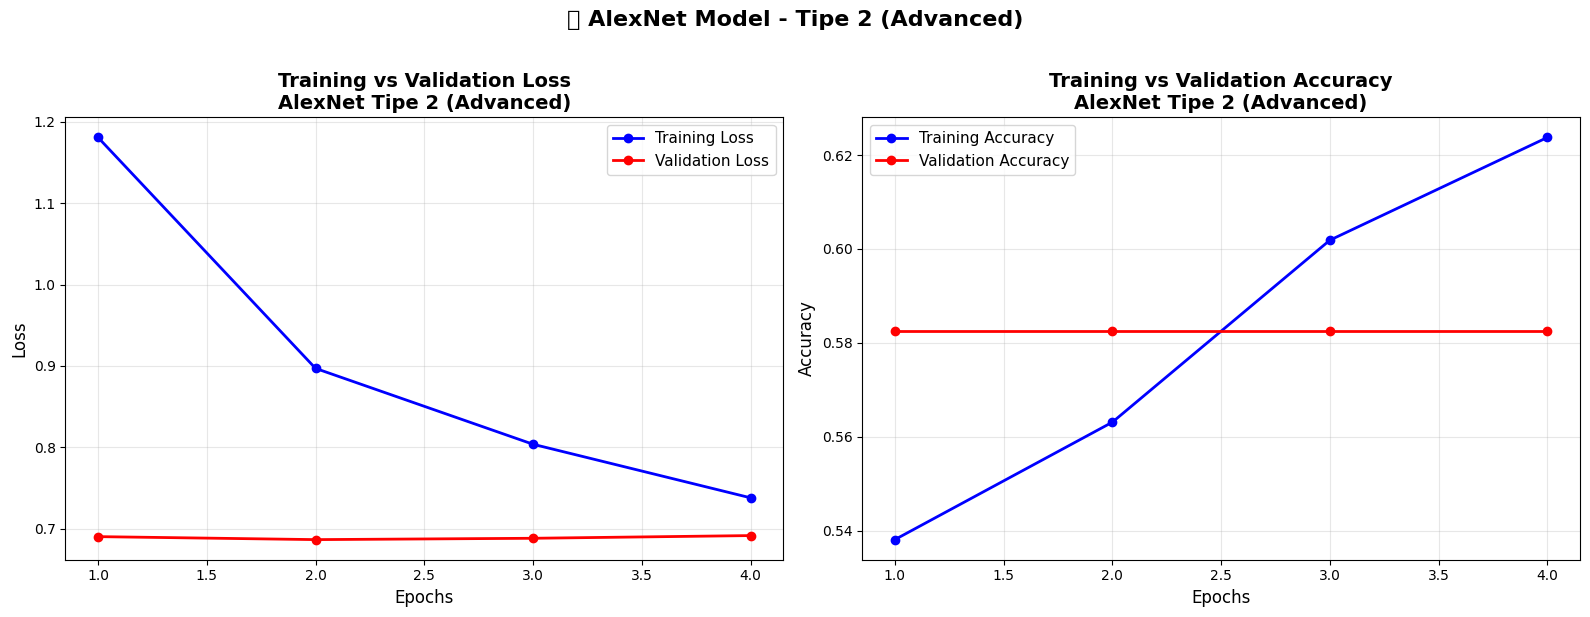


📊 SUMMARY HASIL TRAINING - ALEXNET TIPE 2
Epochs: 20 | Batch Size: 64 | LR: 0.0001
Actual Epochs Run: 4
------------------------------------------------------------
Final Training Loss      : 0.7379
Final Training Accuracy  : 0.6237 (62.37%)
Final Validation Loss    : 0.6915
Final Validation Accuracy: 0.5825 (58.25%)
Training Duration        : 15.14s (0.25 min)
------------------------------------------------------------
✅ Model balance - tidak ada overfitting/underfitting signifikan


In [80]:
import matplotlib.pyplot as plt

# Ambil data history
loss_values_v2 = history_alex_v2.history['loss']
val_loss_values_v2 = history_alex_v2.history['val_loss']
accuracy_values_v2 = history_alex_v2.history['accuracy']
val_accuracy_values_v2 = history_alex_v2.history['val_accuracy']

epochs_range = range(1, len(loss_values_v2) + 1)

# Buat figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Loss
axes[0].plot(epochs_range, loss_values_v2, 'bo-', label='Training Loss', linewidth=2, markersize=6)
axes[0].plot(epochs_range, val_loss_values_v2, 'ro-', label='Validation Loss', linewidth=2, markersize=6)
axes[0].set_title('Training vs Validation Loss\nAlexNet Tipe 2 (Advanced)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Subplot 2: Accuracy
axes[1].plot(epochs_range, accuracy_values_v2, 'bo-', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].plot(epochs_range, val_accuracy_values_v2, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
axes[1].set_title('Training vs Validation Accuracy\nAlexNet Tipe 2 (Advanced)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('🟠 AlexNet Model - Tipe 2 (Advanced)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary
print("\n" + "="*60)
print("📊 SUMMARY HASIL TRAINING - ALEXNET TIPE 2")
print("="*60)
print(f"Epochs: {epochs_type2} | Batch Size: {batch_size_type2} | LR: 0.0001")
print(f"Actual Epochs Run: {len(loss_values_v2)}")
print("-"*60)
print(f"Final Training Loss      : {loss_values_v2[-1]:.4f}")
print(f"Final Training Accuracy  : {accuracy_values_v2[-1]:.4f} ({accuracy_values_v2[-1]*100:.2f}%)")
print(f"Final Validation Loss    : {val_loss_values_v2[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy_values_v2[-1]:.4f} ({val_accuracy_values_v2[-1]*100:.2f}%)")
print(f"Training Duration        : {training_duration_v2:.2f}s ({training_duration_v2/60:.2f} min)")
print("-"*60)

# Deteksi overfitting
gap = accuracy_values_v2[-1] - val_accuracy_values_v2[-1]
if gap > 0.1:
    print("⚠️  OVERFITTING TERDETEKSI!")
    print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")
elif gap < -0.05:
    print("⚠️  UNDERFITTING TERDETEKSI!")
else:
    print("✅ Model balance - tidak ada overfitting/underfitting signifikan")

print("="*60)

### Evaluate Model

In [81]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("📈 EVALUASI MODEL ALEXNET - TIPE 2")
print("="*60)

# Evaluate pada validation set (pakai data 64x64)
loss_alex_v2, accuracy_alex_v2 = alexnet_v2.evaluate(val_images_64, val_labels, verbose=1)

print("\n" + "="*60)
print("📊 HASIL EVALUASI FINAL - ALEXNET TIPE 2")
print("="*60)
print(f"Validation Loss    : {loss_alex_v2:.4f}")
print(f"Validation Accuracy: {accuracy_alex_v2:.4f} ({accuracy_alex_v2*100:.2f}%)")
print("="*60)

# Interpretasi hasil
print("\n" + "="*60)
if accuracy_alex_v2 > 0.85:
    print("✅ Model AlexNet Tipe 2 memiliki performa BAIK!")
elif accuracy_alex_v2 > 0.75:
    print("⚠️  Model AlexNet Tipe 2 cukup baik, masih bisa ditingkatkan.")
else:
    print("❌ Model AlexNet Tipe 2 perlu perbaikan.")
print("="*60)

📈 EVALUASI MODEL ALEXNET - TIPE 2
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5837 - loss: 0.6901

📊 HASIL EVALUASI FINAL - ALEXNET TIPE 2
Validation Loss    : 0.6902
Validation Accuracy: 0.5825 (58.25%)

❌ Model AlexNet Tipe 2 perlu perbaikan.


### Confusion Matrix & Classification Report

🔍 ANALISIS CONFUSION MATRIX - ALEXNET VERSI 2

📊 Melakukan prediksi pada validation set...
Total prediksi: 400
Shape y_true: (400,)
Shape y_pred: (400,)

🔢 Menghitung Confusion Matrix...

📋 CONFUSION MATRIX - ALEXNET VERSI 2

                    PREDICTED
                Female(0)    Male(1)
    ACTUAL
    Female(0)       233           0
    Male(1)         167           0


📊 DETAIL METRIK TP, TN, FP, FN:
✅ True Positive  (TP):    0 ( 0.00%)
   → Male diprediksi sebagai Male (BENAR)

✅ True Negative  (TN):  233 (58.25%)
   → Female diprediksi sebagai Female (BENAR)

❌ False Positive (FP):    0 ( 0.00%)
   → Female diprediksi sebagai Male (SALAH - Type I Error)

❌ False Negative (FN):  167 (41.75%)
   → Male diprediksi sebagai Female (SALAH - Type II Error)

------------------------------------------------------------
📌 Total Prediksi Benar:  233 (58.25%)
📌 Total Prediksi Salah:  167 (41.75%)

📈 METRIK PERFORMA LANJUTAN:
Accuracy         : 0.5825 (58.25%)
   → (TP + TN) / Total

Precis

/tmp/ipython-input-2629983683.py:180: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2629983683.py:180: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2629983683.py:180: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure

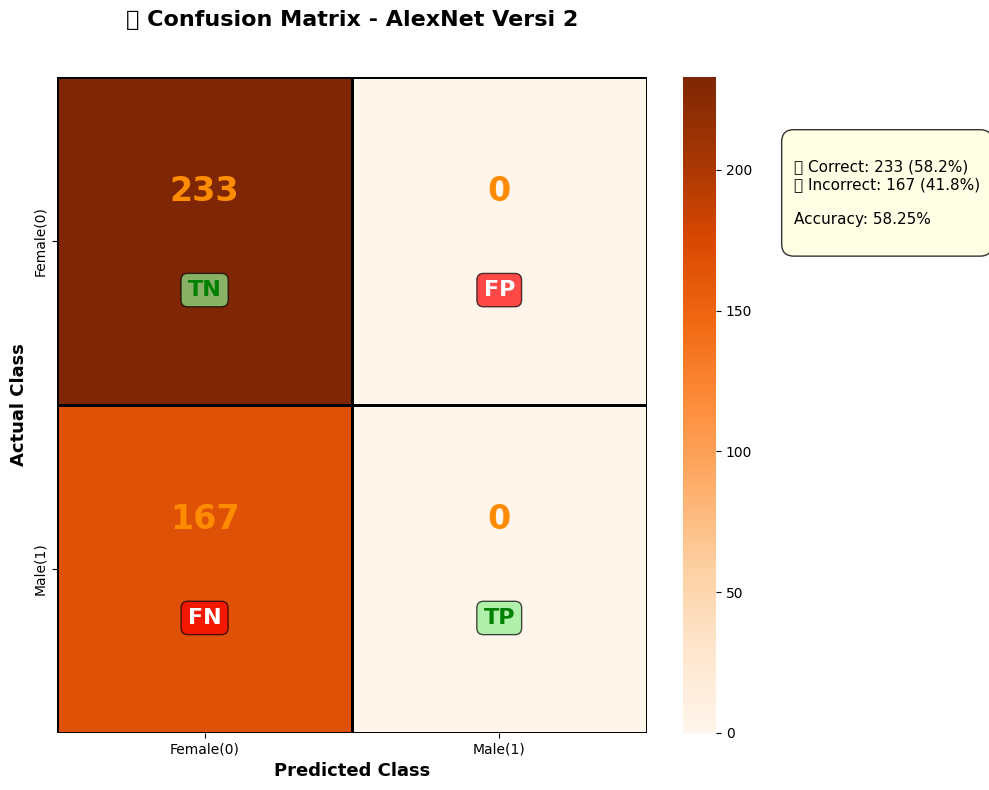


📄 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   Female(0)     0.5825    1.0000    0.7362       233
     Male(1)     0.0000    0.0000    0.0000       167

    accuracy                         0.5825       400
   macro avg     0.2913    0.5000    0.3681       400
weighted avg     0.3393    0.5825    0.4288       400


💡 INTERPRETASI HASIL:
⚠️  Model cenderung UNDER-PREDICT Male
   → 167 Male salah diprediksi sebagai Female
   → 0 Female salah diprediksi sebagai Male

📌 REKOMENDASI:
   - Adjust threshold dari 0.5 ke nilai lebih rendah (misal 0.4)
   - Tambah data augmentation untuk kelas Male

🎯 Overall Accuracy: 58.25%
   → POOR performance - perlu perbaikan signifikan

✅ Analisis AlexNet Versi 2 selesai! Hasil disimpan ke 'results_alex_v2'


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [82]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("🔍 ANALISIS CONFUSION MATRIX - ALEXNET VERSI 2")
print("="*60)

# ========================================
# 1️⃣ PREDIKSI PADA VALIDATION SET
# ========================================
print("\n📊 Melakukan prediksi pada validation set...")

# PENTING: Pakai val_images_64 (data 64x64)
y_pred_proba_alex_v2 = alexnet_v2.predict(val_images_64, verbose=0)

# Convert probabilitas ke binary predictions (threshold = 0.5)
y_pred_alex_v2 = (y_pred_proba_alex_v2 > 0.5).astype(int).flatten()

# Ground truth labels
y_true = val_labels.astype(int)

print(f"Total prediksi: {len(y_pred_alex_v2)}")
print(f"Shape y_true: {y_true.shape}")
print(f"Shape y_pred: {y_pred_alex_v2.shape}")

# ========================================
# 2️⃣ HITUNG CONFUSION MATRIX
# ========================================
print("\n🔢 Menghitung Confusion Matrix...")

cm_alex_v2 = confusion_matrix(y_true, y_pred_alex_v2)

# Extract TP, TN, FP, FN
TN_alex_v2 = cm_alex_v2[0, 0]  # True Negative (Female → Female)
FP_alex_v2 = cm_alex_v2[0, 1]  # False Positive (Female → Male)
FN_alex_v2 = cm_alex_v2[1, 0]  # False Negative (Male → Female)
TP_alex_v2 = cm_alex_v2[1, 1]  # True Positive (Male → Male)

total_alex_v2 = TN_alex_v2 + FP_alex_v2 + FN_alex_v2 + TP_alex_v2

print("\n" + "="*60)
print("📋 CONFUSION MATRIX - ALEXNET VERSI 2")
print("="*60)
print(f"""
                    PREDICTED
                Female(0)    Male(1)
    ACTUAL
    Female(0)      {TN_alex_v2:4d}        {FP_alex_v2:4d}
    Male(1)        {FN_alex_v2:4d}        {TP_alex_v2:4d}
""")
print("="*60)

# ========================================
# 3️⃣ DETAIL METRIK
# ========================================
print("\n📊 DETAIL METRIK TP, TN, FP, FN:")
print("="*60)
print(f"✅ True Positive  (TP): {TP_alex_v2:4d} ({TP_alex_v2/total_alex_v2*100:5.2f}%)")
print(f"   → Male diprediksi sebagai Male (BENAR)")
print()
print(f"✅ True Negative  (TN): {TN_alex_v2:4d} ({TN_alex_v2/total_alex_v2*100:5.2f}%)")
print(f"   → Female diprediksi sebagai Female (BENAR)")
print()
print(f"❌ False Positive (FP): {FP_alex_v2:4d} ({FP_alex_v2/total_alex_v2*100:5.2f}%)")
print(f"   → Female diprediksi sebagai Male (SALAH - Type I Error)")
print()
print(f"❌ False Negative (FN): {FN_alex_v2:4d} ({FN_alex_v2/total_alex_v2*100:5.2f}%)")
print(f"   → Male diprediksi sebagai Female (SALAH - Type II Error)")
print()
print("-"*60)
print(f"📌 Total Prediksi Benar: {TP_alex_v2 + TN_alex_v2:4d} ({(TP_alex_v2+TN_alex_v2)/total_alex_v2*100:5.2f}%)")
print(f"📌 Total Prediksi Salah: {FP_alex_v2 + FN_alex_v2:4d} ({(FP_alex_v2+FN_alex_v2)/total_alex_v2*100:5.2f}%)")
print("="*60)

# ========================================
# 4️⃣ HITUNG METRIK TAMBAHAN
# ========================================
print("\n📈 METRIK PERFORMA LANJUTAN:")
print("="*60)

# Accuracy
accuracy_alex_v2_calc = (TP_alex_v2 + TN_alex_v2) / total_alex_v2
print(f"Accuracy         : {accuracy_alex_v2_calc:.4f} ({accuracy_alex_v2_calc*100:.2f}%)")
print(f"   → (TP + TN) / Total")
print()

# Precision (Male class)
precision_alex_v2 = TP_alex_v2 / (TP_alex_v2 + FP_alex_v2) if (TP_alex_v2 + FP_alex_v2) > 0 else 0
print(f"Precision (Male) : {precision_alex_v2:.4f} ({precision_alex_v2*100:.2f}%)")
print(f"   → TP / (TP + FP)")
print(f"   → Dari semua yang diprediksi Male, berapa yang benar?")
print()

# Recall / Sensitivity (Male class)
recall_alex_v2 = TP_alex_v2 / (TP_alex_v2 + FN_alex_v2) if (TP_alex_v2 + FN_alex_v2) > 0 else 0
print(f"Recall (Male)    : {recall_alex_v2:.4f} ({recall_alex_v2*100:.2f}%)")
print(f"   → TP / (TP + FN)")
print(f"   → Dari semua Male sebenarnya, berapa yang terdeteksi?")
print()

# Specificity (Female class)
specificity_alex_v2 = TN_alex_v2 / (TN_alex_v2 + FP_alex_v2) if (TN_alex_v2 + FP_alex_v2) > 0 else 0
print(f"Specificity (Female): {specificity_alex_v2:.4f} ({specificity_alex_v2*100:.2f}%)")
print(f"   → TN / (TN + FP)")
print(f"   → Dari semua Female sebenarnya, berapa yang terdeteksi?")
print()

# F1-Score (Male class)
f1_alex_v2 = 2 * (precision_alex_v2 * recall_alex_v2) / (precision_alex_v2 + recall_alex_v2) if (precision_alex_v2 + recall_alex_v2) > 0 else 0
print(f"F1-Score (Male)  : {f1_alex_v2:.4f}")
print(f"   → 2 × (Precision × Recall) / (Precision + Recall)")
print(f"   → Balance antara Precision dan Recall")
print()

# Error Rate
error_rate_alex_v2 = (FP_alex_v2 + FN_alex_v2) / total_alex_v2
print(f"Error Rate       : {error_rate_alex_v2:.4f} ({error_rate_alex_v2*100:.2f}%)")
print(f"   → (FP + FN) / Total")
print("="*60)

# ========================================
# 5️⃣ VISUALISASI CONFUSION MATRIX
# ========================================
print("\n🎨 Membuat visualisasi Confusion Matrix...")

plt.figure(figsize=(10, 8))

# Buat heatmap dengan annotasi custom
ax = sns.heatmap(cm_alex_v2, annot=False, fmt='d', cmap='Oranges', cbar=True,
                 xticklabels=['Female(0)', 'Male(1)'],
                 yticklabels=['Female(0)', 'Male(1)'],
                 linewidths=2, linecolor='black')

# Tambahkan angka + label TP/TN/FP/FN di setiap cell
# Cell [0,0] - TN (True Negative)
ax.text(0.5, 0.35, f'{TN_alex_v2}', ha='center', va='center',
        fontsize=24, color='darkorange', weight='bold')
ax.text(0.5, 0.65, 'TN', ha='center', va='center',
        fontsize=16, color='green', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

# Cell [0,1] - FP (False Positive)
ax.text(1.5, 0.35, f'{FP_alex_v2}', ha='center', va='center',
        fontsize=24, color='darkorange', weight='bold')
ax.text(1.5, 0.65, 'FP', ha='center', va='center',
        fontsize=16, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))

# Cell [1,0] - FN (False Negative)
ax.text(0.5, 1.35, f'{FN_alex_v2}', ha='center', va='center',
        fontsize=24, color='darkorange', weight='bold')
ax.text(0.5, 1.65, 'FN', ha='center', va='center',
        fontsize=16, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))

# Cell [1,1] - TP (True Positive)
ax.text(1.5, 1.35, f'{TP_alex_v2}', ha='center', va='center',
        fontsize=24, color='darkorange', weight='bold')
ax.text(1.5, 1.65, 'TP', ha='center', va='center',
        fontsize=16, color='green', weight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

plt.title('🟠 Confusion Matrix - AlexNet Versi 2\n',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual Class', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=13, fontweight='bold')

# Tambahkan legend keterangan
legend_text = f"""
✅ Correct: {TP_alex_v2 + TN_alex_v2} ({(TP_alex_v2+TN_alex_v2)/total_alex_v2*100:.1f}%)
❌ Incorrect: {FP_alex_v2 + FN_alex_v2} ({(FP_alex_v2+FN_alex_v2)/total_alex_v2*100:.1f}%)

Accuracy: {accuracy_alex_v2_calc*100:.2f}%
"""
plt.text(2.5, 0.5, legend_text, fontsize=11,
         bbox=dict(boxstyle='round,pad=0.8', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

# ========================================
# 6️⃣ CLASSIFICATION REPORT
# ========================================
print("\n📄 CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_true, y_pred_alex_v2,
                          target_names=['Female(0)', 'Male(1)'],
                          digits=4))
print("="*60)

# ========================================
# 7️⃣ INTERPRETASI & REKOMENDASI
# ========================================
print("\n💡 INTERPRETASI HASIL:")
print("="*60)

if FP_alex_v2 > FN_alex_v2:
    print("⚠️  Model cenderung OVER-PREDICT Male")
    print(f"   → {FP_alex_v2} Female salah diprediksi sebagai Male")
    print(f"   → {FN_alex_v2} Male salah diprediksi sebagai Female")
    print("\n📌 REKOMENDASI:")
    print("   - Adjust threshold dari 0.5 ke nilai lebih tinggi (misal 0.6)")
    print("   - Tambah data augmentation untuk kelas Female")
    print("   - Gunakan class weights saat training")
elif FN_alex_v2 > FP_alex_v2:
    print("⚠️  Model cenderung UNDER-PREDICT Male")
    print(f"   → {FN_alex_v2} Male salah diprediksi sebagai Female")
    print(f"   → {FP_alex_v2} Female salah diprediksi sebagai Male")
    print("\n📌 REKOMENDASI:")
    print("   - Adjust threshold dari 0.5 ke nilai lebih rendah (misal 0.4)")
    print("   - Tambah data augmentation untuk kelas Male")
else:
    print("✅ Model balance dalam error distribution")
    print(f"   → FP: {FP_alex_v2}, FN: {FN_alex_v2}")

print()
overall_acc_v2 = accuracy_alex_v2_calc * 100
print(f"🎯 Overall Accuracy: {overall_acc_v2:.2f}%")
if accuracy_alex_v2_calc > 0.90:
    print("   → EXCELLENT performance!")
elif accuracy_alex_v2_calc > 0.80:
    print("   → GOOD performance!")
elif accuracy_alex_v2_calc > 0.70:
    print("   → FAIR performance - masih bisa ditingkatkan")
else:
    print("   → POOR performance - perlu perbaikan signifikan")

print("="*60)

# ========================================
# 8️⃣ SIMPAN HASIL
# ========================================
results_alex_v2 = {
    'confusion_matrix': cm_alex_v2,
    'TP': TP_alex_v2,
    'TN': TN_alex_v2,
    'FP': FP_alex_v2,
    'FN': FN_alex_v2,
    'accuracy': accuracy_alex_v2_calc,
    'precision': precision_alex_v2,
    'recall': recall_alex_v2,
    'specificity': specificity_alex_v2,
    'f1_score': f1_alex_v2,
    'error_rate': error_rate_alex_v2
}

print("\n✅ Analisis AlexNet Versi 2 selesai! Hasil disimpan ke 'results_alex_v2'")

## Test (V1 + V2)

🟠 TEST PREDIKSI - ALEXNET TIPE 1 & TIPE 2
Upload gambar sekali, test di kedua model sekaligus
------------------------------------------------------------


Saving LUCINTA.webp to LUCINTA (3).webp

📷 Memproses gambar: "LUCINTA (3).webp"
Ukuran file: 6,030 bytes
✅ Preprocessing done: (1, 64, 64, 3)

📊 HASIL PREDIKSI UNTUK: LUCINTA (3).webp
🟠 ALEXNET TIPE 1 (Lightweight):
   Prediksi: Female
   Prob Male: 0.0415 (4.15%)
   Confidence: 0.9585 (95.85%)

🟠 ALEXNET TIPE 2 (Advanced):
   Prediksi: Female
   Prob Male: 0.4926 (49.26%)
   Confidence: 0.5074 (50.74%)

✅ KEDUA MODEL SEPAKAT: Female


/tmp/ipython-input-3778328609.py:140: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


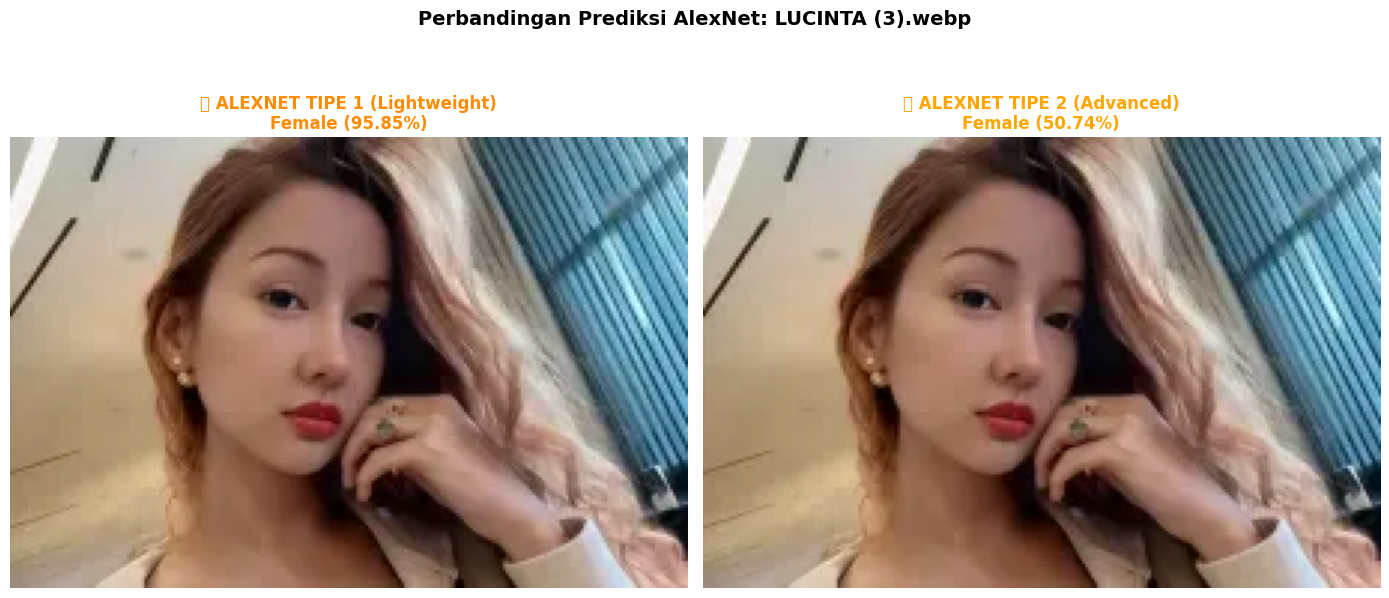


✅ Prediksi selesai!

📊 TABEL PERBANDINGAN HASIL:

File: LUCINTA (3).webp
  Tipe 1: Female (Conf: 95.85%, Prob Male:  4.15%)
  Tipe 2: Female (Conf: 50.74%, Prob Male: 49.26%)
  Status: ✅ SEPAKAT


In [84]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("="*60)
print("🟠 TEST PREDIKSI - ALEXNET TIPE 1 & TIPE 2")
print("="*60)
print("Upload gambar sekali, test di kedua model sekaligus")
print("-"*60)

# Upload gambar dari komputer lokal
uploaded = files.upload()

# Simpan hasil prediksi untuk perbandingan
predictions_comparison = []

# Proses setiap gambar yang diupload
for fn in uploaded.keys():
    print(f'\n{"="*60}')
    print(f'📷 Memproses gambar: "{fn}"')
    print(f'Ukuran file: {len(uploaded[fn]):,} bytes')
    print(f'{"="*60}')

    # Baca gambar
    image_path = fn
    img = cv2.imread(image_path)

    if img is None:
        print(f"❌ Error: Tidak dapat membaca gambar {image_path}")
        continue

    # === PREPROCESSING (SAMA DENGAN TRAINING) ===

    # 1. Resize ke 64x64 (AlexNet V1 & V2 pakai 64x64)
    target_size = (64, 64)  # ← GANTI KE 64x64
    img_resized = cv2.resize(img, target_size)

    # 2. Konversi BGR (OpenCV) ke RGB (sesuai training)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # 3. Normalisasi: ubah range piksel dari [0, 255] ke [0, 1]
    img_normalized = img_rgb.astype('float32') / 255.0

    # 4. Tambah dimensi batch: (64, 64, 3) -> (1, 64, 64, 3)
    img_input = np.expand_dims(img_normalized, axis=0)

    print(f"✅ Preprocessing done: {img_input.shape}")

    # === PREDIKSI DENGAN KEDUA MODEL ===
    results = {}

    # Prediksi Model Tipe 1
    if 'alexnet' in globals():
        pred1 = alexnet.predict(img_input, verbose=0)
        prob_male_1 = pred1[0][0]
        class_1 = "Male" if prob_male_1 > 0.5 else "Female"
        conf_1 = prob_male_1 if prob_male_1 > 0.5 else (1 - prob_male_1)
        results['type1'] = {
            'prob_male': prob_male_1,
            'class': class_1,
            'confidence': conf_1
        }
    else:
        print("⚠️  Model 'alexnet' tidak ditemukan, skip prediksi Tipe 1")

    # Prediksi Model Tipe 2
    if 'alexnet_v2' in globals():
        pred2 = alexnet_v2.predict(img_input, verbose=0)
        prob_male_2 = pred2[0][0]
        class_2 = "Male" if prob_male_2 > 0.5 else "Female"
        conf_2 = prob_male_2 if prob_male_2 > 0.5 else (1 - prob_male_2)
        results['type2'] = {
            'prob_male': prob_male_2,
            'class': class_2,
            'confidence': conf_2
        }
    else:
        print("⚠️  Model 'alexnet_v2' tidak ditemukan, skip prediksi Tipe 2")

    # Simpan hasil untuk tabel perbandingan
    if 'type1' in results and 'type2' in results:
        predictions_comparison.append({
            'filename': fn,
            'type1_prob_male': results['type1']['prob_male'],
            'type1_class': results['type1']['class'],
            'type1_conf': results['type1']['confidence'],
            'type2_prob_male': results['type2']['prob_male'],
            'type2_class': results['type2']['class'],
            'type2_conf': results['type2']['confidence']
        })

    # === TAMPILKAN HASIL SIDE-BY-SIDE ===
    print(f"\n📊 HASIL PREDIKSI UNTUK: {fn}")
    print(f"="*60)

    if 'type1' in results:
        print(f"🟠 ALEXNET TIPE 1 (Lightweight):")
        print(f"   Prediksi: {results['type1']['class']}")
        print(f"   Prob Male: {results['type1']['prob_male']:.4f} ({results['type1']['prob_male']*100:.2f}%)")
        print(f"   Confidence: {results['type1']['confidence']:.4f} ({results['type1']['confidence']*100:.2f}%)")

    if 'type2' in results:
        print(f"\n🟠 ALEXNET TIPE 2 (Advanced):")
        print(f"   Prediksi: {results['type2']['class']}")
        print(f"   Prob Male: {results['type2']['prob_male']:.4f} ({results['type2']['prob_male']*100:.2f}%)")
        print(f"   Confidence: {results['type2']['confidence']:.4f} ({results['type2']['confidence']*100:.2f}%)")

    # Cek apakah prediksi sama atau beda
    if 'type1' in results and 'type2' in results:
        if results['type1']['class'] == results['type2']['class']:
            print(f"\n✅ KEDUA MODEL SEPAKAT: {results['type1']['class']}")
        else:
            print(f"\n⚠️  PREDIKSI BERBEDA!")
            print(f"   Tipe 1: {results['type1']['class']} ({results['type1']['confidence']*100:.2f}%)")
            print(f"   Tipe 2: {results['type2']['class']} ({results['type2']['confidence']*100:.2f}%)")

    print(f"="*60)

    # === VISUALISASI SIDE-BY-SIDE ===
    # Untuk display, resize kembali ke ukuran lebih besar
    img_display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if 'type1' in results and 'type2' in results:
        fig, axes = plt.subplots(1, 2, figsize=(14, 7))

        # Model Tipe 1
        axes[0].imshow(img_display)
        axes[0].set_title(f"🟠 ALEXNET TIPE 1 (Lightweight)\n{results['type1']['class']} ({results['type1']['confidence']*100:.2f}%)",
                          fontsize=12, fontweight='bold', color='darkorange')
        axes[0].axis('off')

        # Model Tipe 2
        axes[1].imshow(img_display)
        axes[1].set_title(f"🟠 ALEXNET TIPE 2 (Advanced)\n{results['type2']['class']} ({results['type2']['confidence']*100:.2f}%)",
                          fontsize=12, fontweight='bold', color='orange')
        axes[1].axis('off')

        plt.suptitle(f"Perbandingan Prediksi AlexNet: {fn}", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    elif 'type1' in results or 'type2' in results:
        # Tampilkan satu model aja
        plt.figure(figsize=(8, 8))
        plt.imshow(img_display)
        if 'type1' in results:
            plt.title(f"🟠 ALEXNET TIPE 1\n{results['type1']['class']} ({results['type1']['confidence']*100:.2f}%)",
                     fontsize=14, fontweight='bold')
        else:
            plt.title(f"🟠 ALEXNET TIPE 2\n{results['type2']['class']} ({results['type2']['confidence']*100:.2f}%)",
                     fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

print("\n" + "="*60)
print("✅ Prediksi selesai!")
print("="*60)

# Tampilkan tabel perbandingan jika ada prediksi dari kedua model
if predictions_comparison:
    print("\n📊 TABEL PERBANDINGAN HASIL:")
    print("="*60)
    for pred in predictions_comparison:
        print(f"\nFile: {pred['filename']}")
        print(f"  Tipe 1: {pred['type1_class']:6s} (Conf: {pred['type1_conf']*100:5.2f}%, Prob Male: {pred['type1_prob_male']*100:5.2f}%)")
        print(f"  Tipe 2: {pred['type2_class']:6s} (Conf: {pred['type2_conf']*100:5.2f}%, Prob Male: {pred['type2_prob_male']*100:5.2f}%)")

        if pred['type1_class'] == pred['type2_class']:
            print(f"  Status: ✅ SEPAKAT")
        else:
            print(f"  Status: ⚠️  BERBEDA")
    print("="*60)